In [1]:
import numpy as np

from causal_gym.envs import ExamplePCH_9_5, ExampleSCM_9_5
from causal_gym.envs import ExerciseSCM, ExercisePCH
from causalrl.wrappers import WhereDo
from causalrl.wrappers.utils_wheredo import flatten
from causal_gym.core import causal_graph
from causal_gym import SCM, PCH
from causal_gym.core.causal_graph import CausalGraph

import multiprocess as mp
from multiprocess import Process

## Example 9.5
Consider a MAB environment $\mathcal{M}^*$ described by an SCM:
$$\mathcal{M}^* = \langle \boldsymbol{U} = \{U_{1}, U_{2}\}, \boldsymbol{V} = \{X_1, X_1, Y\}, \mathcal{F} = \{\mathcal{F}_i\}, P(\boldsymbol{U})\rangle $$

where $U_{i,1}, U_{i,2}, U_{i,3}$ represent, respectively, human erros when stocking the inventory, and uncertainties indemand, and monetary values of the goods. The causal mechanisms $\mathcal{F}_i$ representing the system dynamics transitioning from day $i-1$ to $i$ are defined as:
$$\mathcal{F} =
\begin{cases}
X_1 \gets U_{1},\\
X_2 \gets X_{1} \oplus U_{2},\\
Y \gets X_{2} \oplus U_{2}
\end{cases}$$

and $P(\boldsymbol{U})$ is the distribution of binary variables $\{U_{1}, U_{2}\}$. They are independent variables drawn from $P(U_{1} = 1)= P(U_{2}=1) =.5$.

The causal graph entailed by $\mathcal{M}^*$ is as follows:

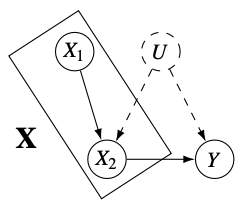

### Evaluating behavioral policy
From the example, we see that with the following mixed policy space: by $\langle \{\},\{X_1\},\{X_2\} \rangle$, at each time step, we can only achieve an expected reward of: 

$$\mathbb{E}[Y] = \mathbb{E}[(X_1\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = 0.5$$
$$\mathbb{E}[Y|\textit{do}(x_1)] = \mathbb{E}[(x_1\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = x_1$$
$$\mathbb{E}[Y|\textit{do}(x_2)] = \mathbb{E}[(x_2\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = 0.5(x_2) + 0.5(1-x_2) = 0.5$$

We simulate the do(.) and do($x_2$) below and observe the same effect by running TEST_EPI number of episodes and each episode we iterate 1000 samples.

<!-- Thus, if we evaluate this behavioral policy for infinitely long, we would have a discounted cumulative reutrn of,
$$\mathbb{E}[\sum_{i=1}^\infty \gamma^{i-1}Y_i] = \frac{0.1}{1-\gamma}$$

In the following simulation, we use $\gamma = .9$ so we will see a cumulative return close to $\frac{0.1}{1- .9} = 1$. -->

In [ ]:

GAMMA = 0
TEST_EPI = 1000
def worker(policy=None):
    env = ExamplePCH_9_5(max_step=1000)
    _ = env.reset()
    done = False
    reward = 0
    while not done:
        if policy is None:
            x1, x2, y, _, done, _ = env.see()
        else:
            y, _, done, _ = env.do(policy)
        reward = reward * GAMMA + y
    results.append(reward)

# x = 0
manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': None}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Avg return for do(.) is {sum(results)/len(results)}')


# The interventional policy
def policy(u1, u2):
    x1 = u1
    x2 = 1
    return x1, x2

def worker(policy=None):
    env = ExamplePCH_9_5(max_step=1000)
    _ = env.reset()
    done = False
    reward = 0
    while not done:
        if policy is None:
            x1, x2, y, _, done, _ = env.see()
        else:
            y, _, done, _ = env.do(policy)
        reward = reward * GAMMA + y
    results.append(reward)

# x = 0
manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': None}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Avg return for do(x2) is  {sum(results)/len(results)}')


Avg return for do(.) is 0.488
Avg return for do(x2) is  0.471


### Evaluating Optimal Atomic Policy

However, we can have a better interventional policy that takes action $X_1 \leftarrow 1$, we can achieve an expected reward of $$\mathbb{E}[Y|\textit{do}(x_1=1)] = \mathbb{E}[(x_1\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = x_1 $$

Thus, if we evaluate this interventional policy for infinitely long, we would have an average reuturn of,
$$\mathbb{E}[Y|\textit{do}(x_1=1)] = 1.0$$

We notice the same result in the following simulation:

In [19]:
# The interventional policy
def policy(u1, u2):
    x1 = 1
    x2 = x1 ^ u2
    return x1, x2
manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': policy}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Atomic interventional policy avg discounted return is {sum(results)/len(results)}')

Atomic interventional policy avg discounted return is 1.0


In [ ]:
class ExampleSCM_9_5_1(ExampleSCM_9_5):
    def step(self, x1: int, x2: int, u1: int, u2: int):
        y = x2 + u2
        self.num_step += 1
        return y, False, self.num_step > self._max_step, {}
class ExamplePCH_9_5_1(ExamplePCH_9_5):
    def __init__(self, max_step=1):
        super().__init__()
        self.env = ExampleSCM_9_5_1(max_step=max_step)

In [ ]:
def worker(policy=None):
    env = ExamplePCH_9_5_1(max_step=1000)
    _ = env.reset()
    done = False
    reward = 0
    while not done:
        if policy is None:
            x1, x2, y, _, done, _ = env.see()
        else:
            y, _, done, _ = env.do(policy)
        reward = reward * GAMMA + y
    results.append(reward)

def policy_1(u1, u2):
    x1 = 1
    x2 = x1 ^ u2
    return x1, x2
def policy_2(u1, u2):
    x1 = u1
    x2 = 1
    return x1, x2

manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': None}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Atomic interventional policy avg discounted return is {sum(results)/len(results)}')

In [2]:
# Set the colors
colors = {
    'intervention': '#199fff',
    'MUCT': 'lightblue',
    'IB': '#90ee90',
    'target': '#ff5c5c',
    'others': '#ffffff'
}

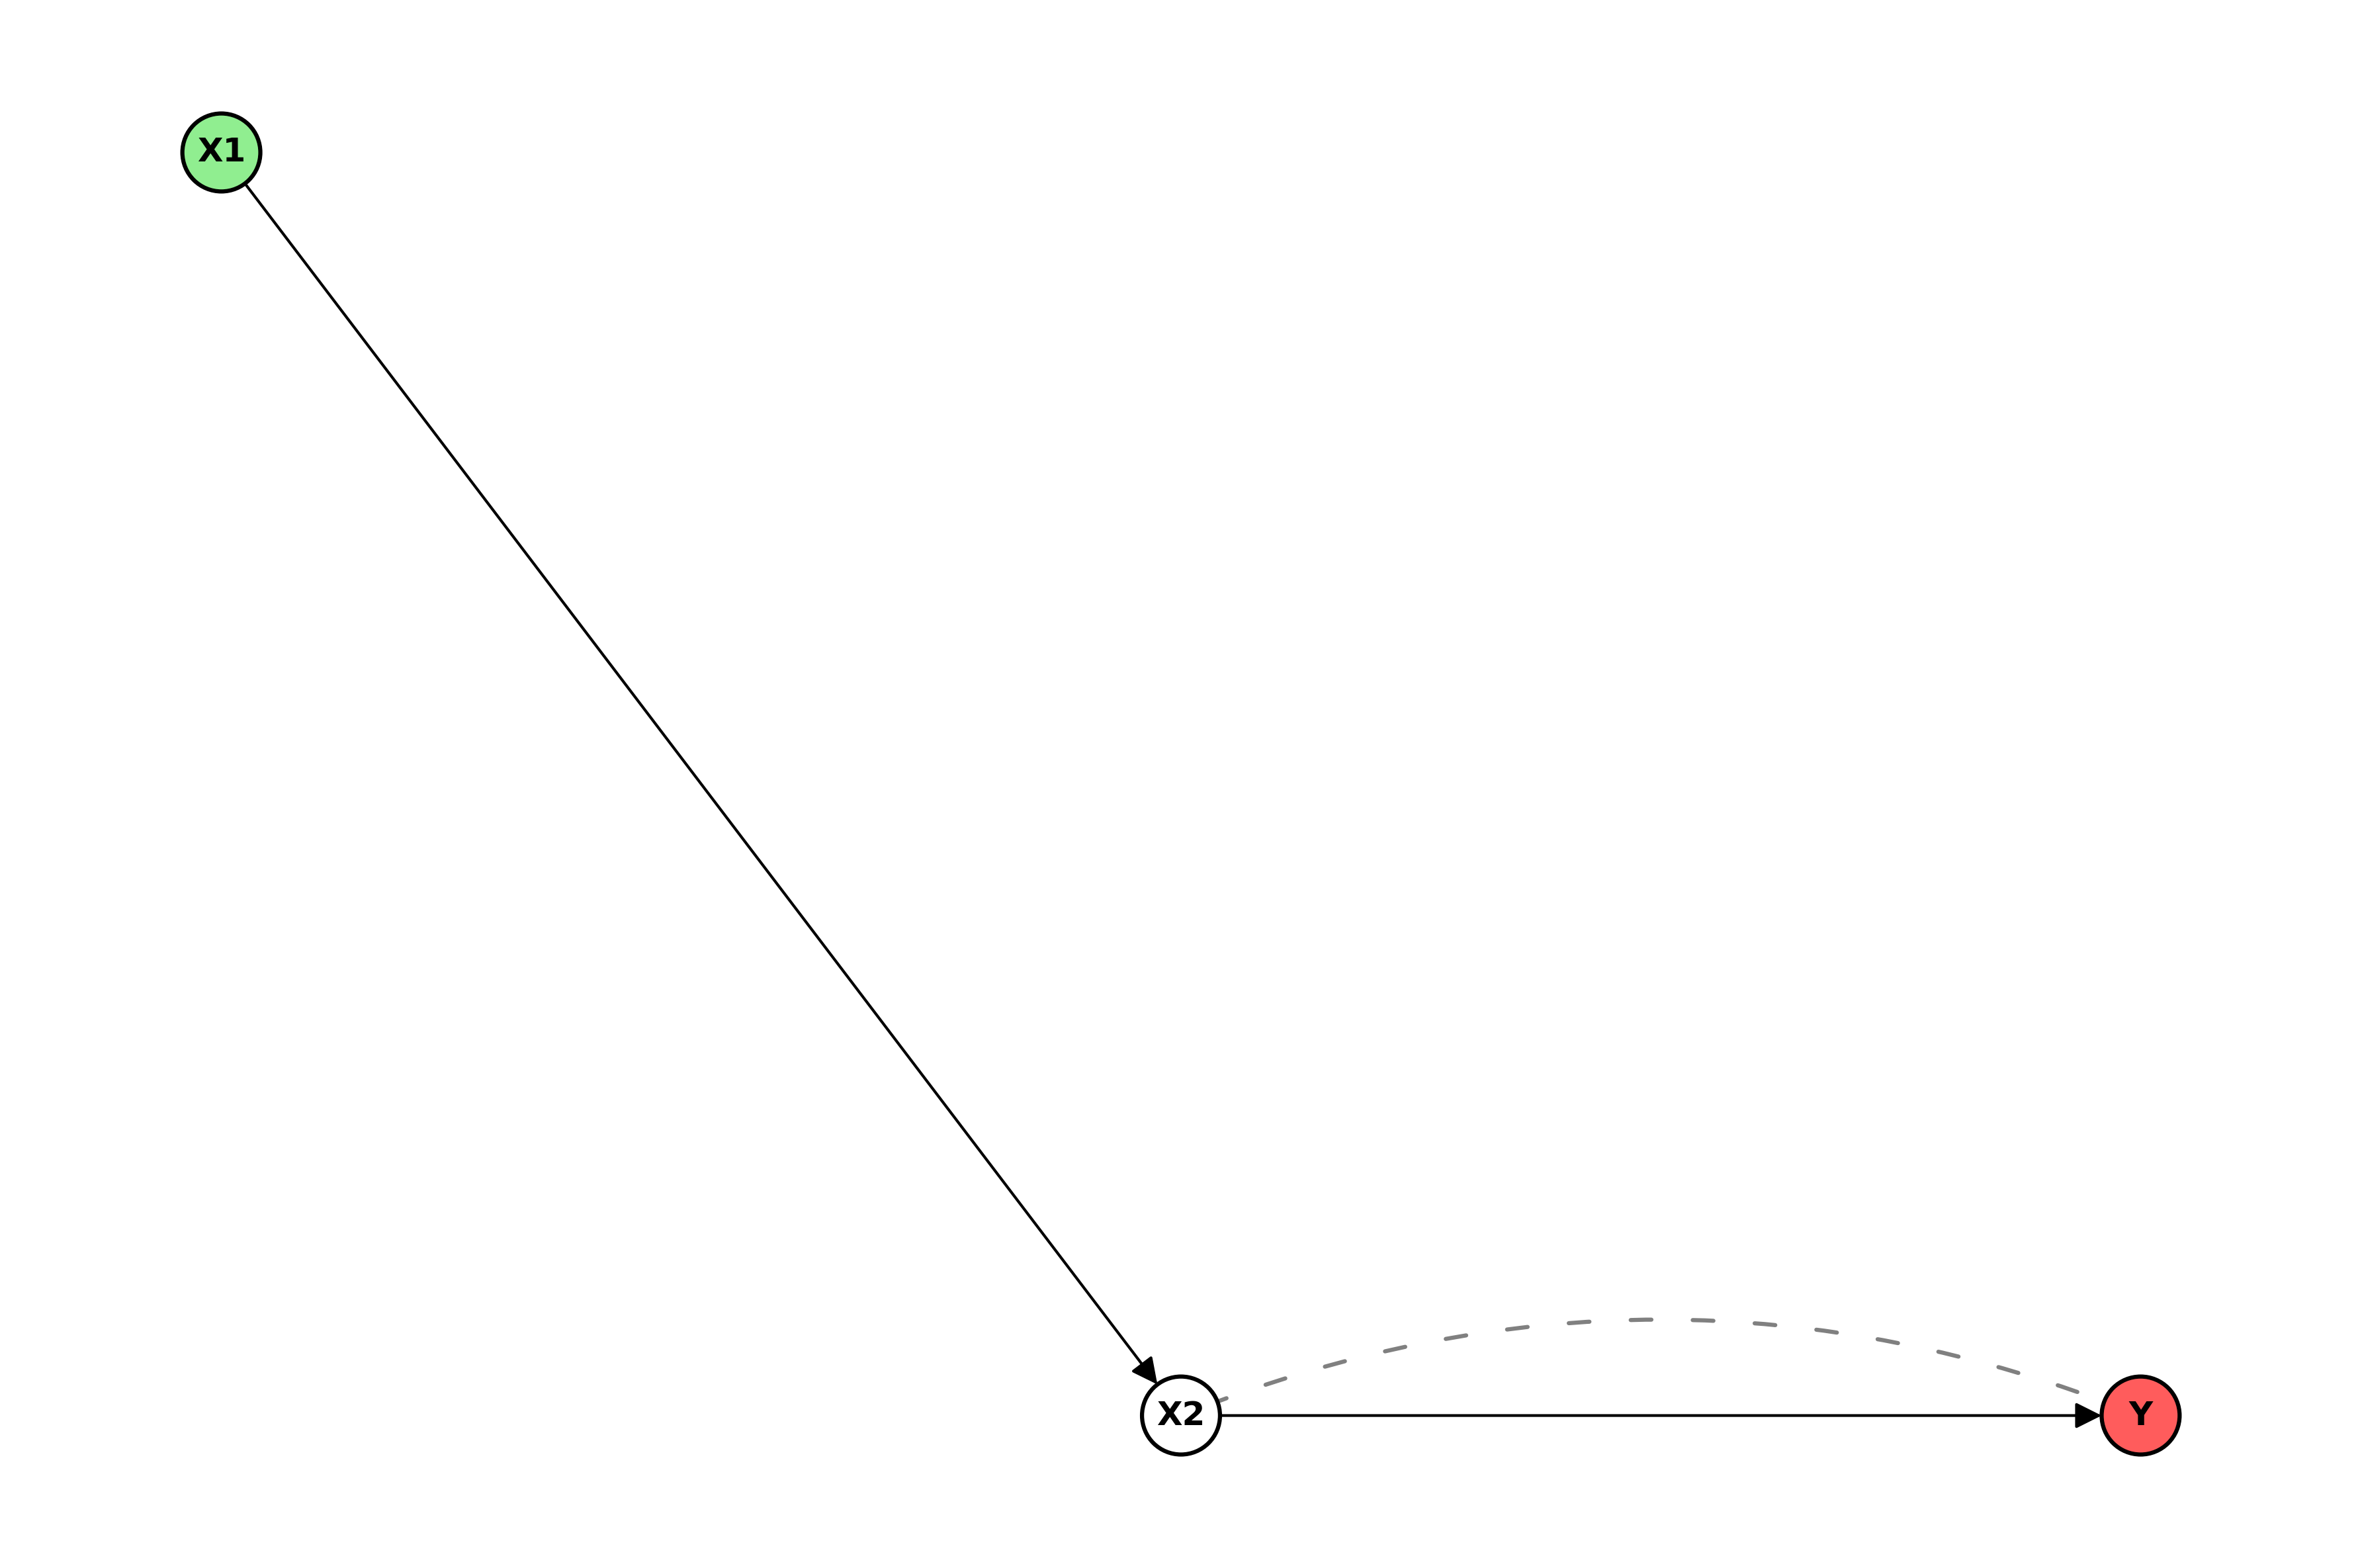

In [4]:
cdag = ExampleSCM_9_5().get_graph()
pos = {'X1':(0,2),
       'X2':(1,1),
       'Y':(2,1)}
task = WhereDo()
Y = 'Y'
cdag.nx_viz(path='./test.png',pos=pos, node_color_map = {colors['target']:'Y',
                                 colors['IB']:flatten(task.IB(cdag, 'Y'))})[0]

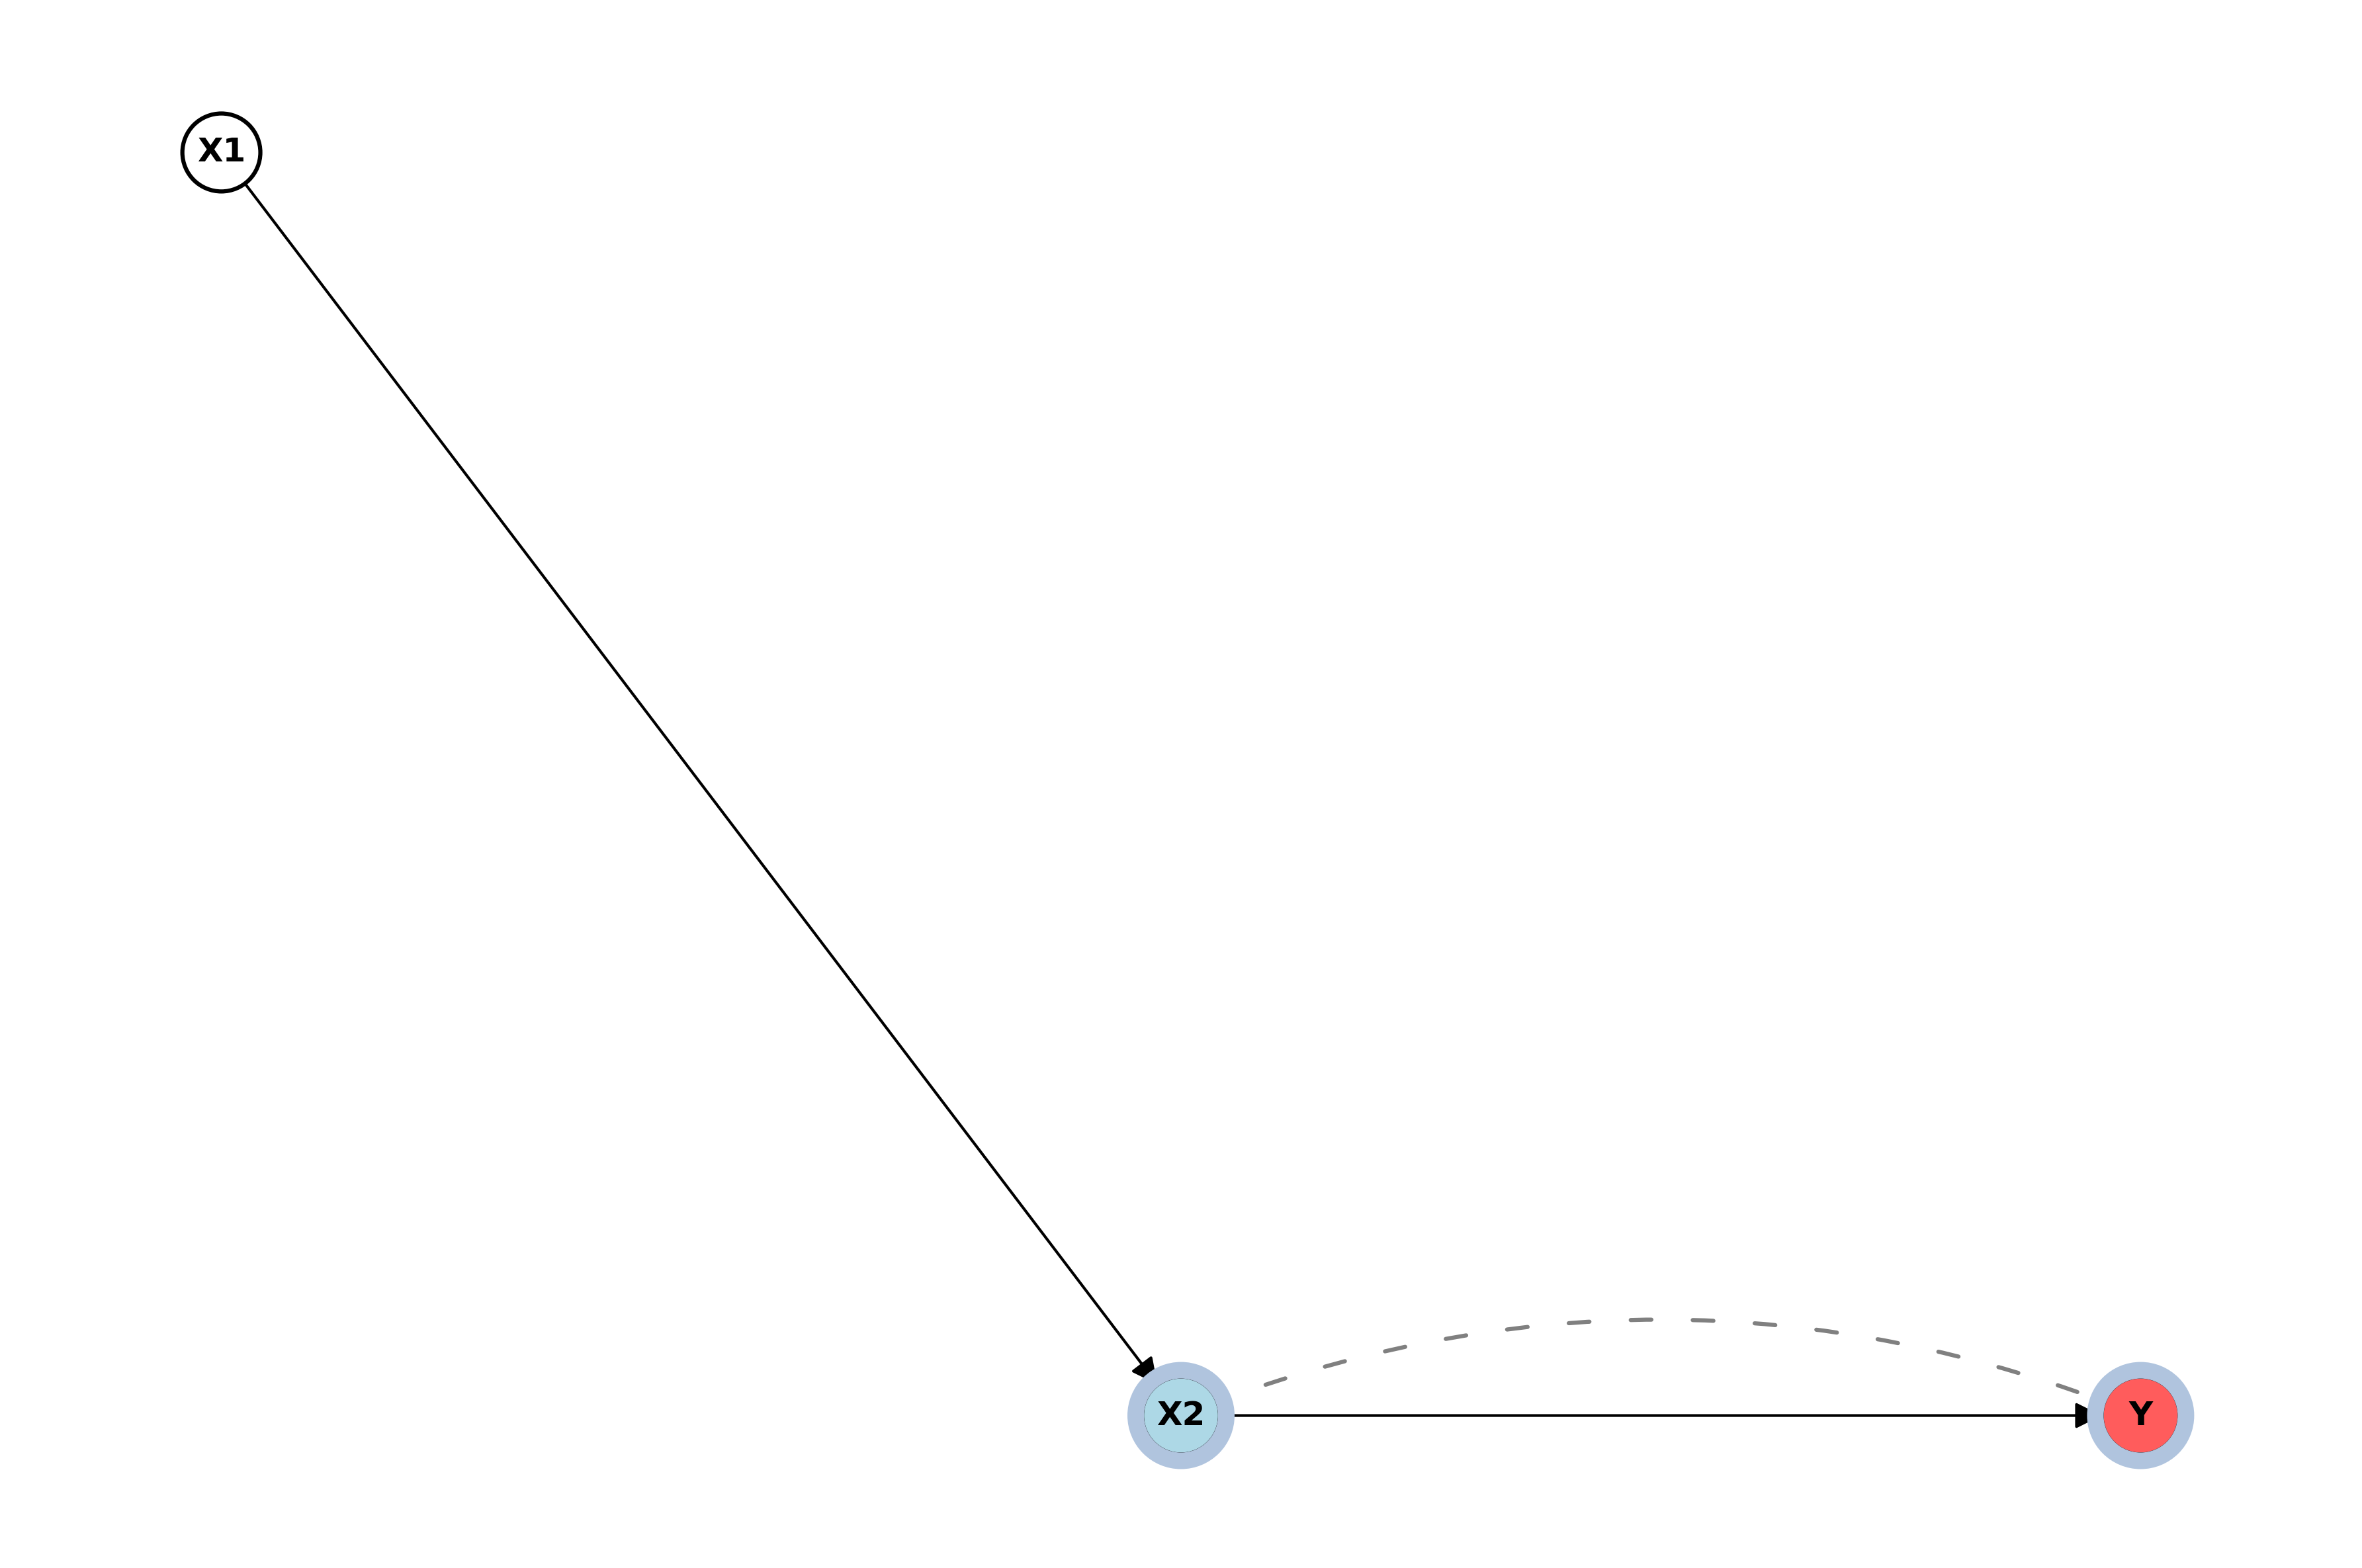

In [6]:
cdag.nx_viz(path = './test.png', pos=pos, node_color_map = {
                                 colors['MUCT']:flatten(task.MUCT(cdag, 'Y')),
                                 colors['target']:'Y'})[0]

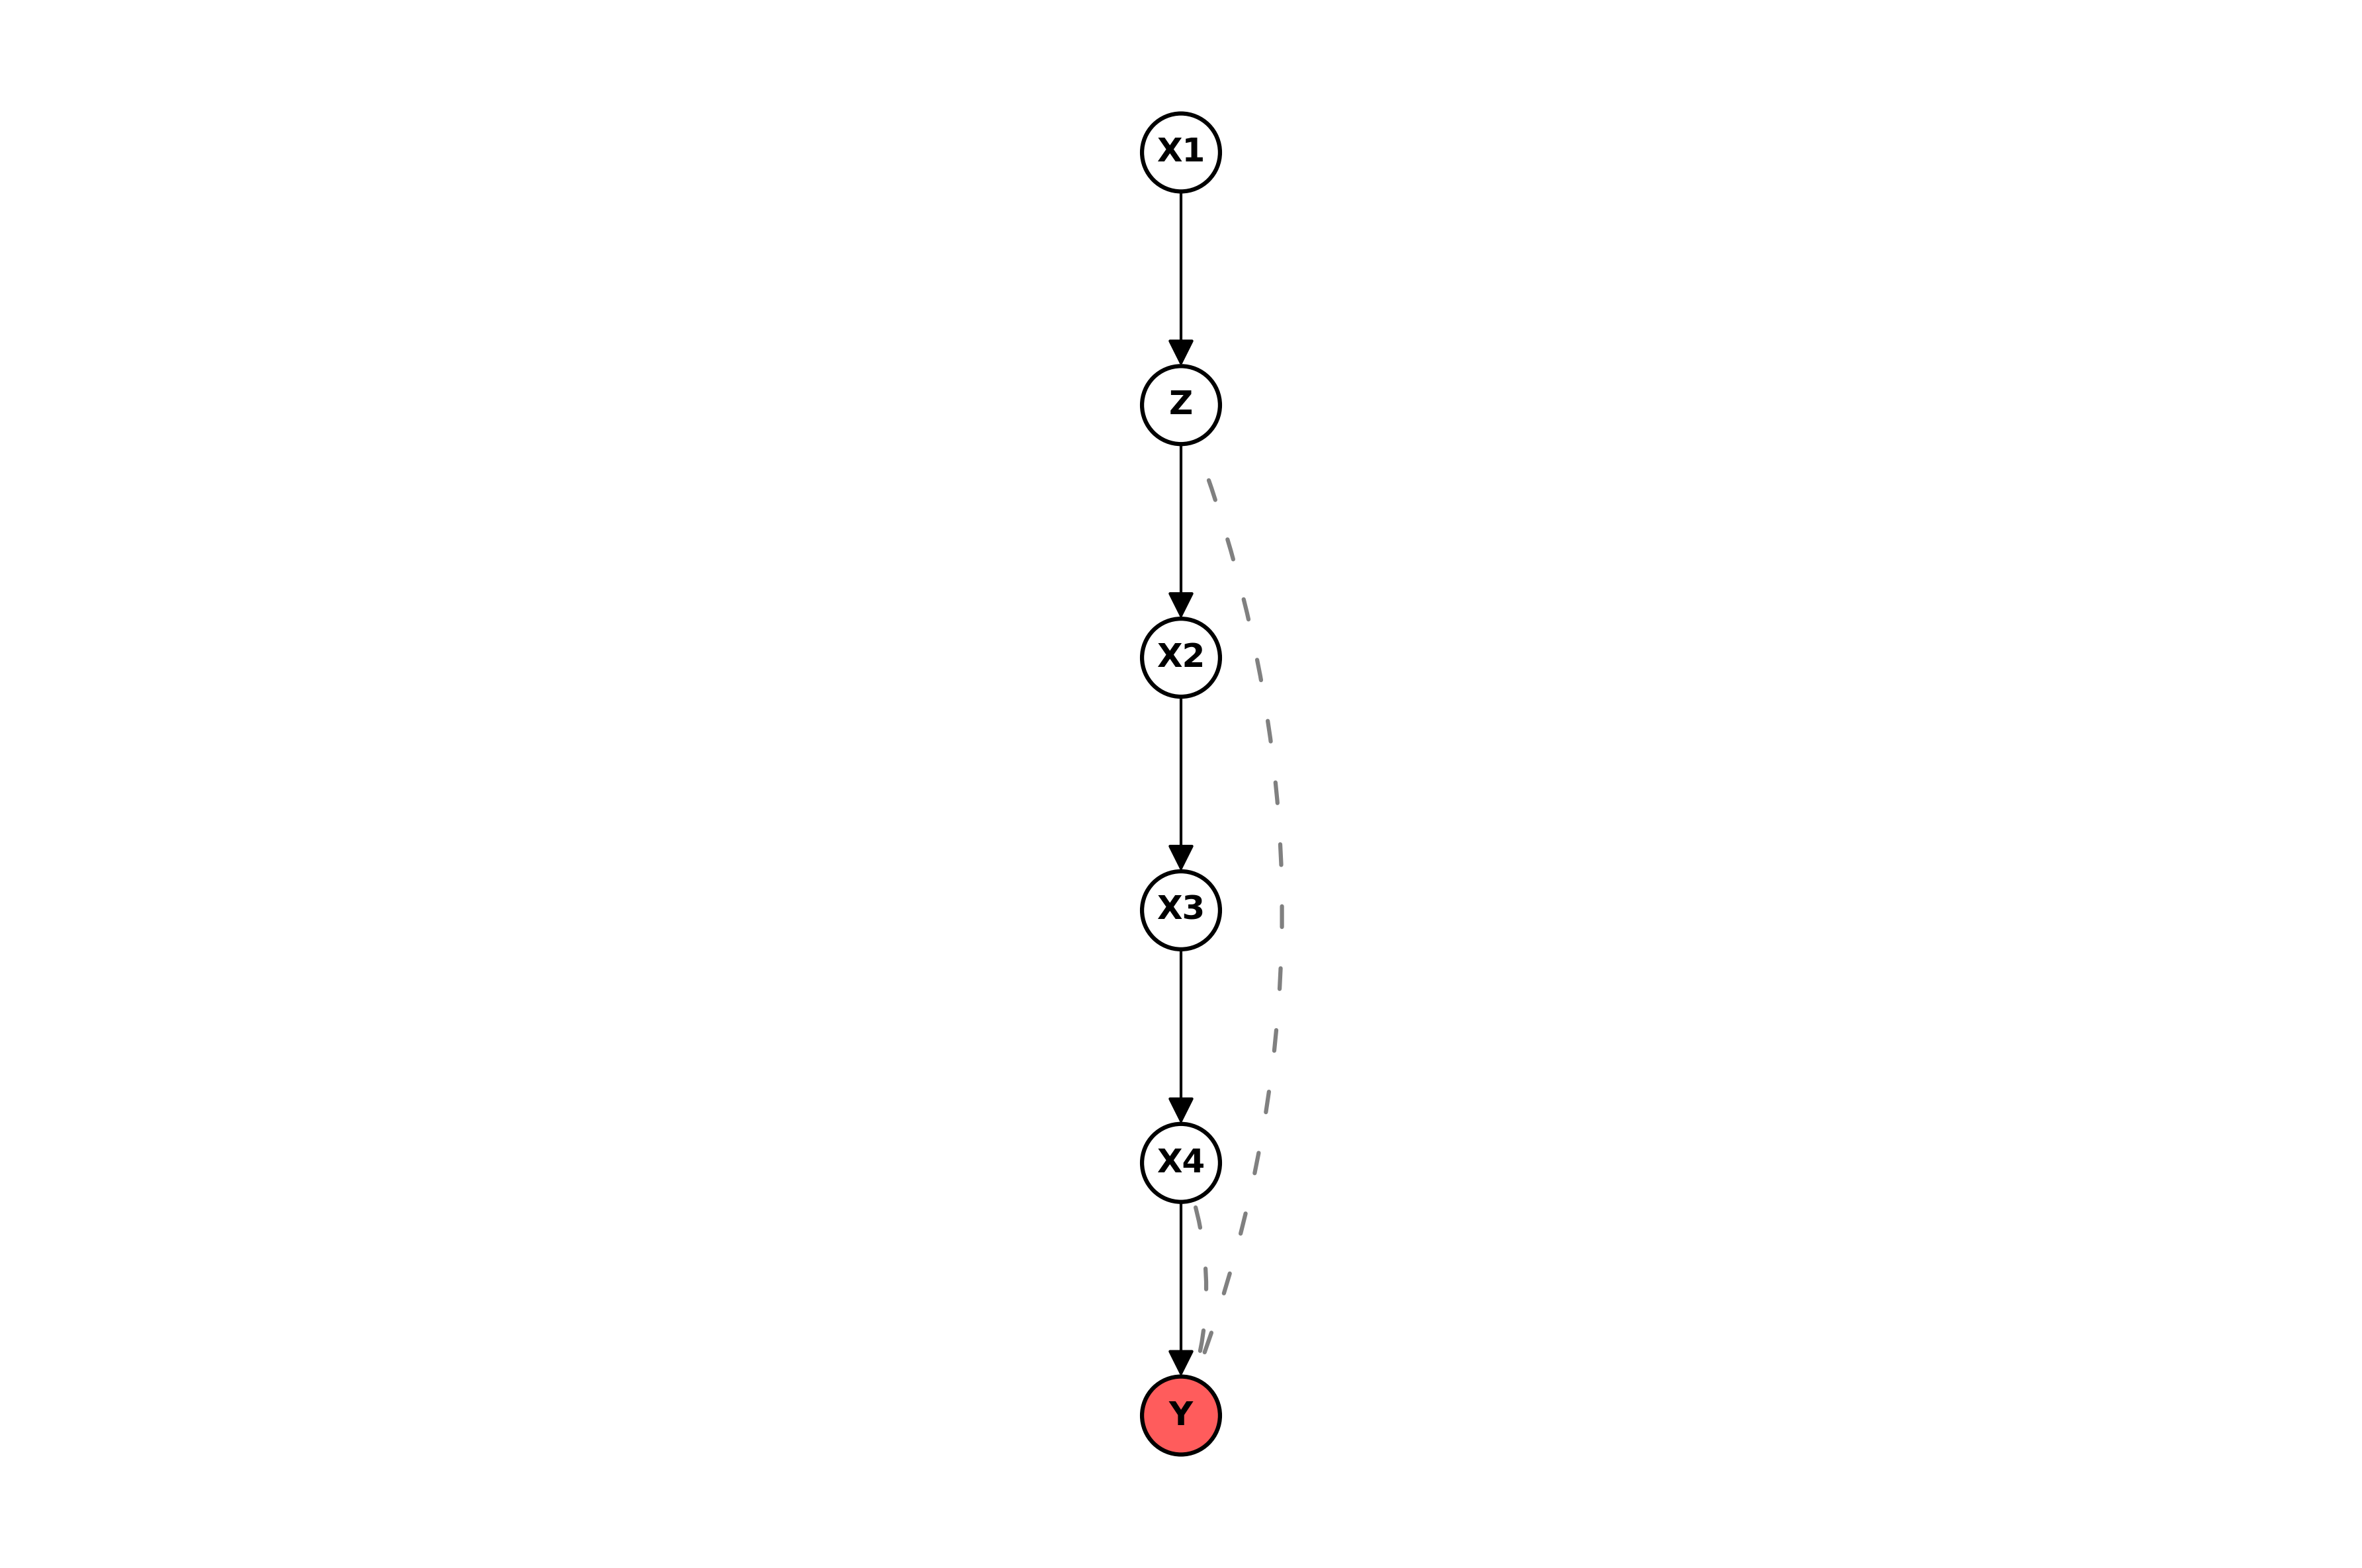

In [39]:
def fig_9_10_cdag():
    X1,X2,X3,X4,Z,Y = 'X1', 'X2', 'X3', 'X4', 'Z', 'Y'
    return CausalGraph({X1,X2,X3,X4,Z,Y}, [(X1, Z), (Z, X2), (X2, X3), (X3, X4), (X4, Y)], [(X4, Y, 'U_X4Y'), (Z, Y, 'U_ZY')])
cdag = fig_9_10_cdag()
pos = {
    'X1': (0,6),
    'Z': (0,5),
    'X2':(0,4),
    'X3':(0,3),
    'X4':(0,2),
    'Y':(0,1)
    }

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        # colors['intervention']: do_vars,                      # Intervention Variable
    }
)[0]

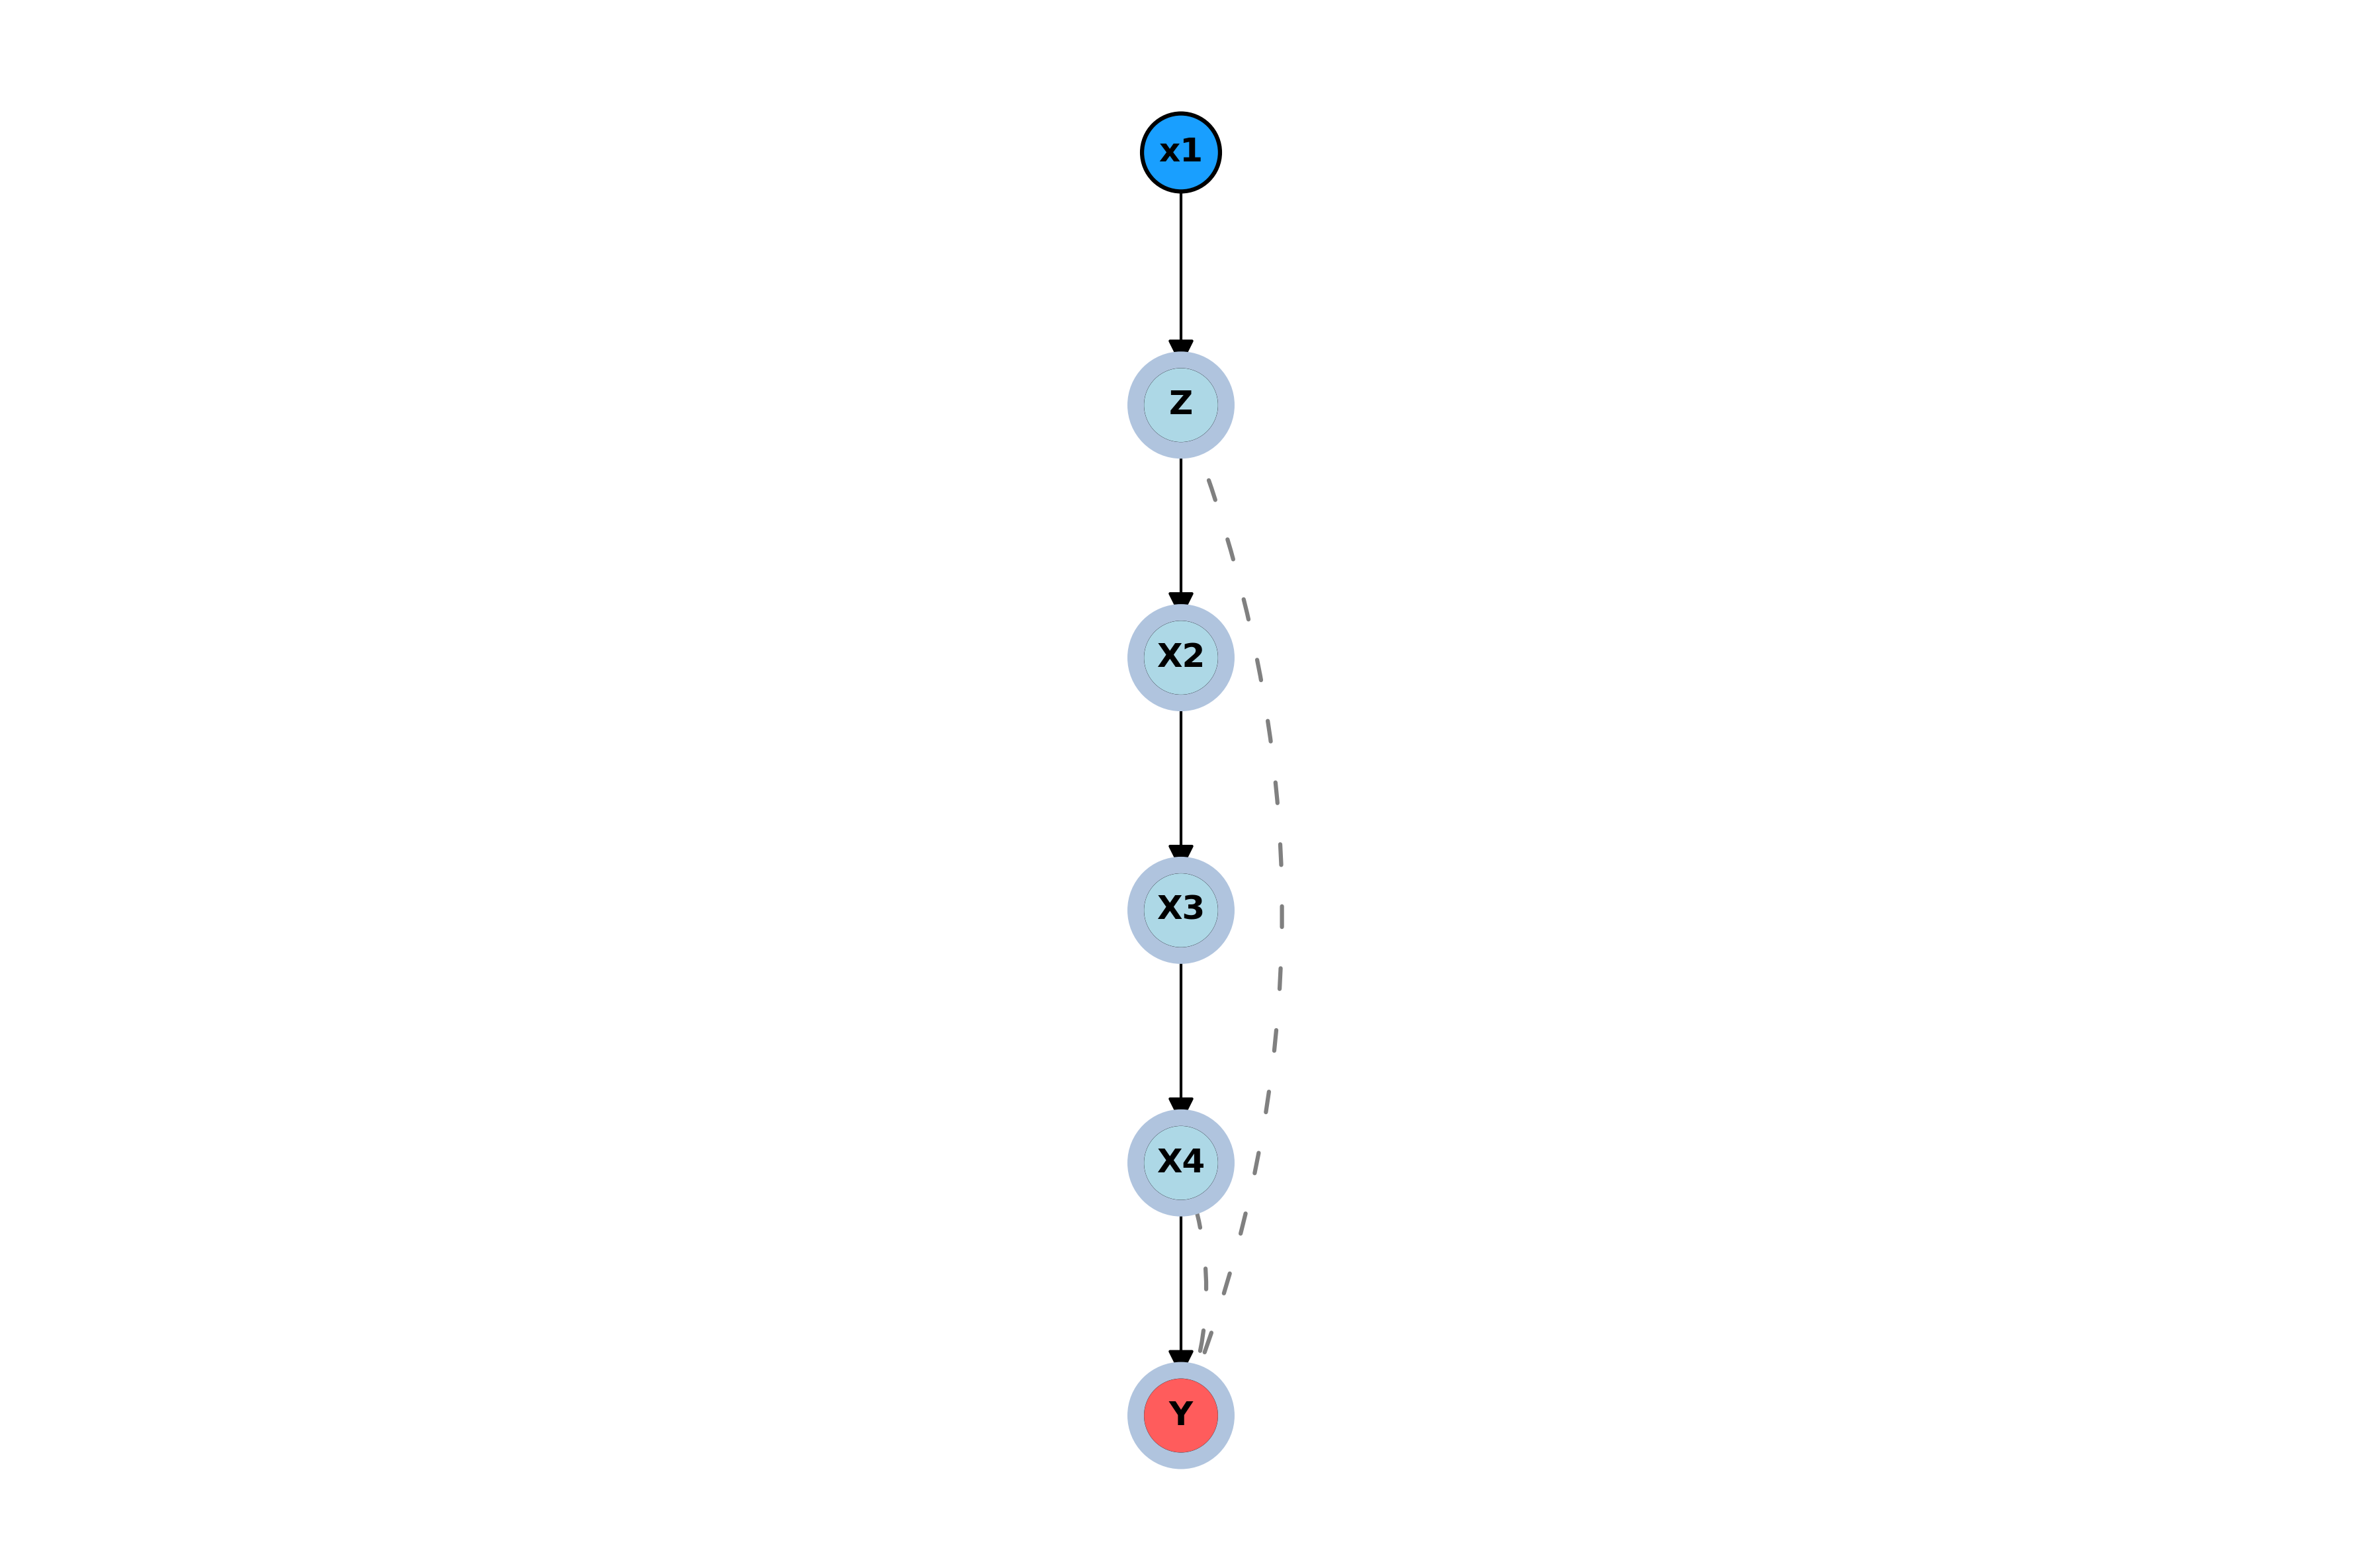

In [40]:
do_vars = {'x1'}
def fig_9_10_cdag():
    X1,X2,X3,X4,Z,Y = 'x1', 'X2', 'X3', 'X4', 'Z', 'Y'
    return CausalGraph({X1,X2,X3,X4,Z,Y}, [(X1, Z), (Z, X2), (X2, X3), (X3, X4), (X4, Y)], [(X4, Y, 'U_X4Y'), (Z, Y, 'U_ZY')])
cdag = fig_9_10_cdag().do(do_vars)
pos = {
    'x1': (0,6),
    'Z': (0,5),
    'X2':(0,4),
    'X3':(0,3),
    'X4':(0,2),
    'Y':(0,1)
    }

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: do_vars,                      # Intervention Variable
    }
)[0]

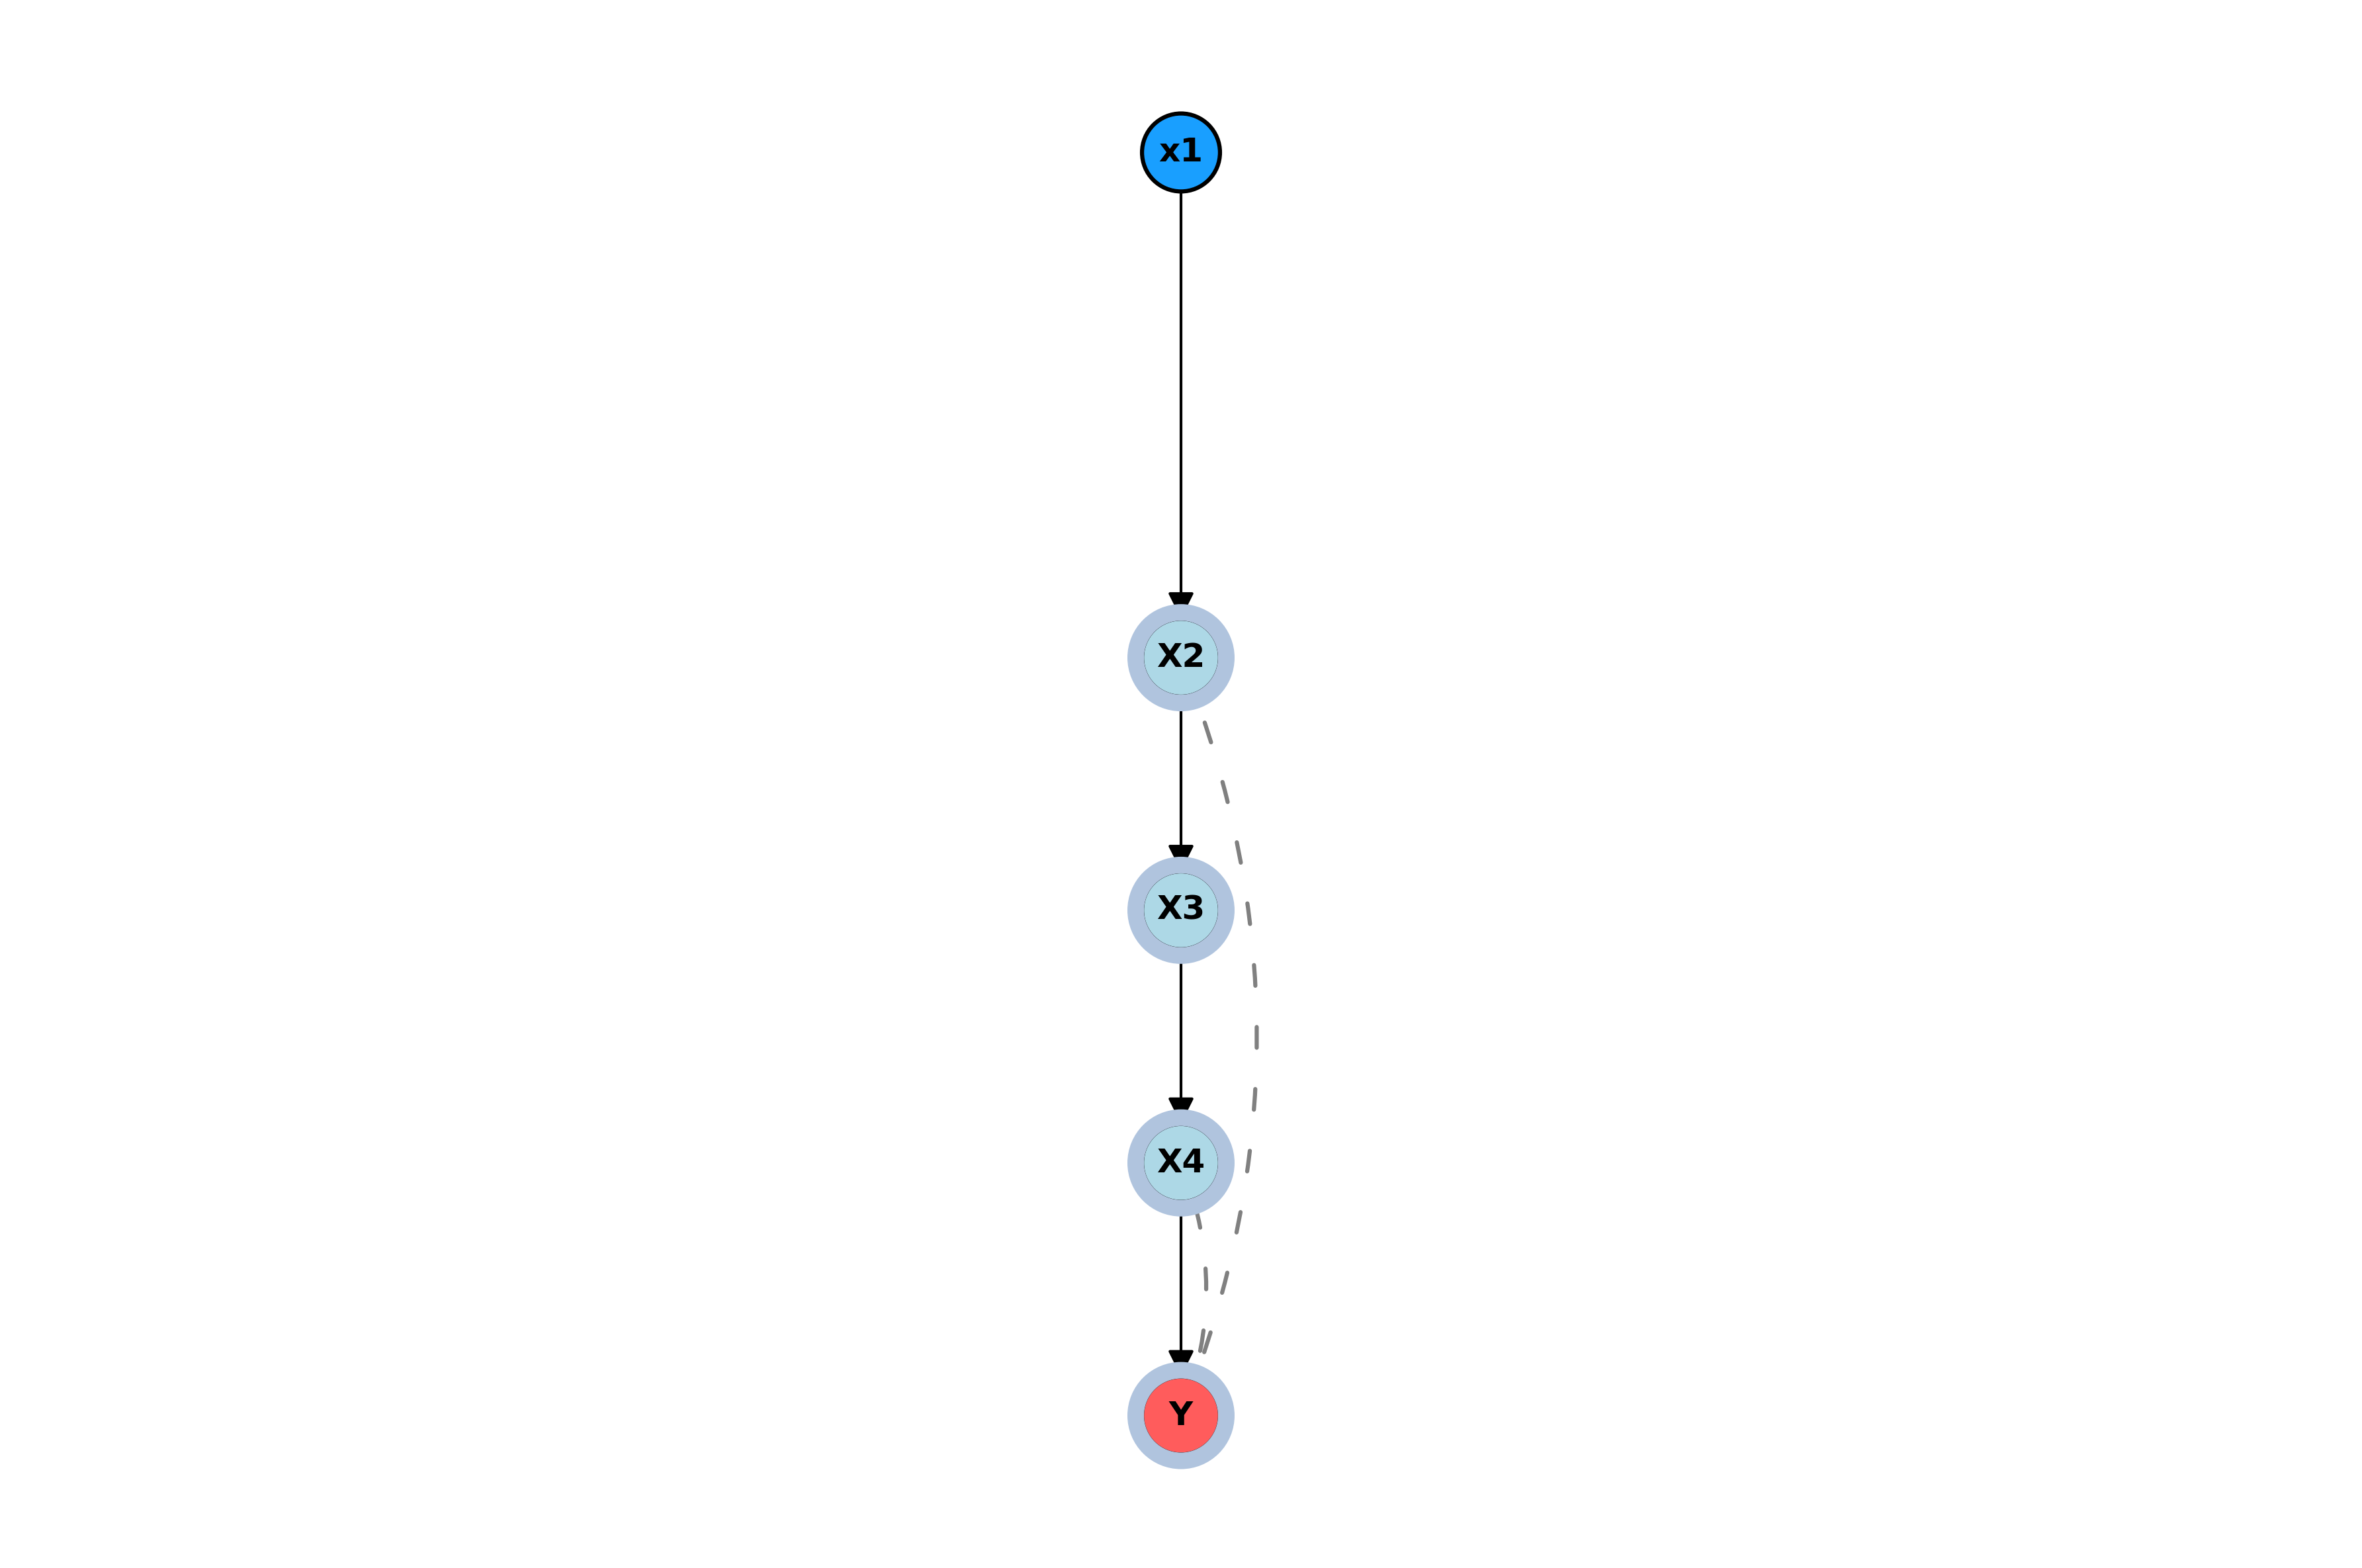

In [46]:
do_vars = {'x1'}
def fig_9_10_cdag():
    X1,X2,X3,X4,Y = 'x1', 'X2', 'X3', 'X4', 'Y'
    return CausalGraph({X1,X2,X3,X4,Y}, [(X1, X2), (X2, X3), (X3, X4), (X4, Y)], [(X4, Y, 'U_X4Y'), (X2, Y, 'U_X2Y')])
cdag = fig_9_10_cdag().do(do_vars).induced({'x1','X2','X3','X4','Y'})
pos = {
    'x1': (0,6),
    'Z': (0,5),
    'X2':(0,4),
    'X3':(0,3),
    'X4':(0,2),
    'Y':(0,1)
    }

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: do_vars,                      # Intervention Variable
    }
)[0]

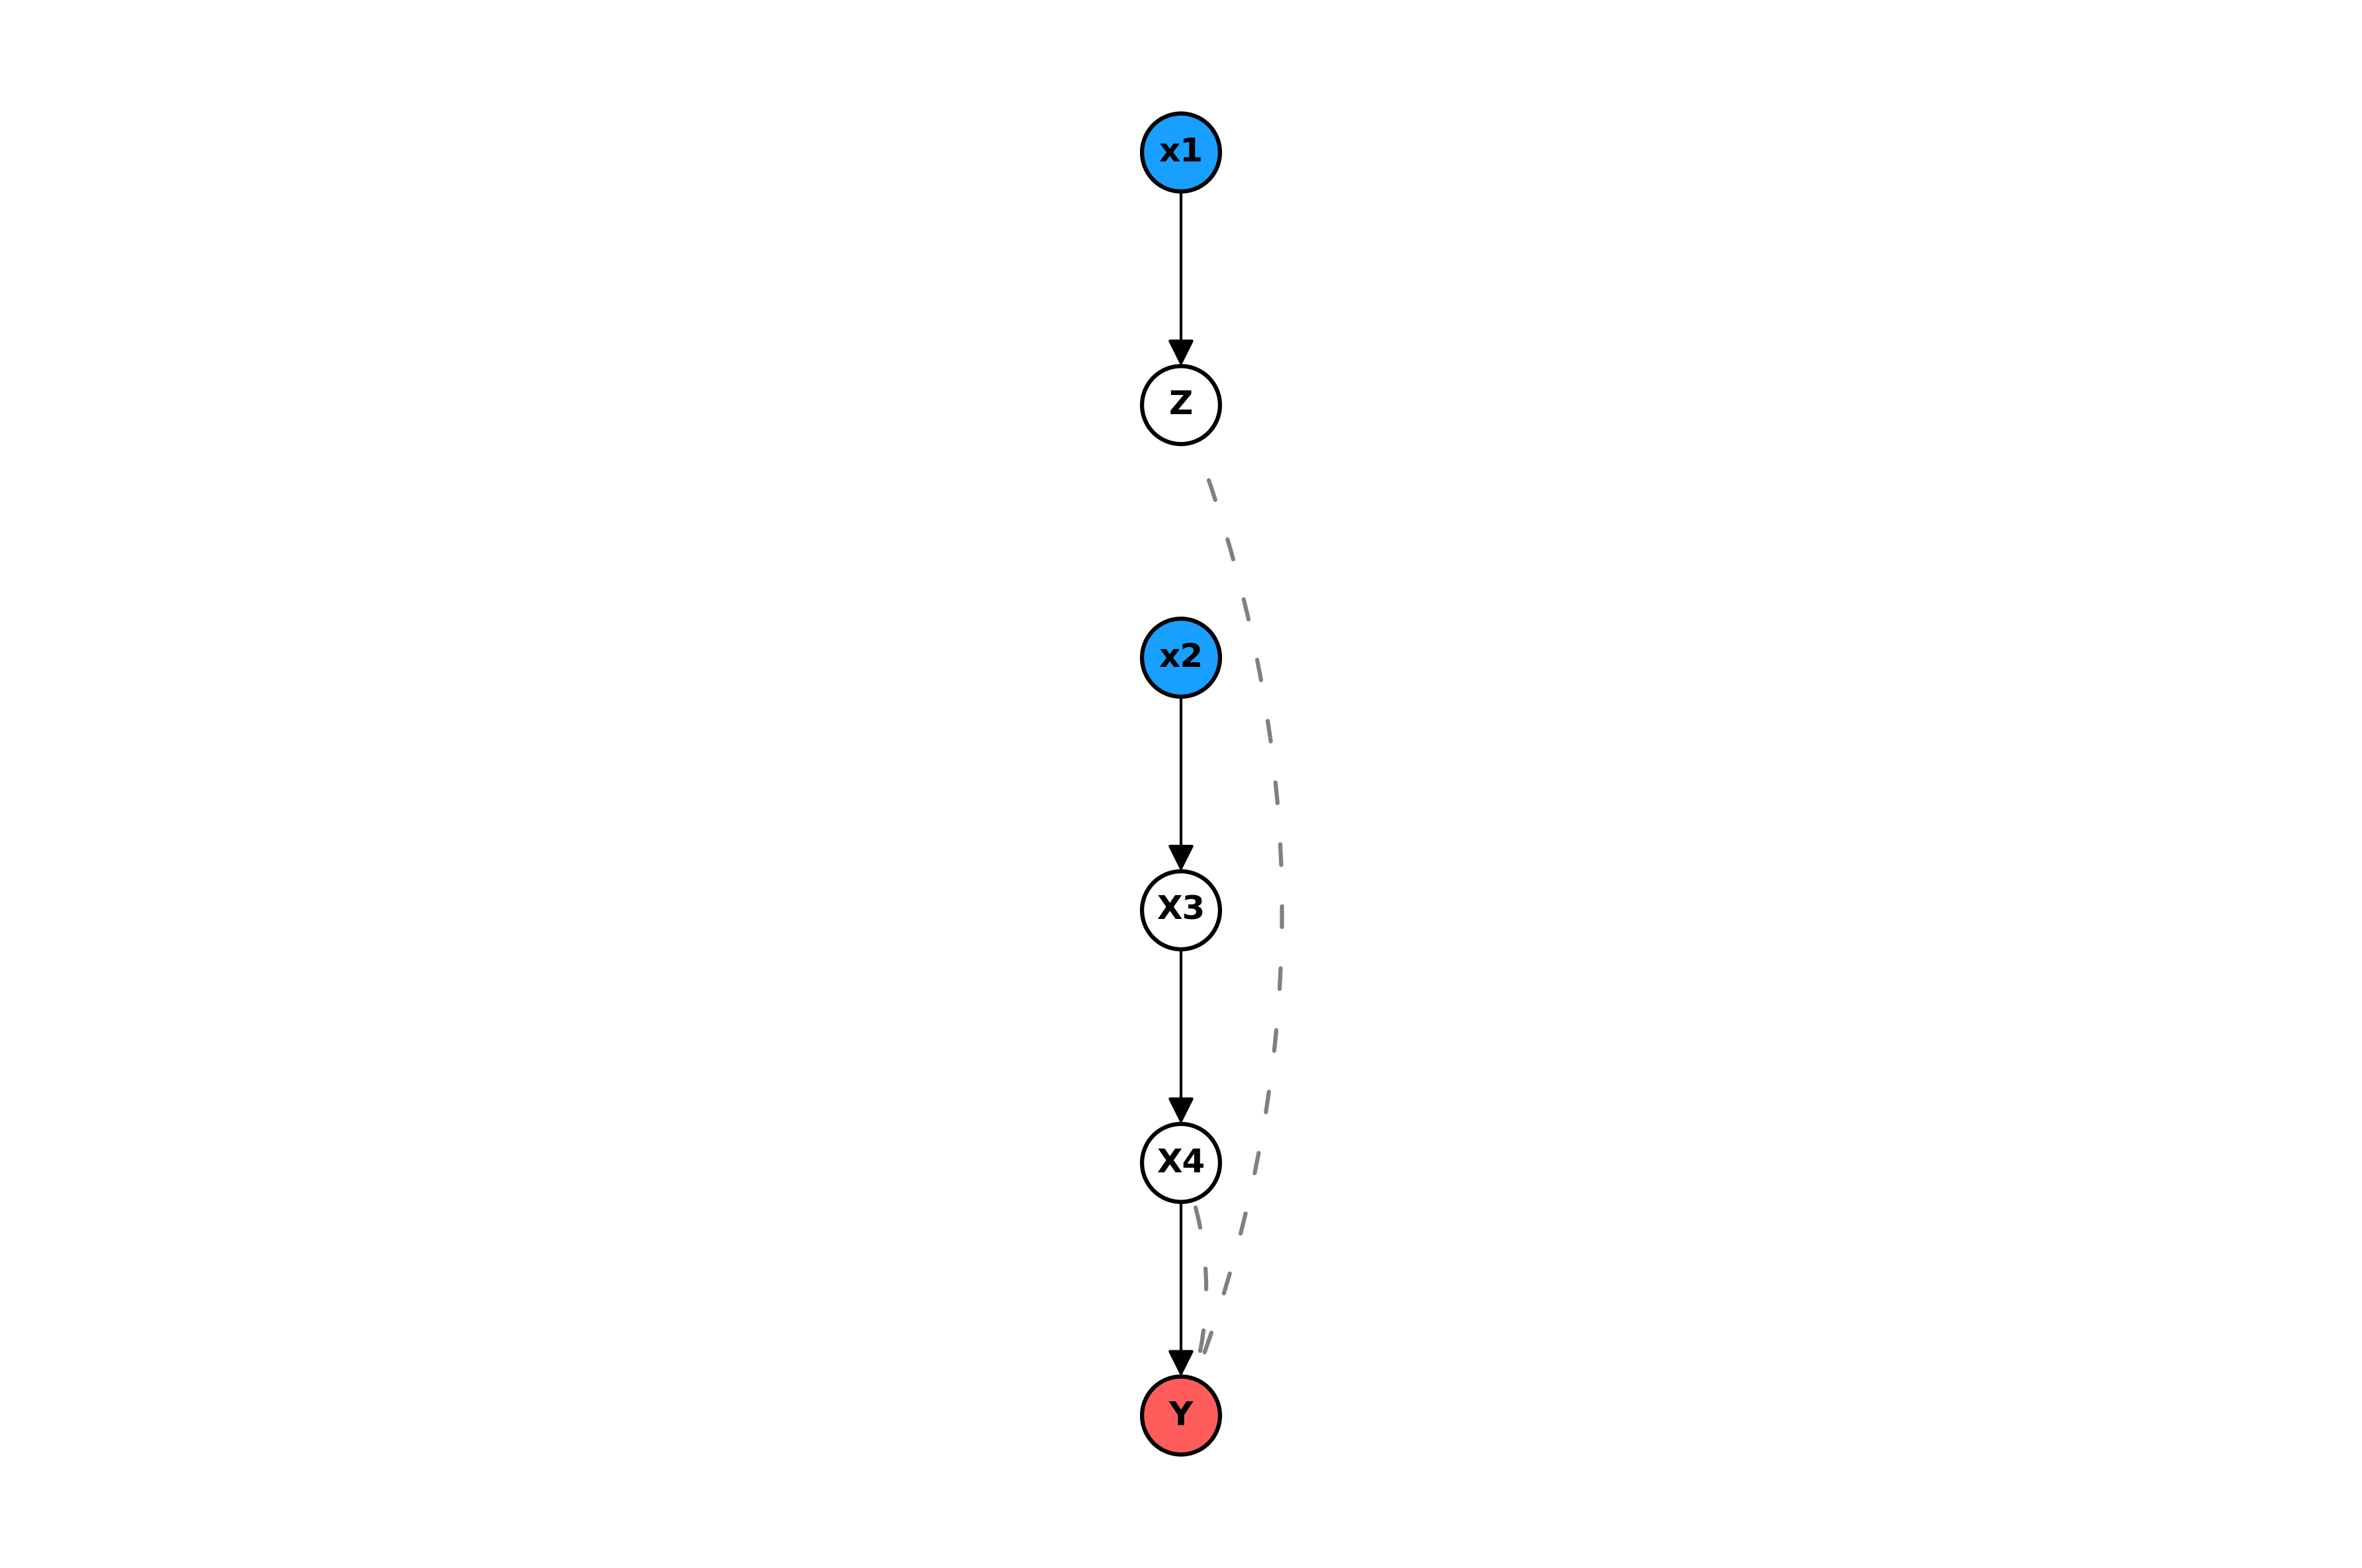

In [47]:
do_vars = {'x1','x2'}
def fig_9_10_cdag():
    X1,X2,X3,X4,Z,Y = 'x1', 'x2', 'X3', 'X4', 'Z', 'Y'
    return CausalGraph({X1,X2,X3,X4,Z,Y}, [(X1, Z), (Z, X2), (X2, X3), (X3, X4), (X4, Y)], [(X4, Y, 'U_X4Y'), (Z, Y, 'U_ZY')])
cdag = fig_9_10_cdag().do(do_vars)
pos = {
    'x1': (0,6),
    'Z': (0,5),
    'x2':(0,4),
    'X3':(0,3),
    'X4':(0,2),
    'Y':(0,1)
    }

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: do_vars,                      # Intervention Variable
    }
)[0]

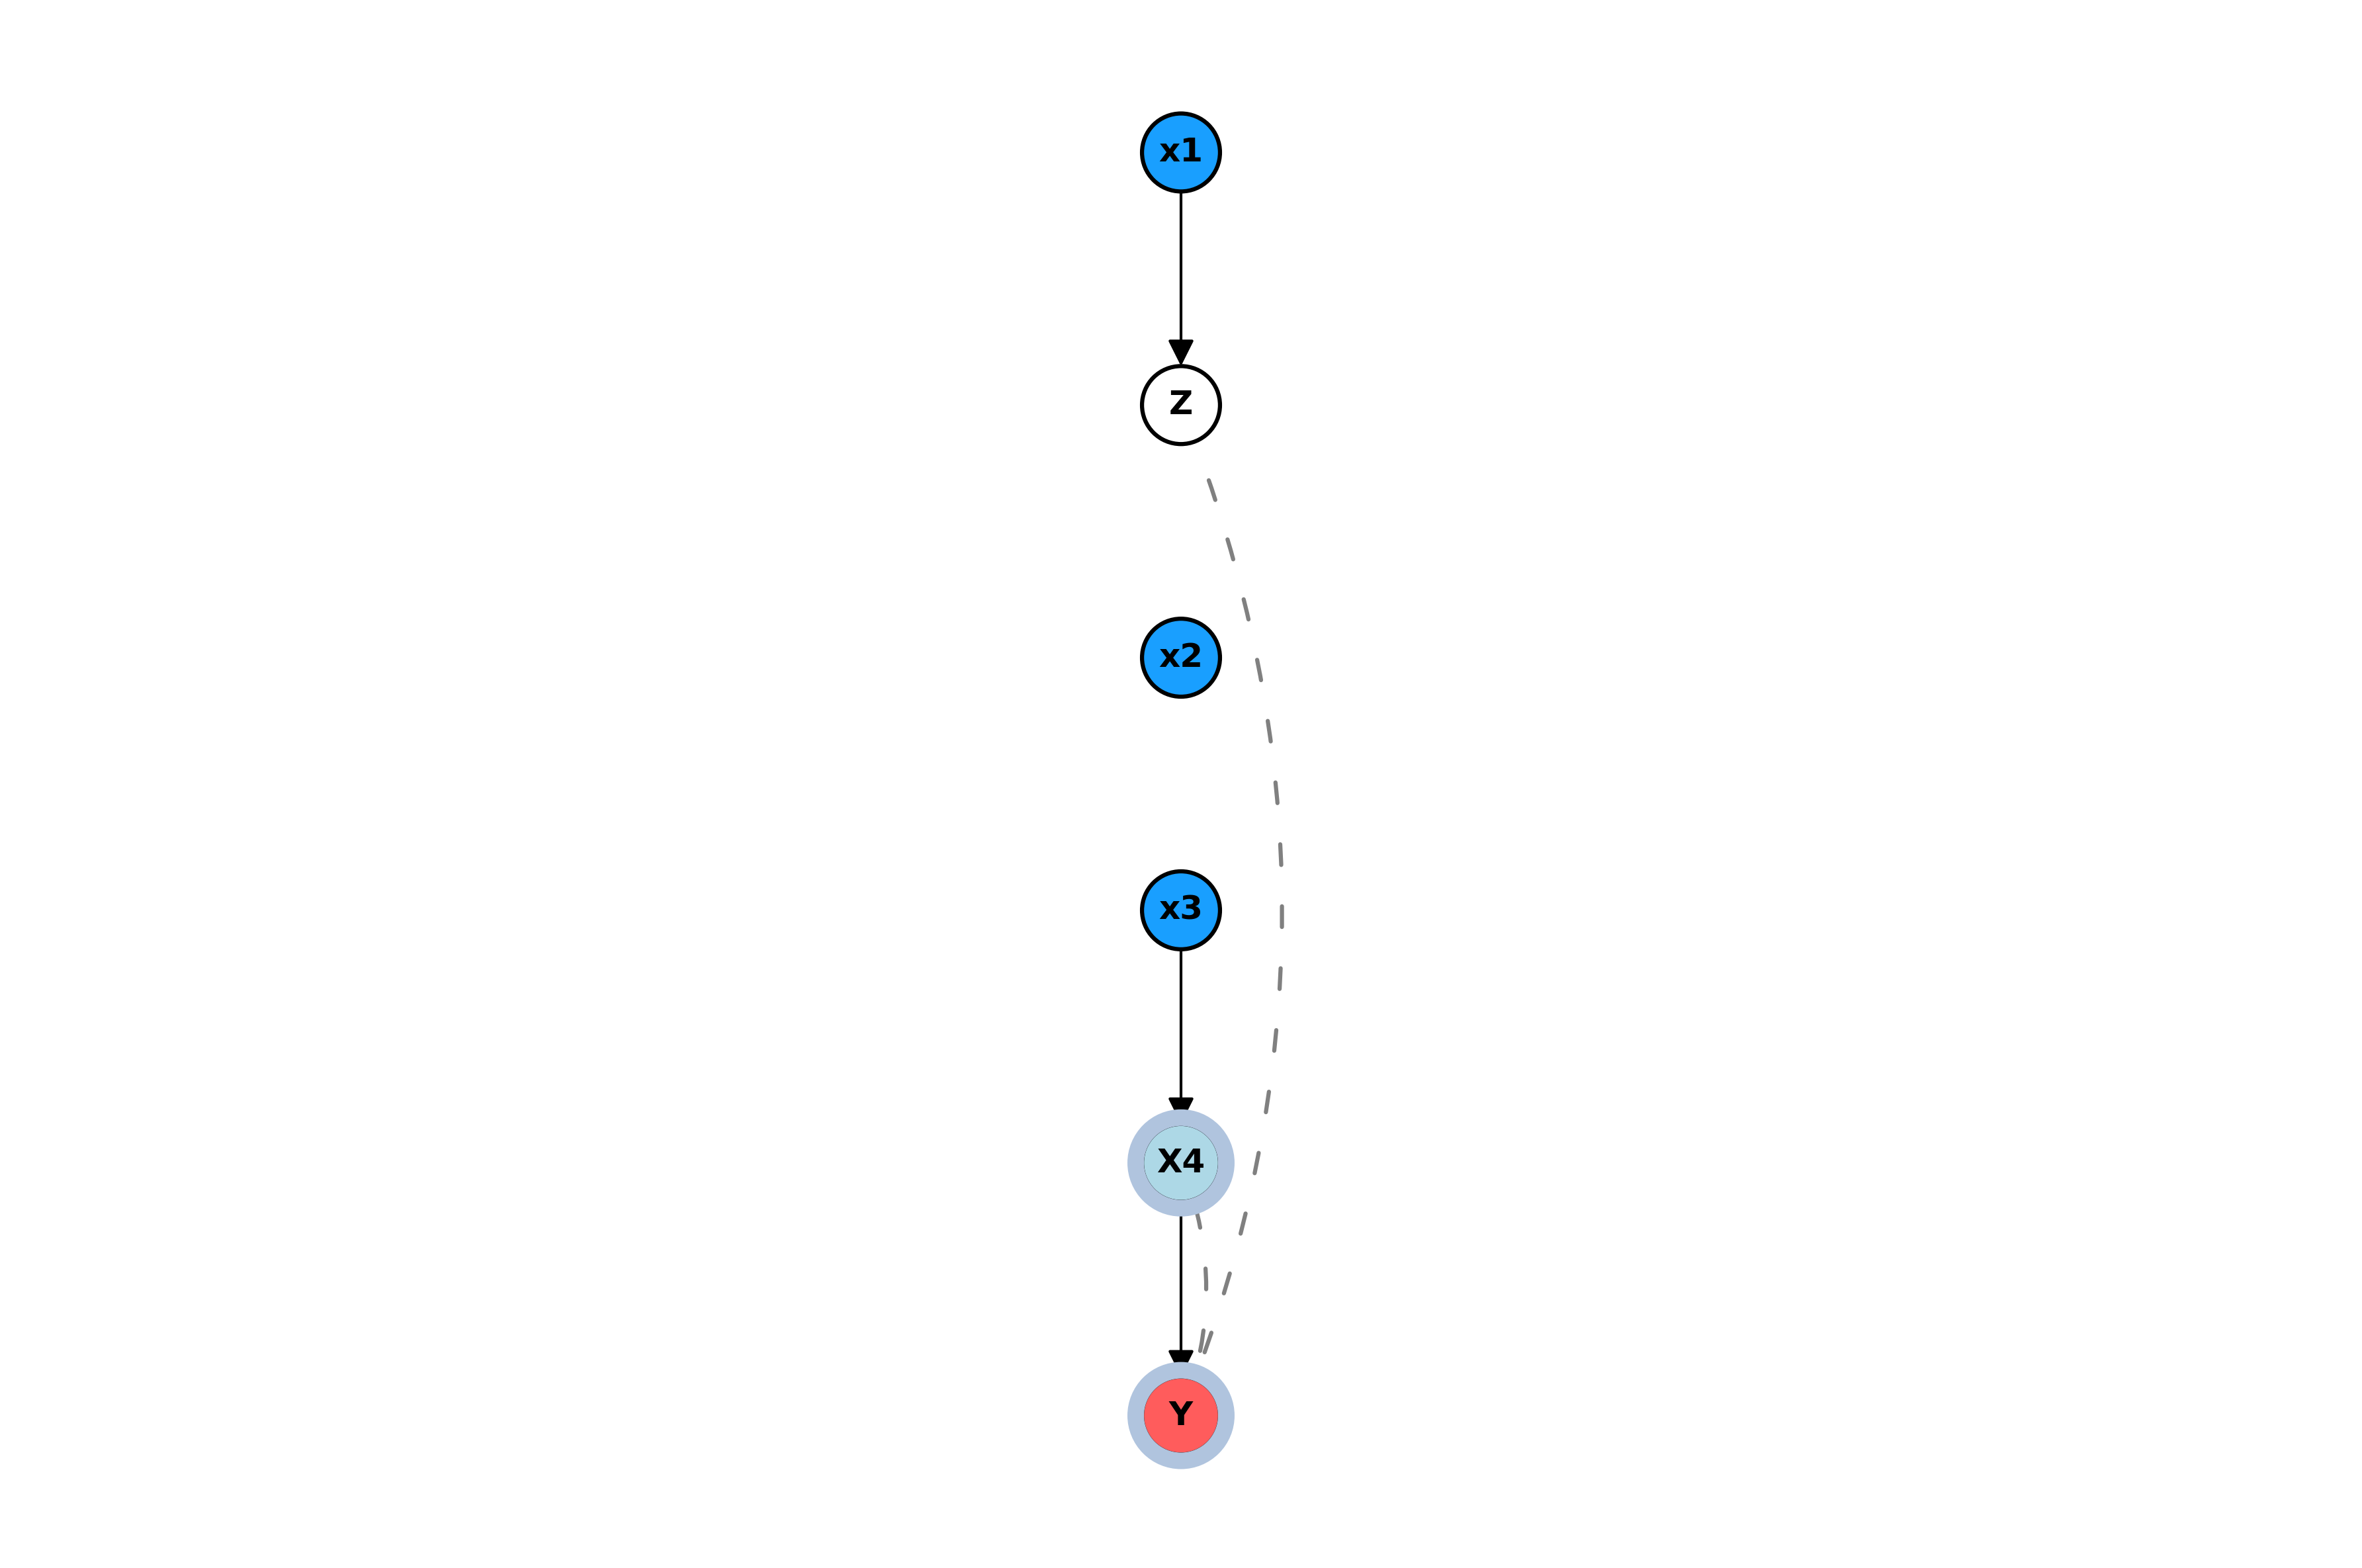

In [48]:
do_vars = {'x1','x2','x3'}
def fig_9_10_cdag():
    X1,X2,X3,X4,Z,Y = 'x1', 'x2', 'x3', 'X4', 'Z', 'Y'
    return CausalGraph({X1,X2,X3,X4,Z,Y}, [(X1, Z), (Z, X2), (X2, X3), (X3, X4), (X4, Y)], [(X4, Y, 'U_X4Y'), (Z, Y, 'U_ZY')])
cdag = fig_9_10_cdag().do(do_vars)
pos = {
    'x1': (0,6),
    'Z': (0,5),
    'x2':(0,4),
    'x3':(0,3),
    'X4':(0,2),
    'Y':(0,1)
    }

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: do_vars,                      # Intervention Variable
    }
)[0]

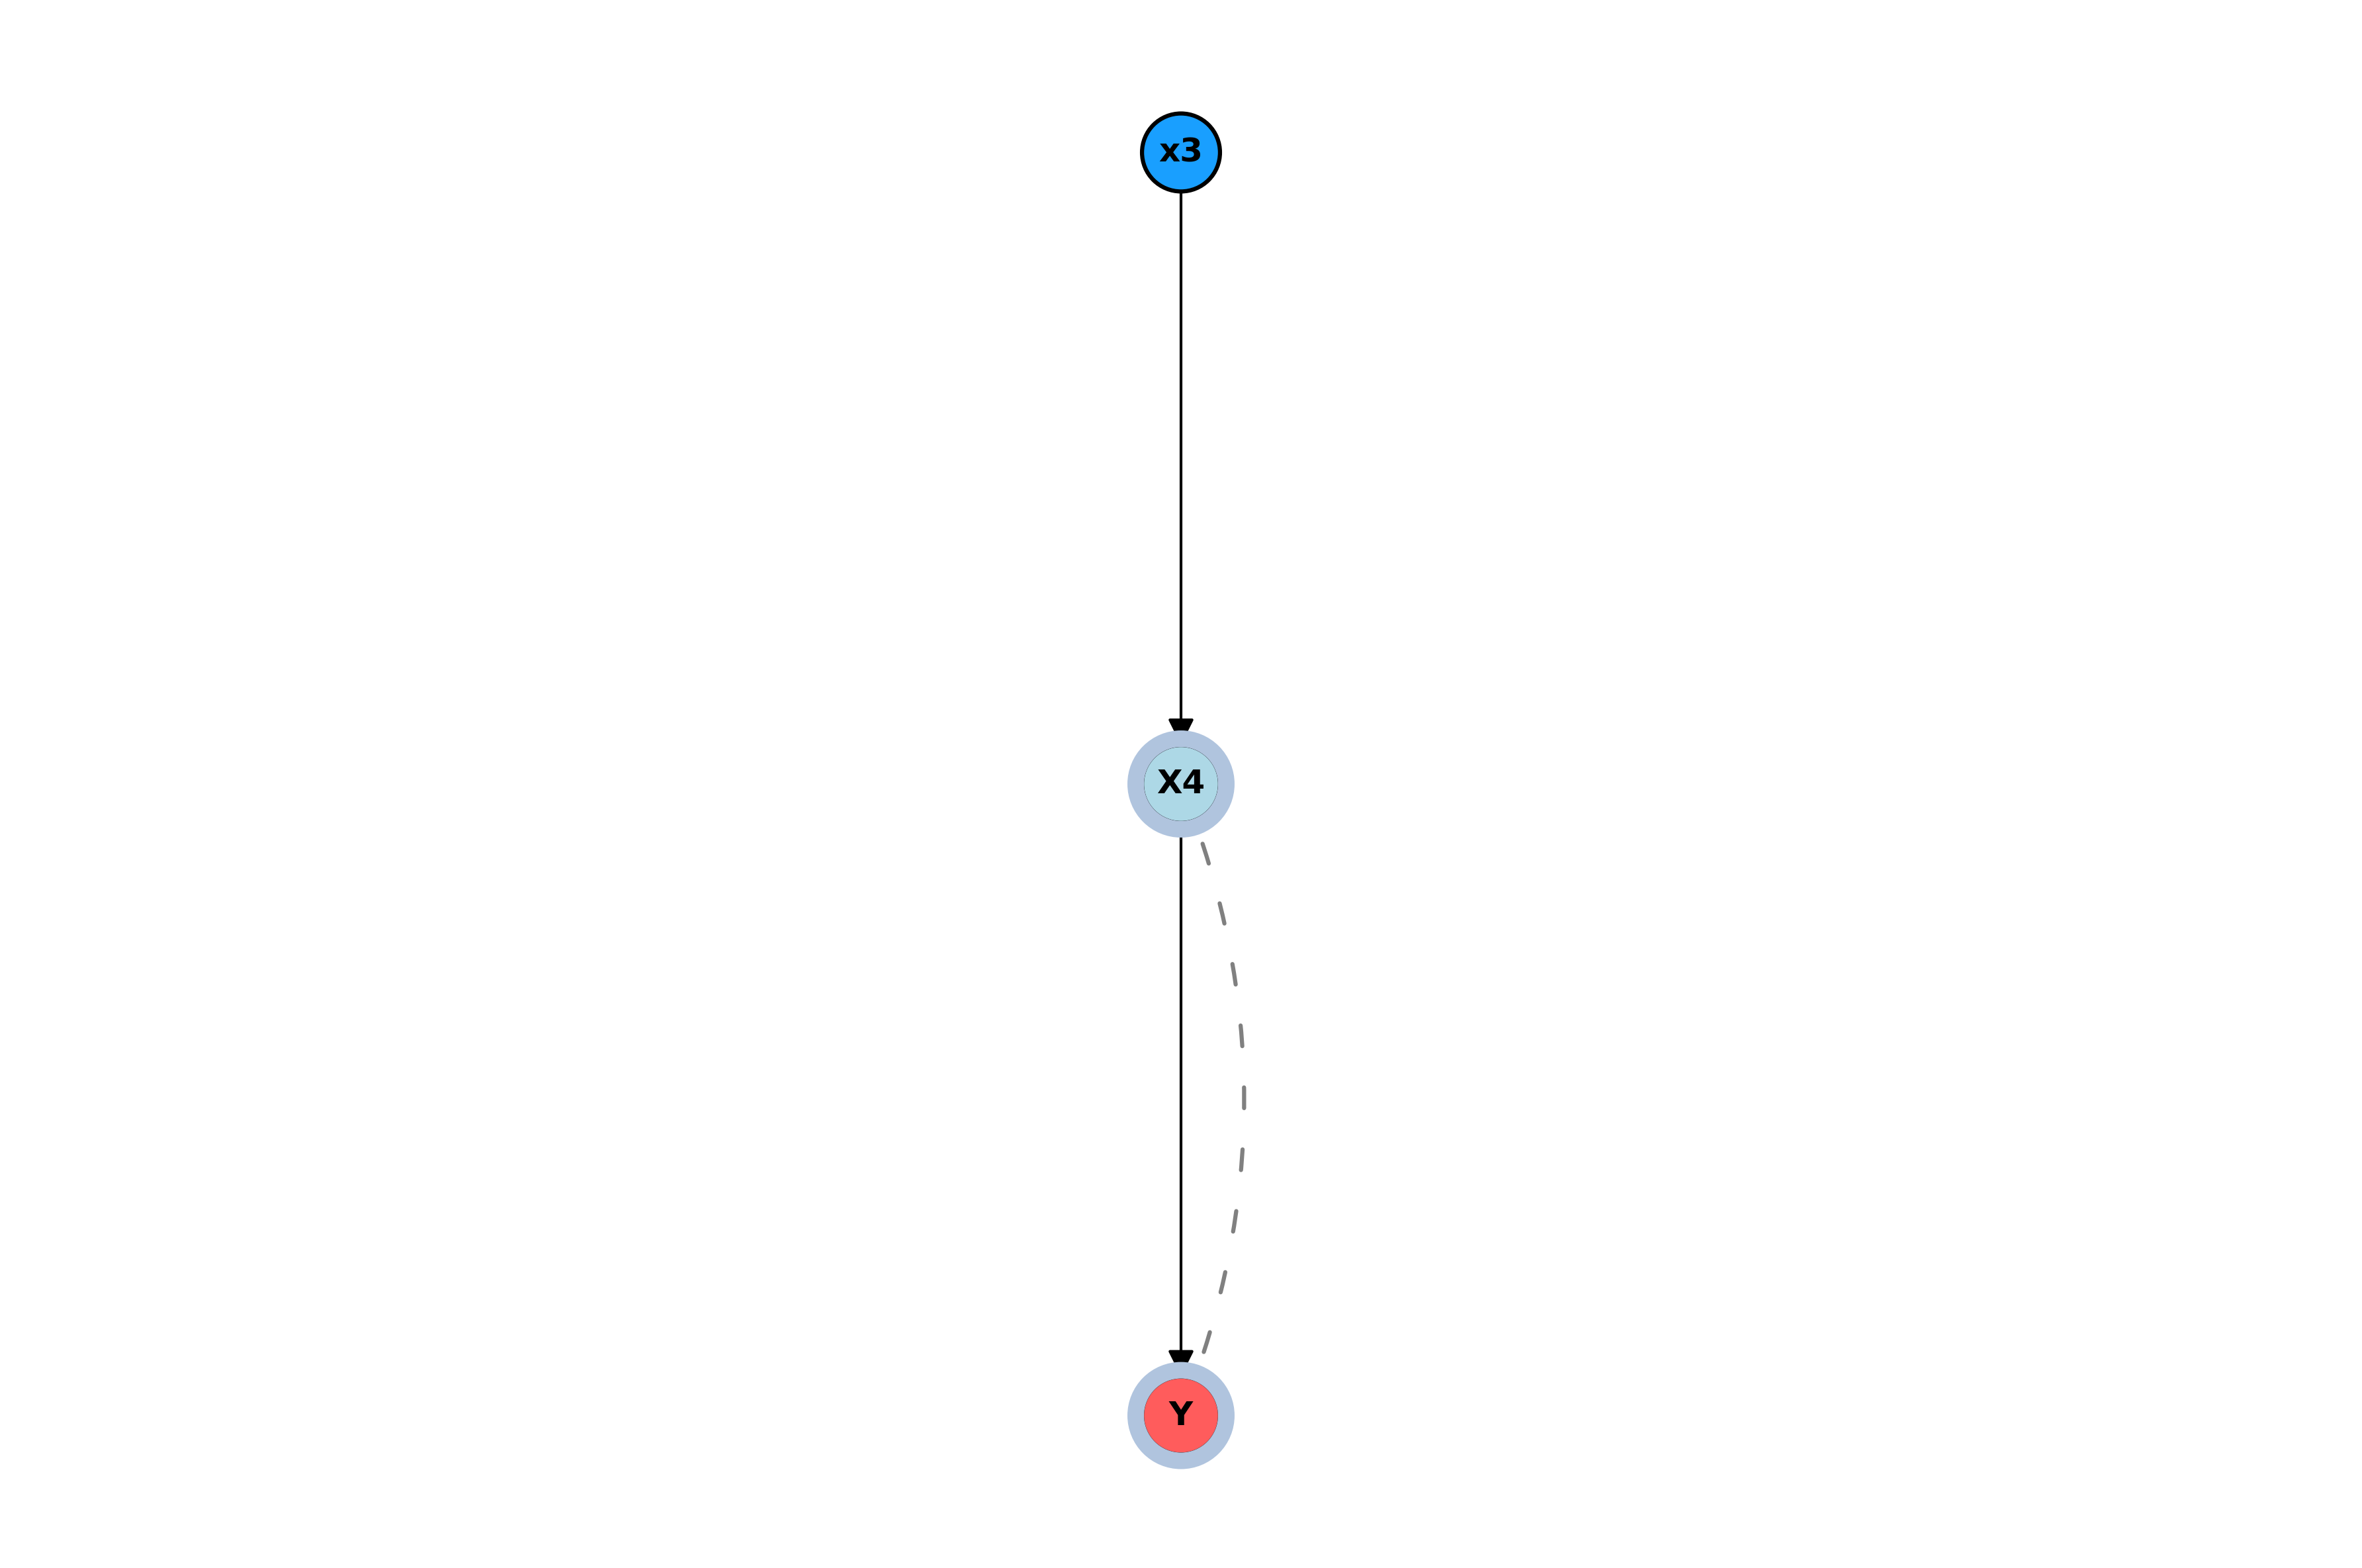

In [ ]:
induced_vars = {'x3', 'X4', 'Y'}
do_vars = {'x3'}

cdag = fig_9_10_cdag().induced(induced_vars).do(do_vars)
pos = {
    'X1': (0,6),
    'Z': (0,5),
    'X2':(0,4),
    'x3':(0,3),
    'X4':(0,2),
    'Y':(0,1)
    }

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: do_vars,                      # Intervention Variable
    }
)[0]

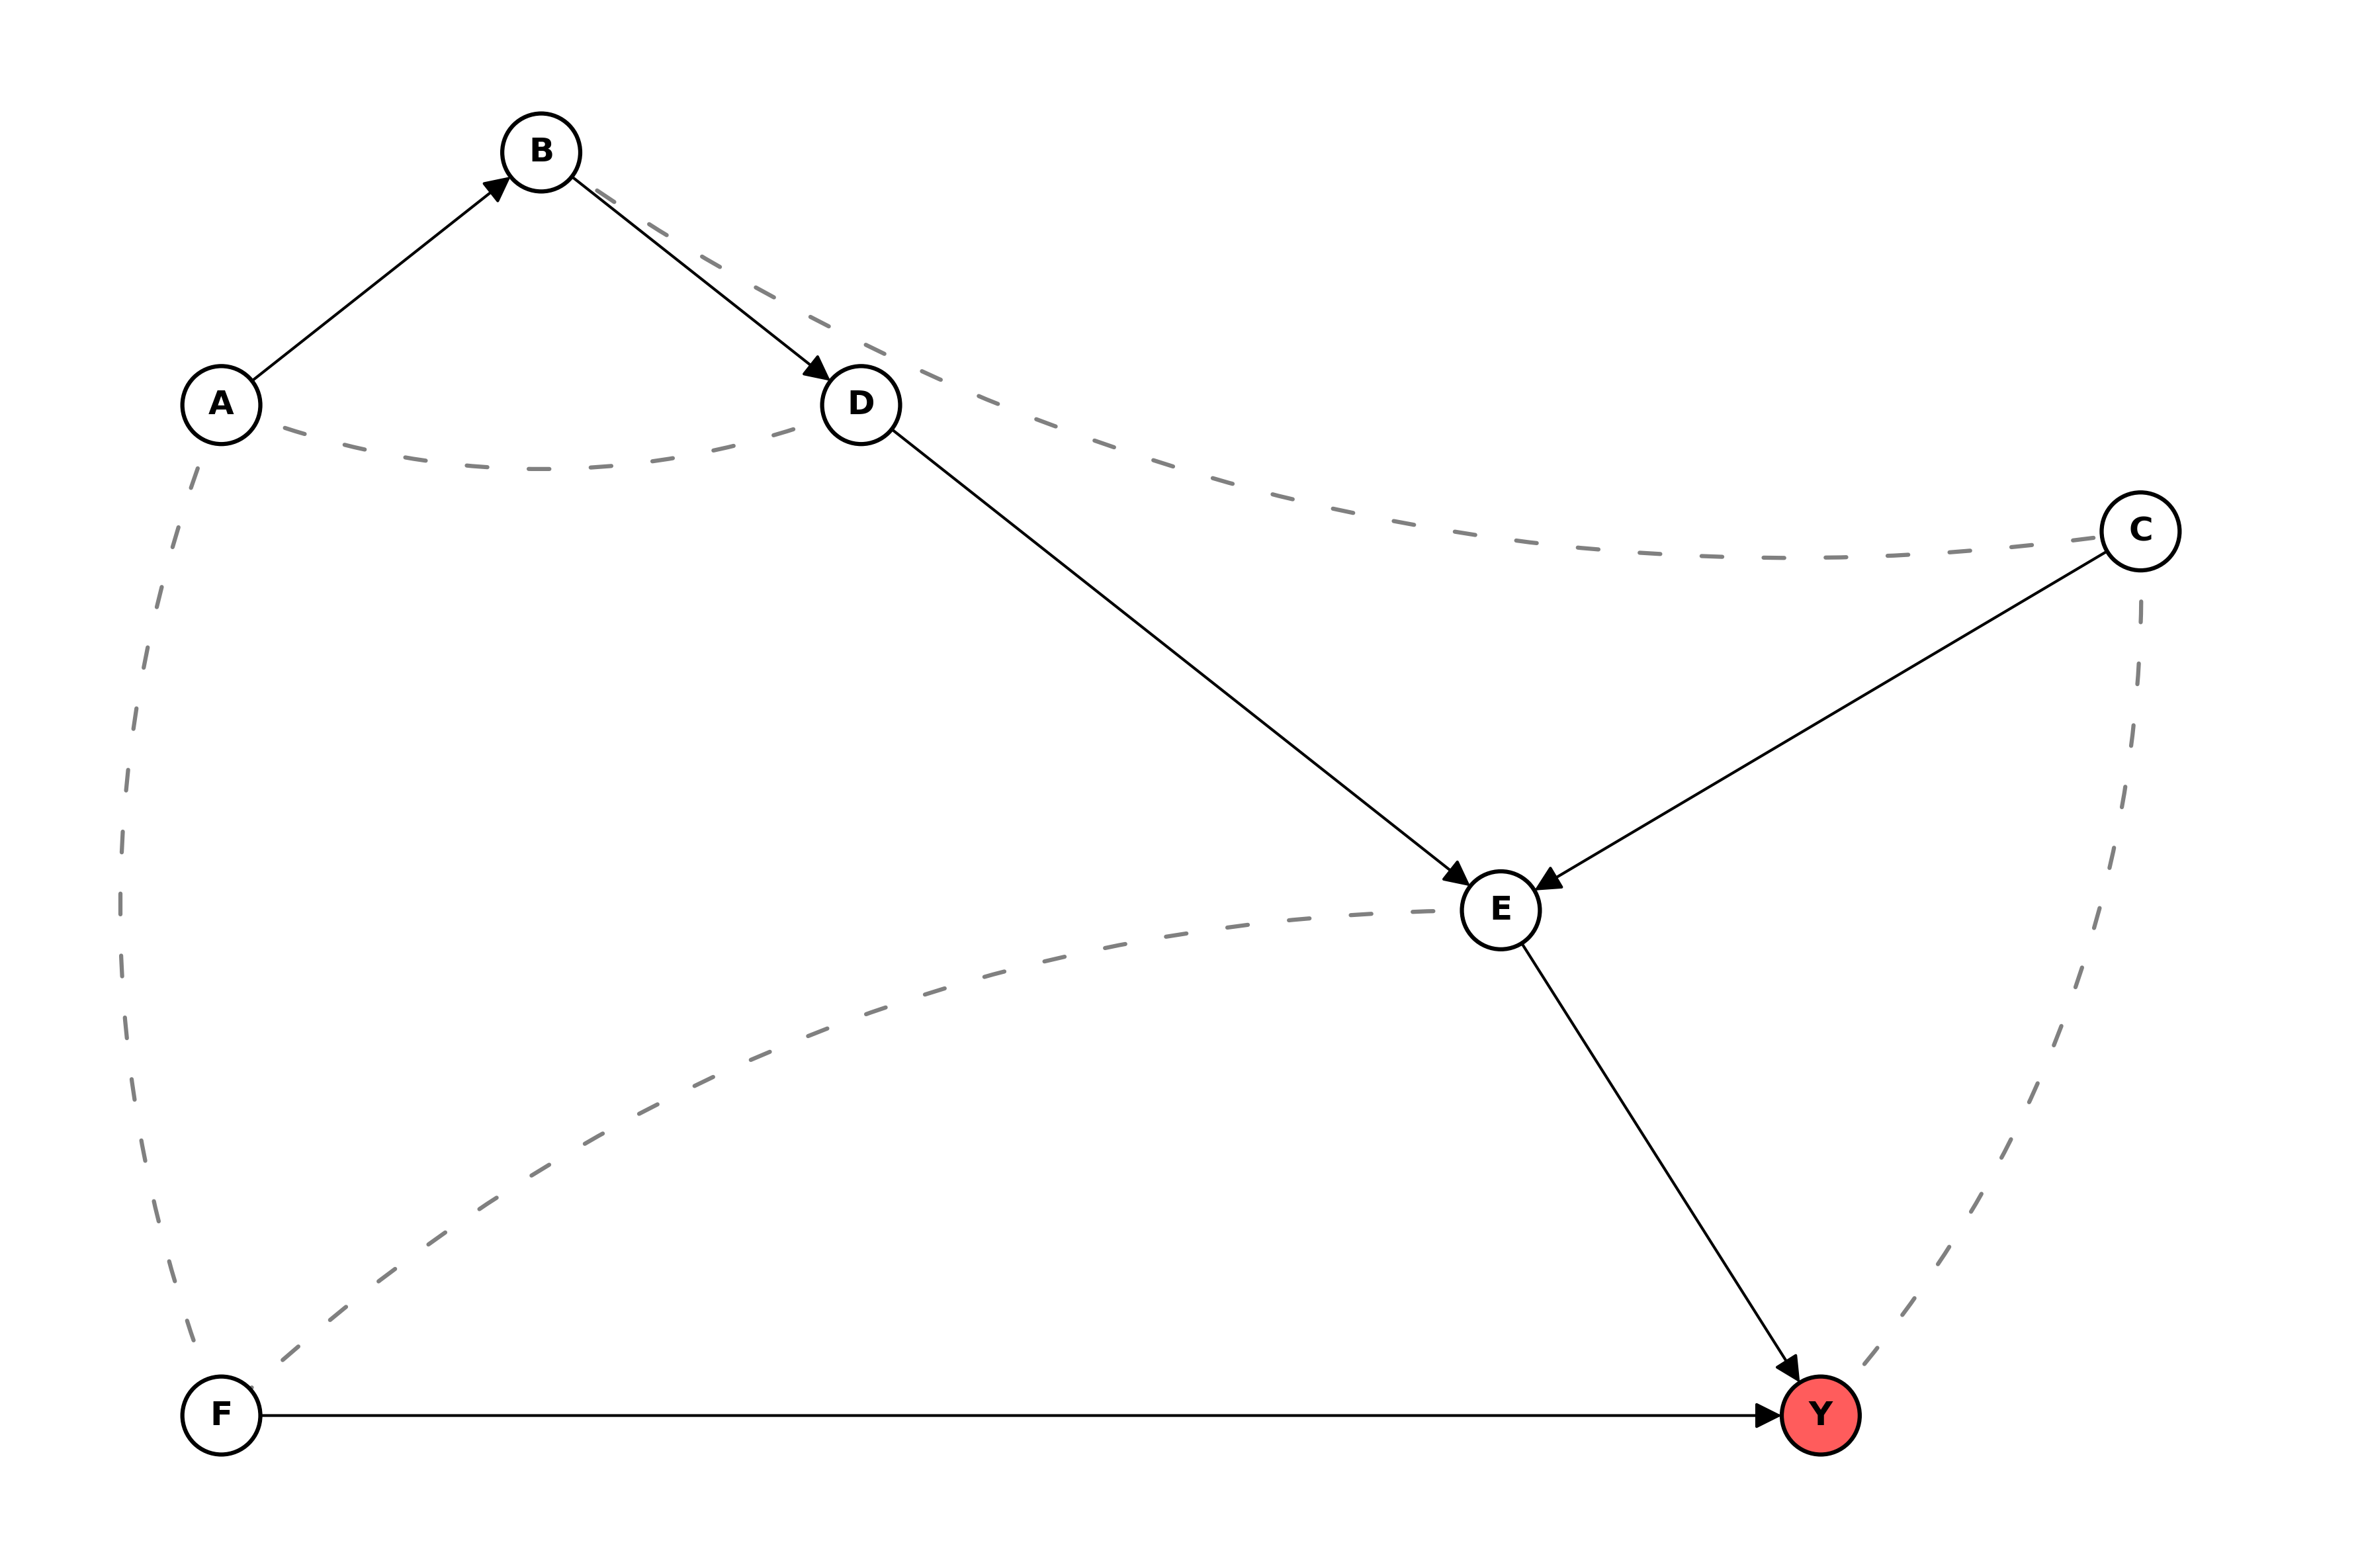

In [25]:
def ex2_cdag():
    B,A,D,F,E,C,Y= 'B','A','D','F','E','C','Y'
    return CausalGraph({B,A,D,F,E,C,Y}, [(A, B), (B, D), (D, E), (C, E), (E, Y), (F, Y)], [(B, C, 'U_BC'), (A, F, 'U_AF'), (A, D, 'U_AD'), (E, F, 'U_EF'), (C, Y, 'U_CY')])
cdag = ex2_cdag()
pos = {
    'B': (0.5,5),
    'A': (0,4),
    'D':(1,4),
    'F':(0,0),
    'E':(2,2),
    'Y':(2.5,0),
    'C':(3,3.5)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['target']: 'Y',                            # Target
    }
)[0]

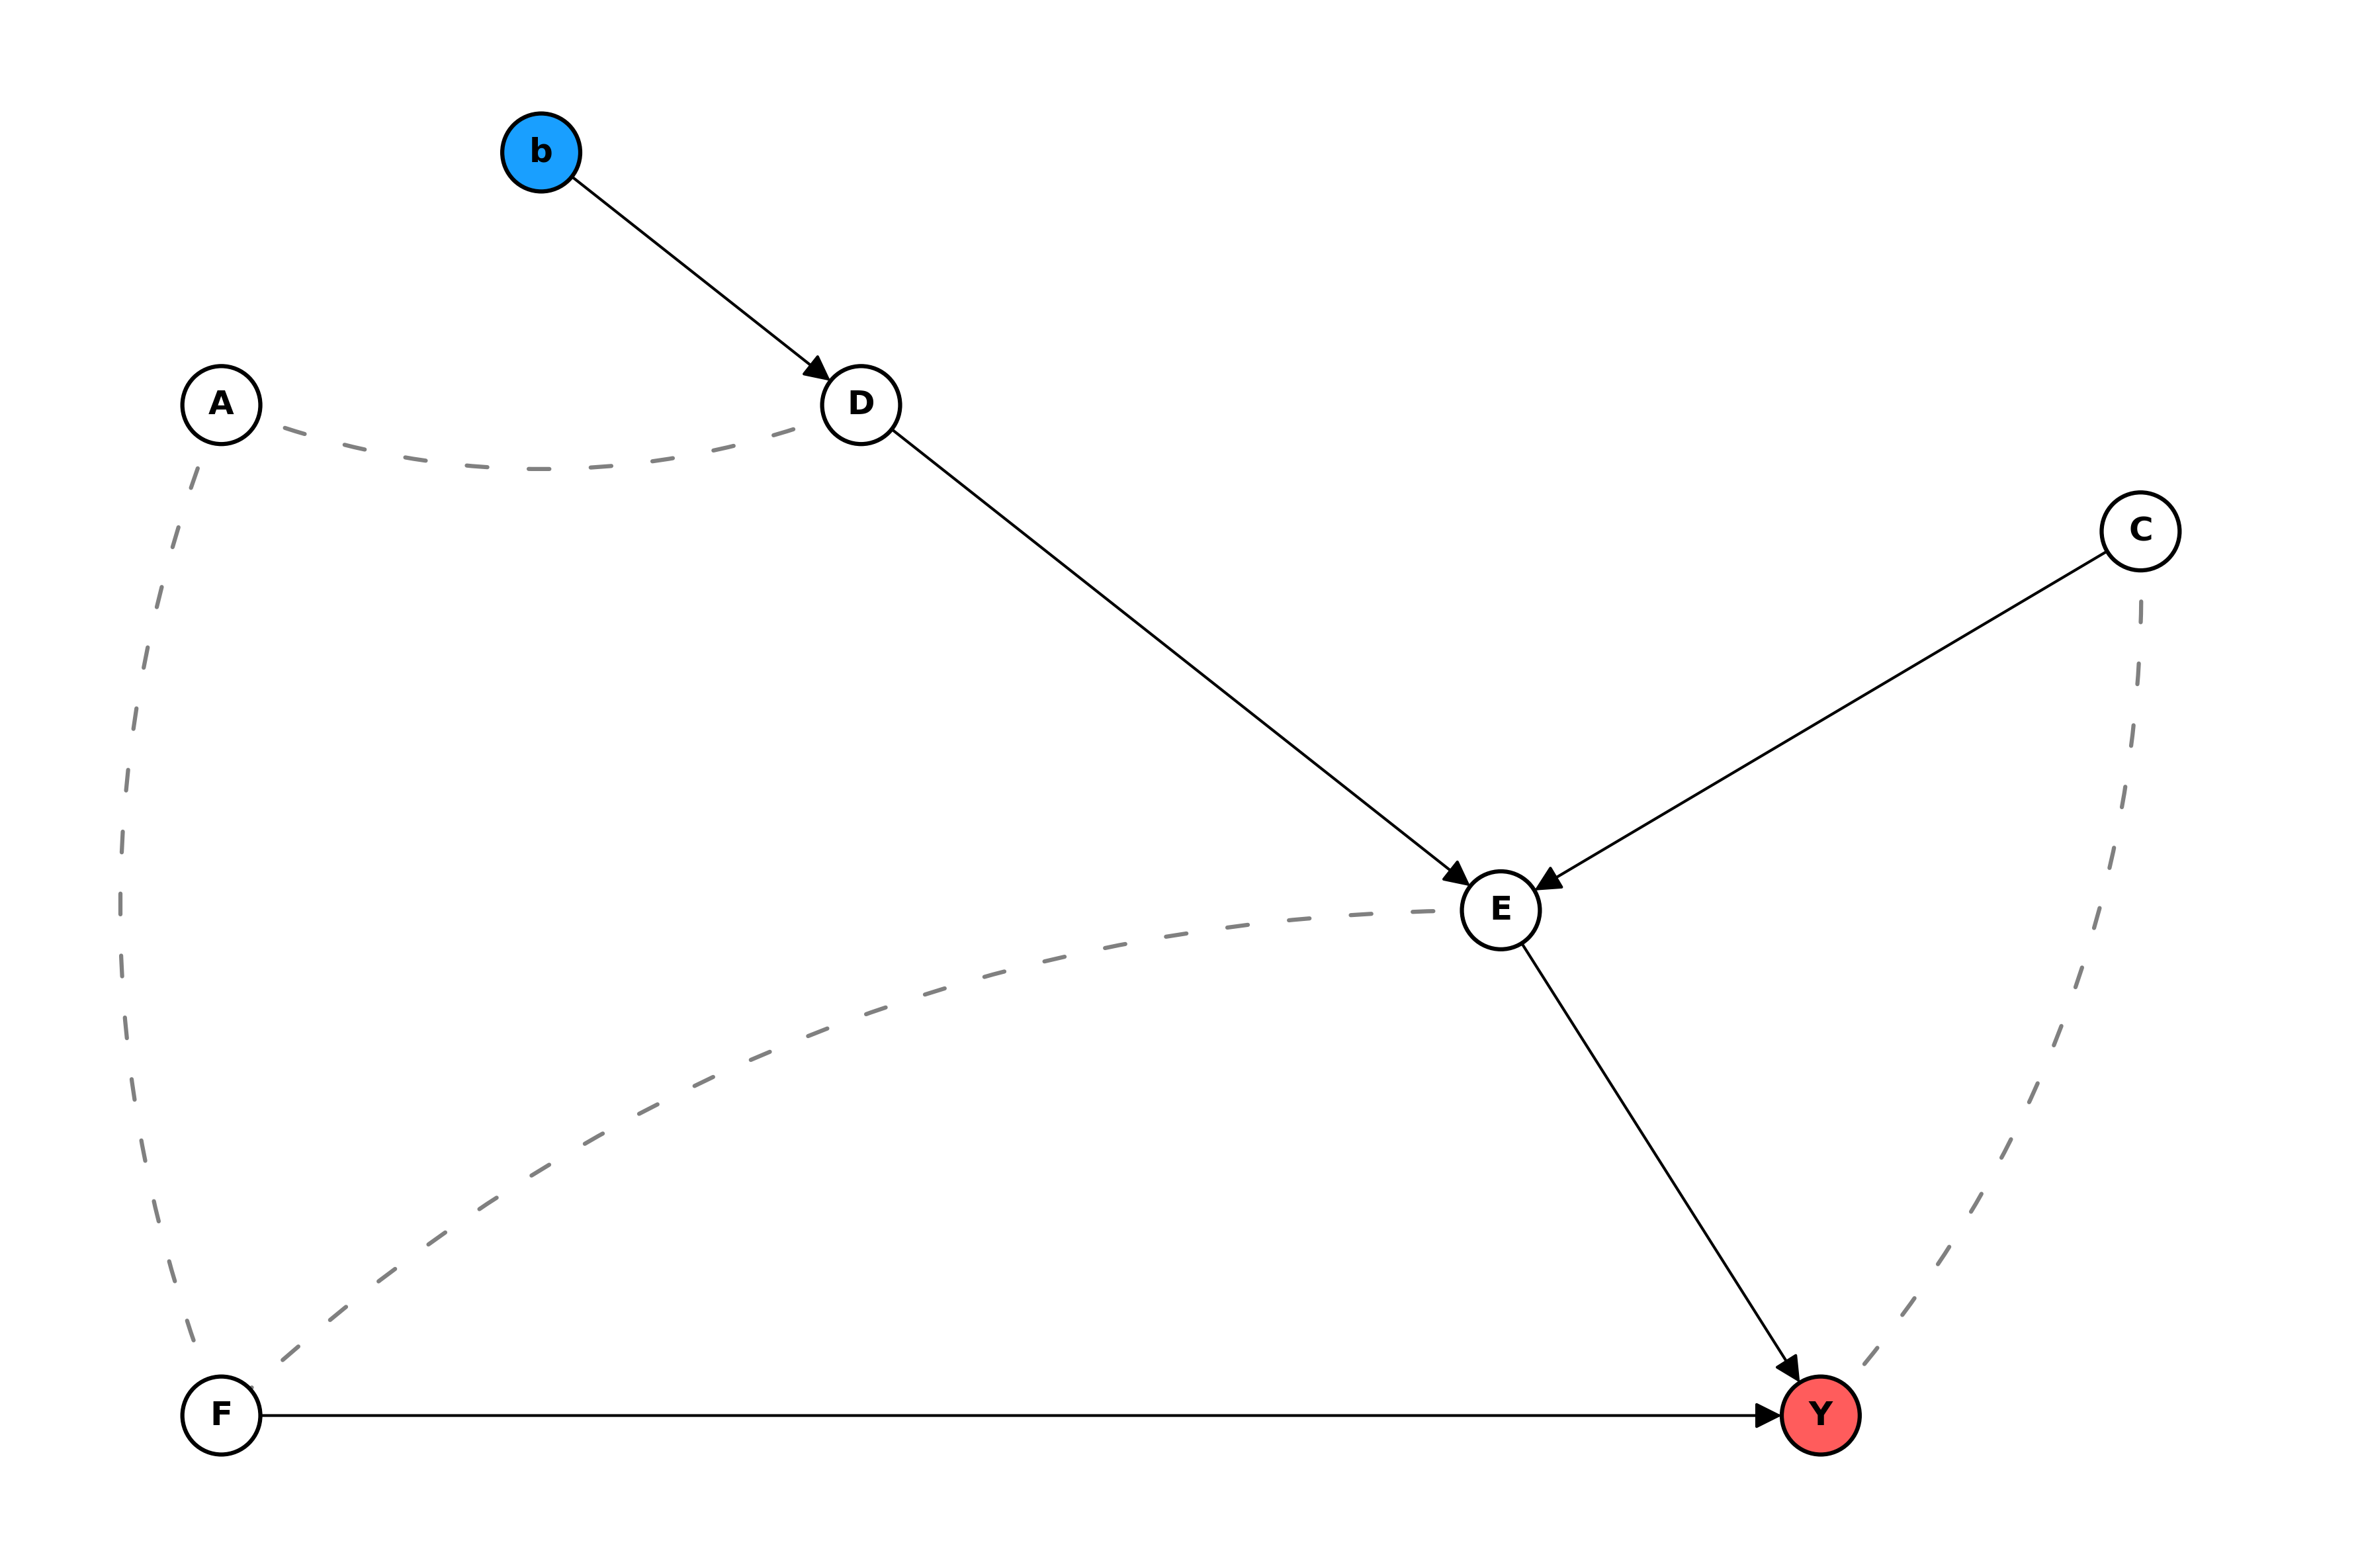

In [26]:
do_vars = {'b'}

def ex2_cdag():
    B,A,D,F,E,C,Y= 'b','A','D','F','E','C','Y'
    return CausalGraph({B,A,D,F,E,C,Y}, [(A, B), (B, D), (D, E), (C, E), (E, Y), (F, Y)], [(B, C, 'U_BC'), (A, F, 'U_AF'), (A, D, 'U_AD'), (E, F, 'U_EF'), (C, Y, 'U_CY')])

cdag = ex2_cdag().do(do_vars)
pos = {
    'b': (0.5,5),
    'A': (0,4),
    'D':(1,4),
    'F':(0,0),
    'E':(2,2),
    'Y':(2.5,0),
    'C':(3,3.5)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['target']: 'Y',                            # Target
        colors['intervention']: do_vars                   # Intervention
    }
)[0]

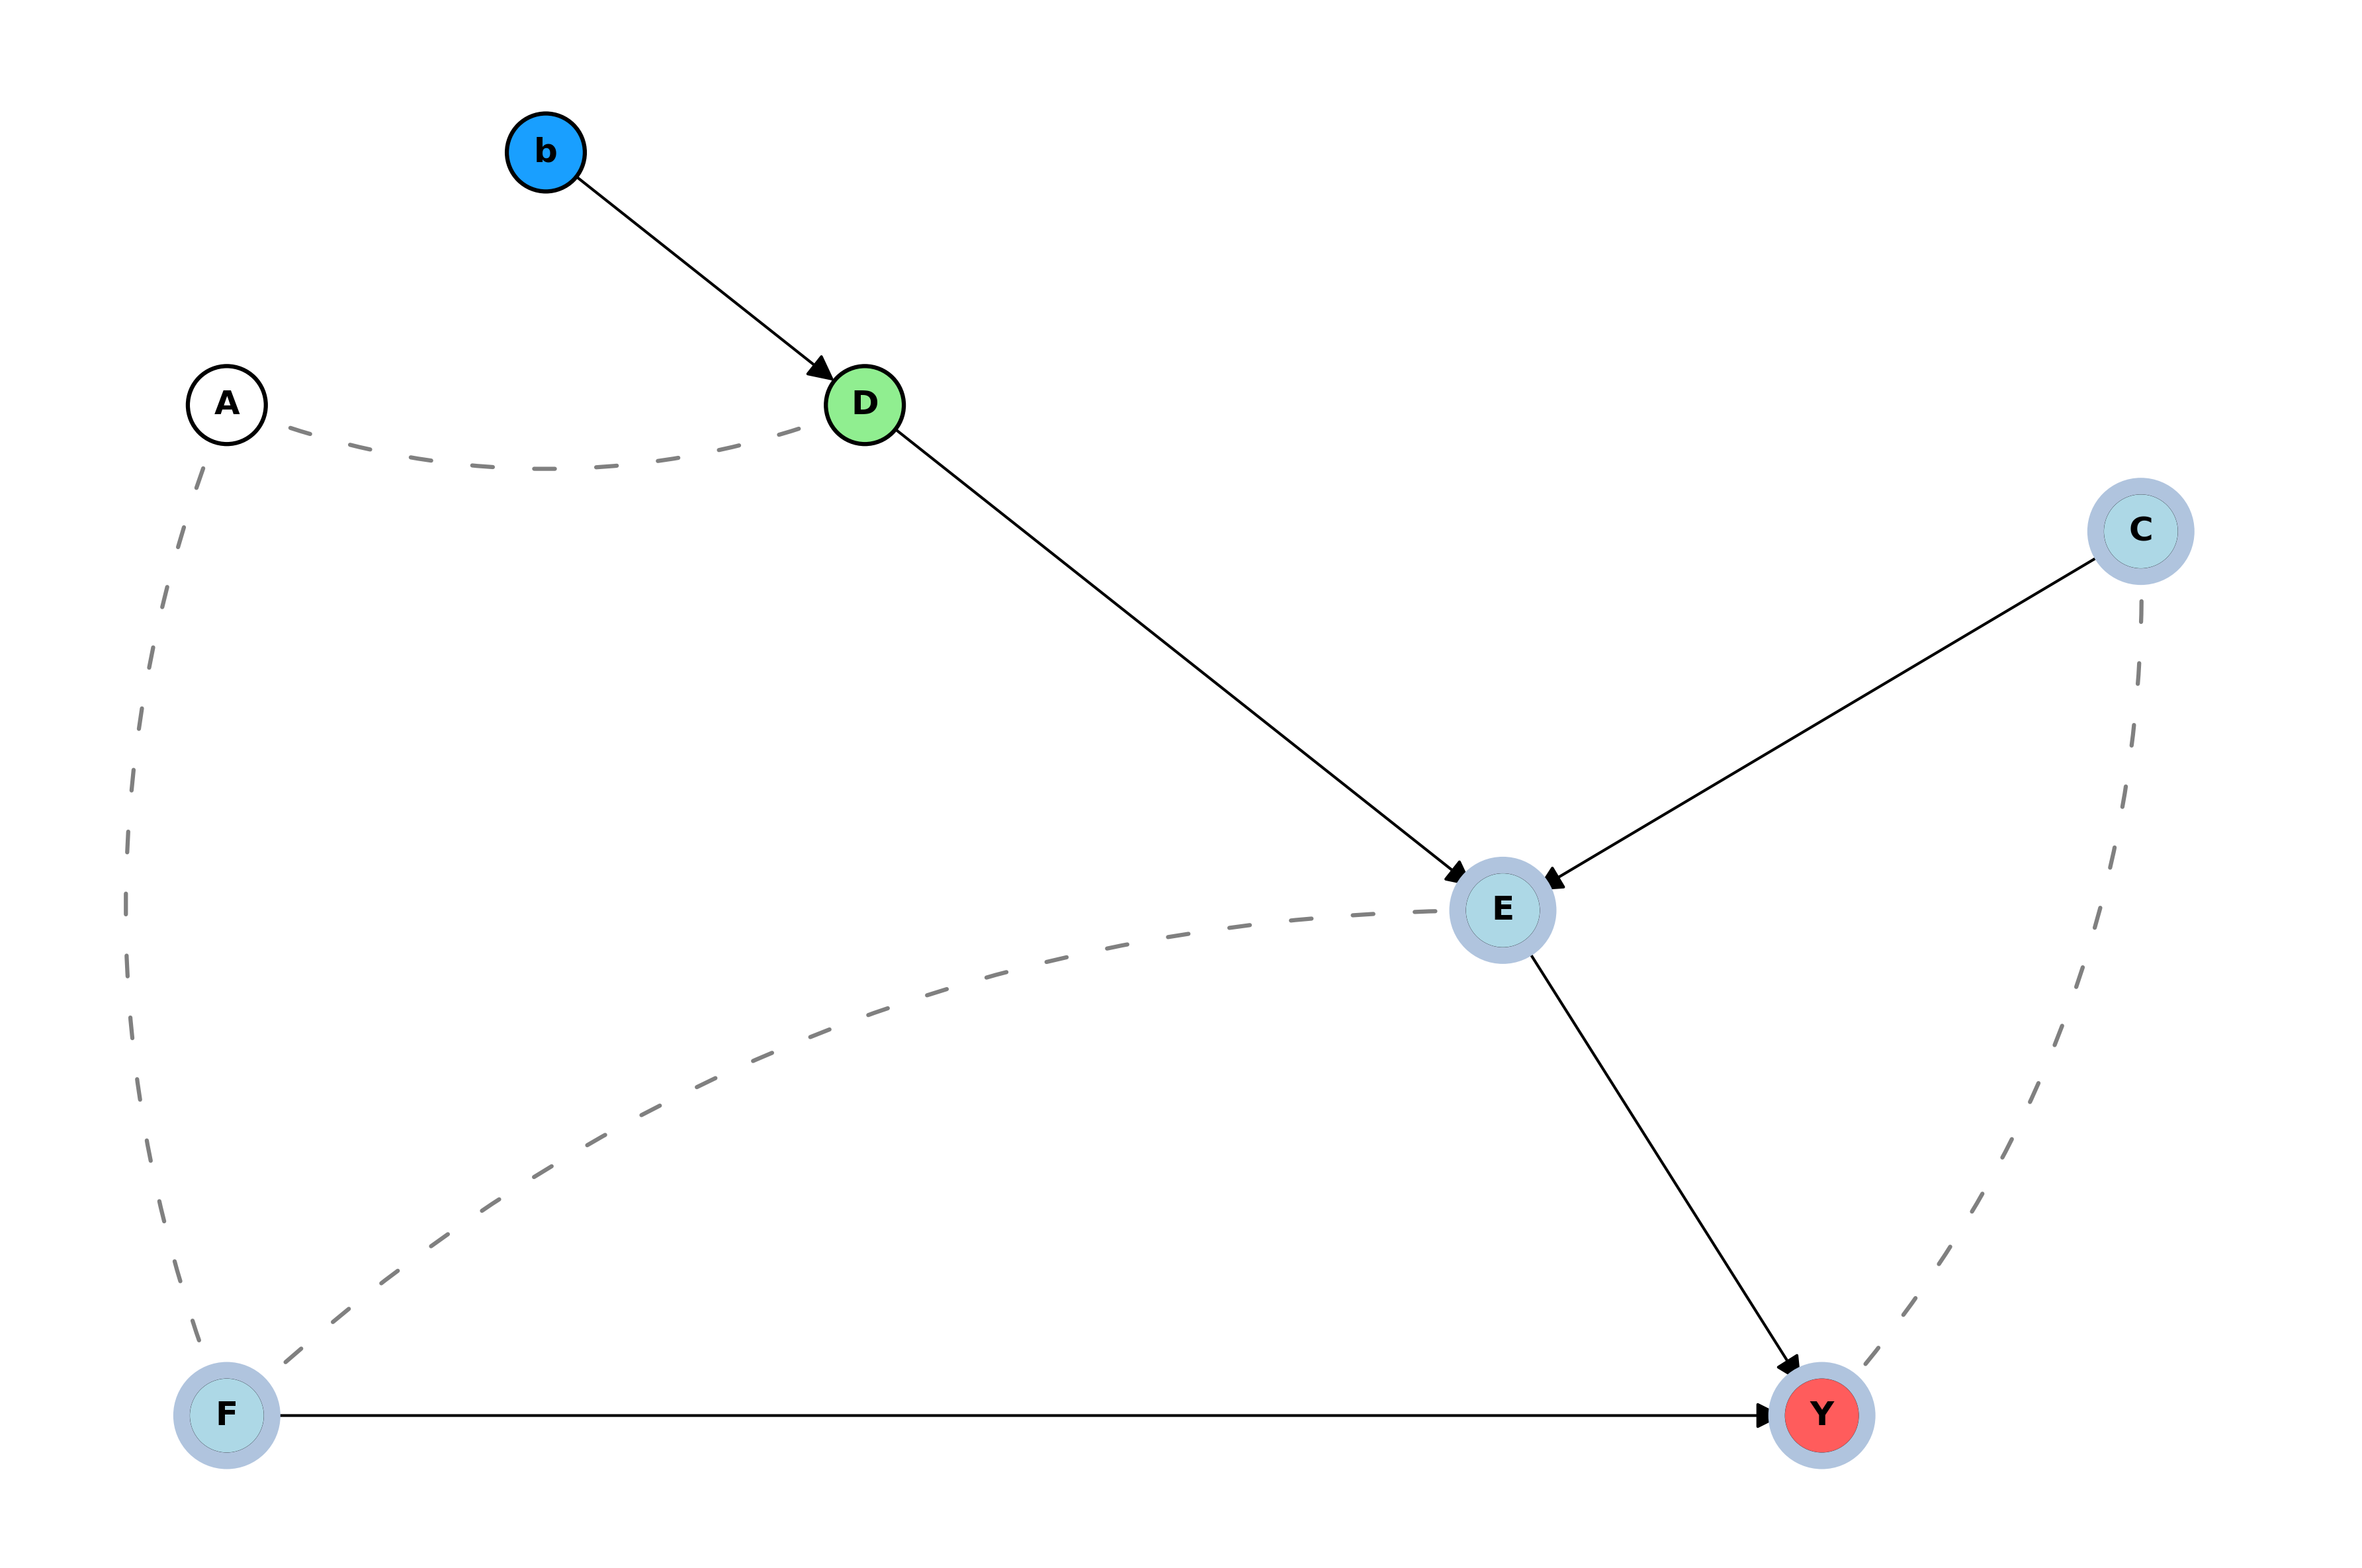

In [27]:
do_vars = {'b'}

def ex2_cdag():
    B,A,D,F,E,C,Y= 'b','A','D','F','E','C','Y'
    return CausalGraph({B,A,D,F,E,C,Y}, [(A, B), (B, D), (D, E), (C, E), (E, Y), (F, Y)], [(B, C, 'U_BC'), (A, F, 'U_AF'), (A, D, 'U_AD'), (E, F, 'U_EF'), (C, Y, 'U_CY')])

cdag = ex2_cdag().do(do_vars)
pos = {
    'b': (0.5,5),
    'A': (0,4),
    'D':(1,4),
    'F':(0,0),
    'E':(2,2),
    'Y':(2.5,0),
    'C':(3,3.5)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: 'b',                      # Intervention Variable
    }
)[0]

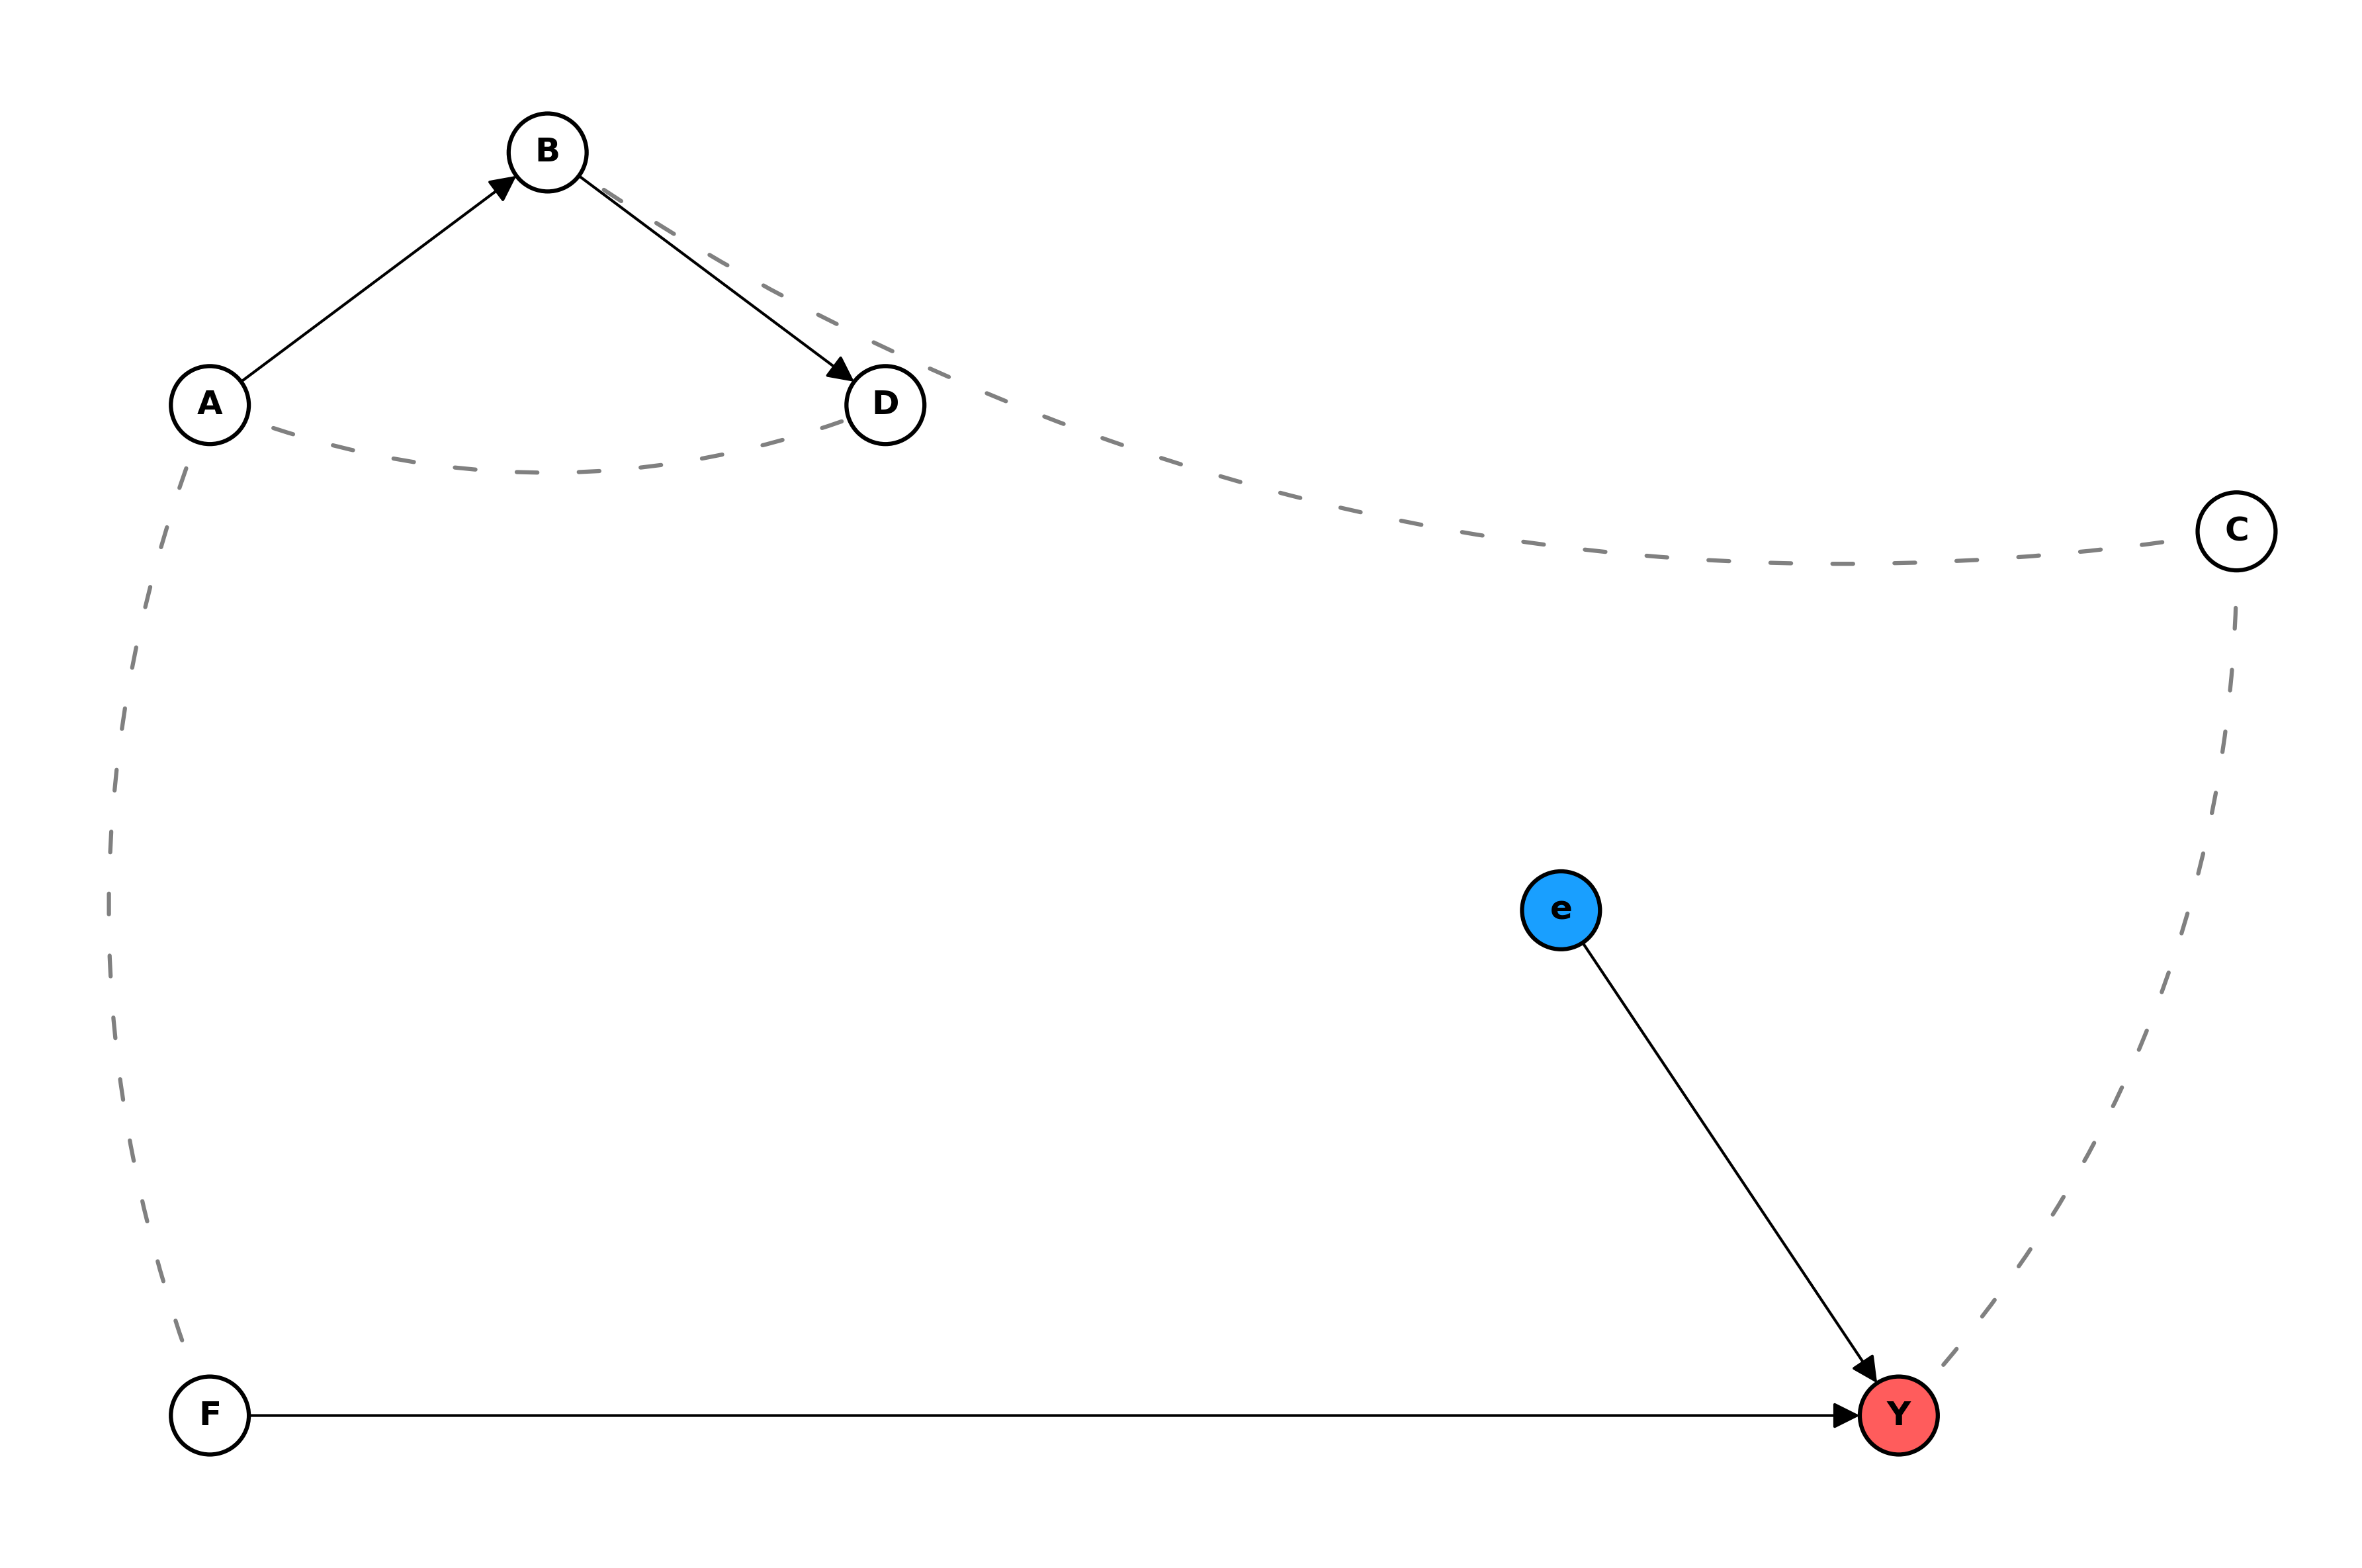

In [ ]:
do_vars = {'e'}

def ex2_cdag():
    B,A,D,F,E,C,Y= 'B','A','D','F','e','C','Y'
    return CausalGraph({B,A,D,F,E,C,Y}, [(A, B), (B, D), (D, E), (C, E), (E, Y), (F, Y)], [(B, C, 'U_BC'), (A, F, 'U_AF'), (A, D, 'U_AD'), (E, F, 'U_EF'), (C, Y, 'U_CY')])

cdag = ex2_cdag().do(do_vars)
pos = {
    'B': (0.5,5),
    'A': (0,4),
    'D':(1,4),
    'F':(0,0),
    'e':(2,2),
    'Y':(2.5,0),
    'C':(3,3.5)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: 'e',                      # Intervention Variable
    }
)[0]

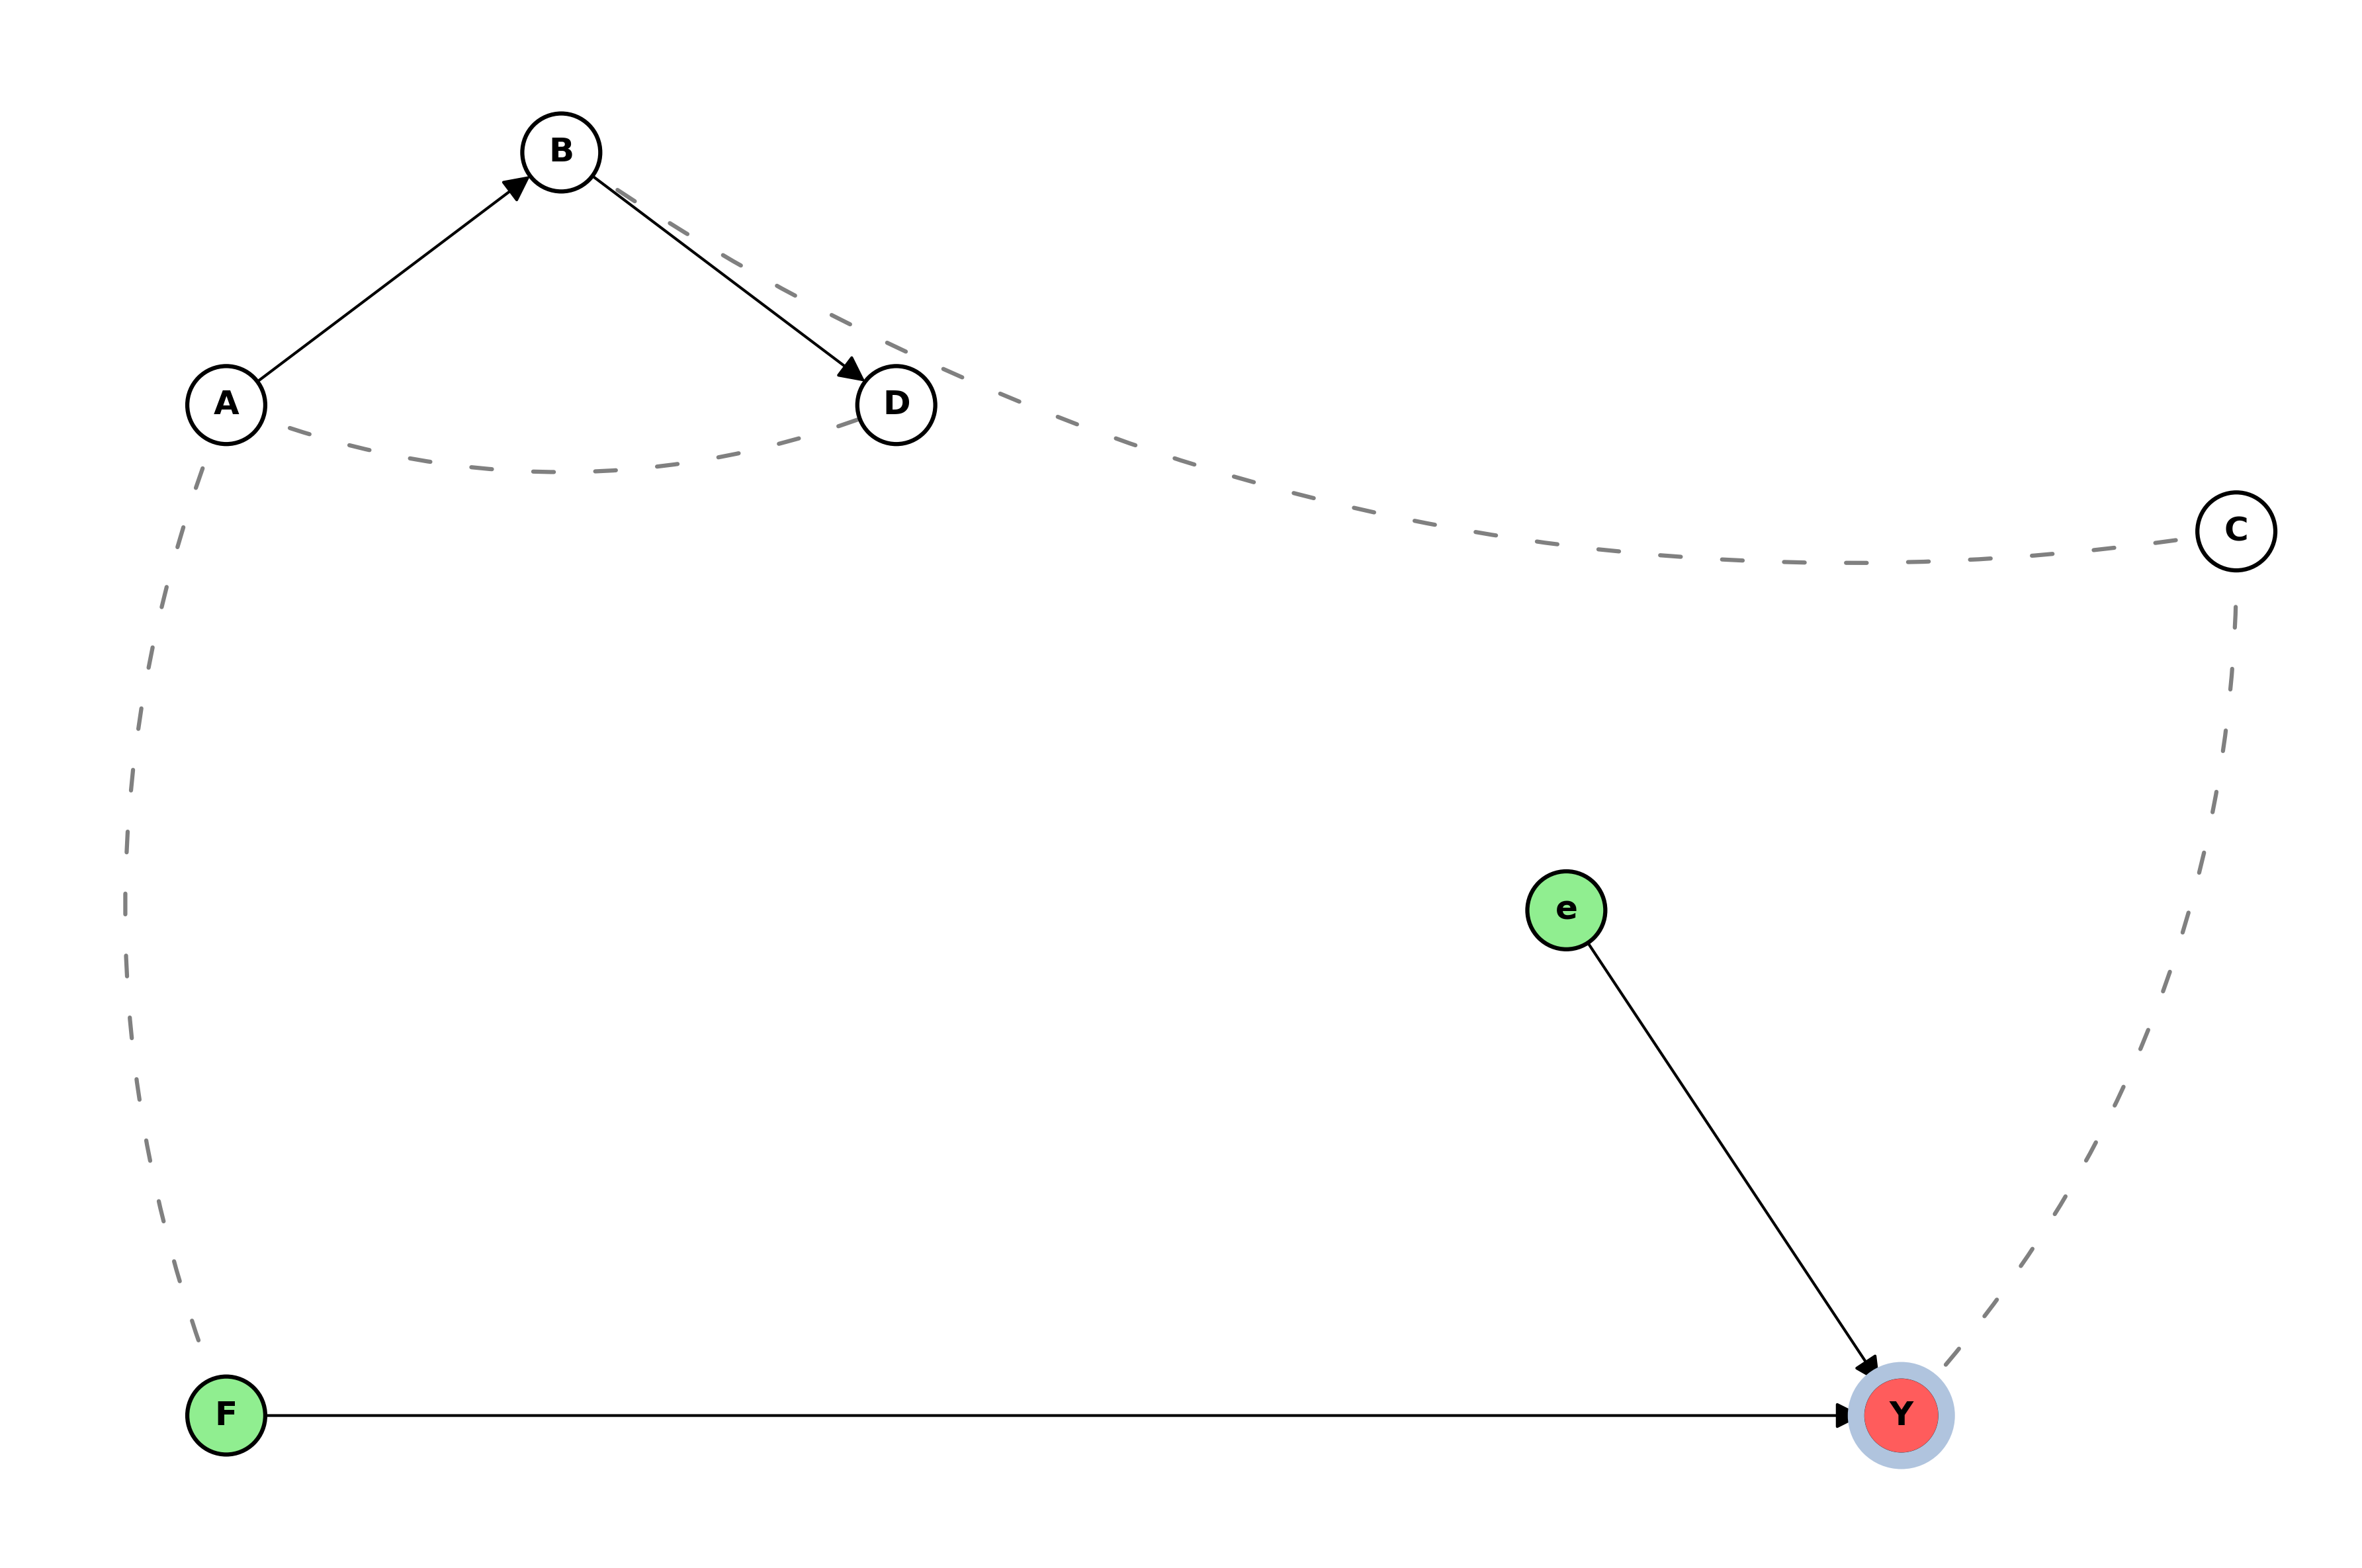

In [31]:
cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['intervention']: 'e',
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

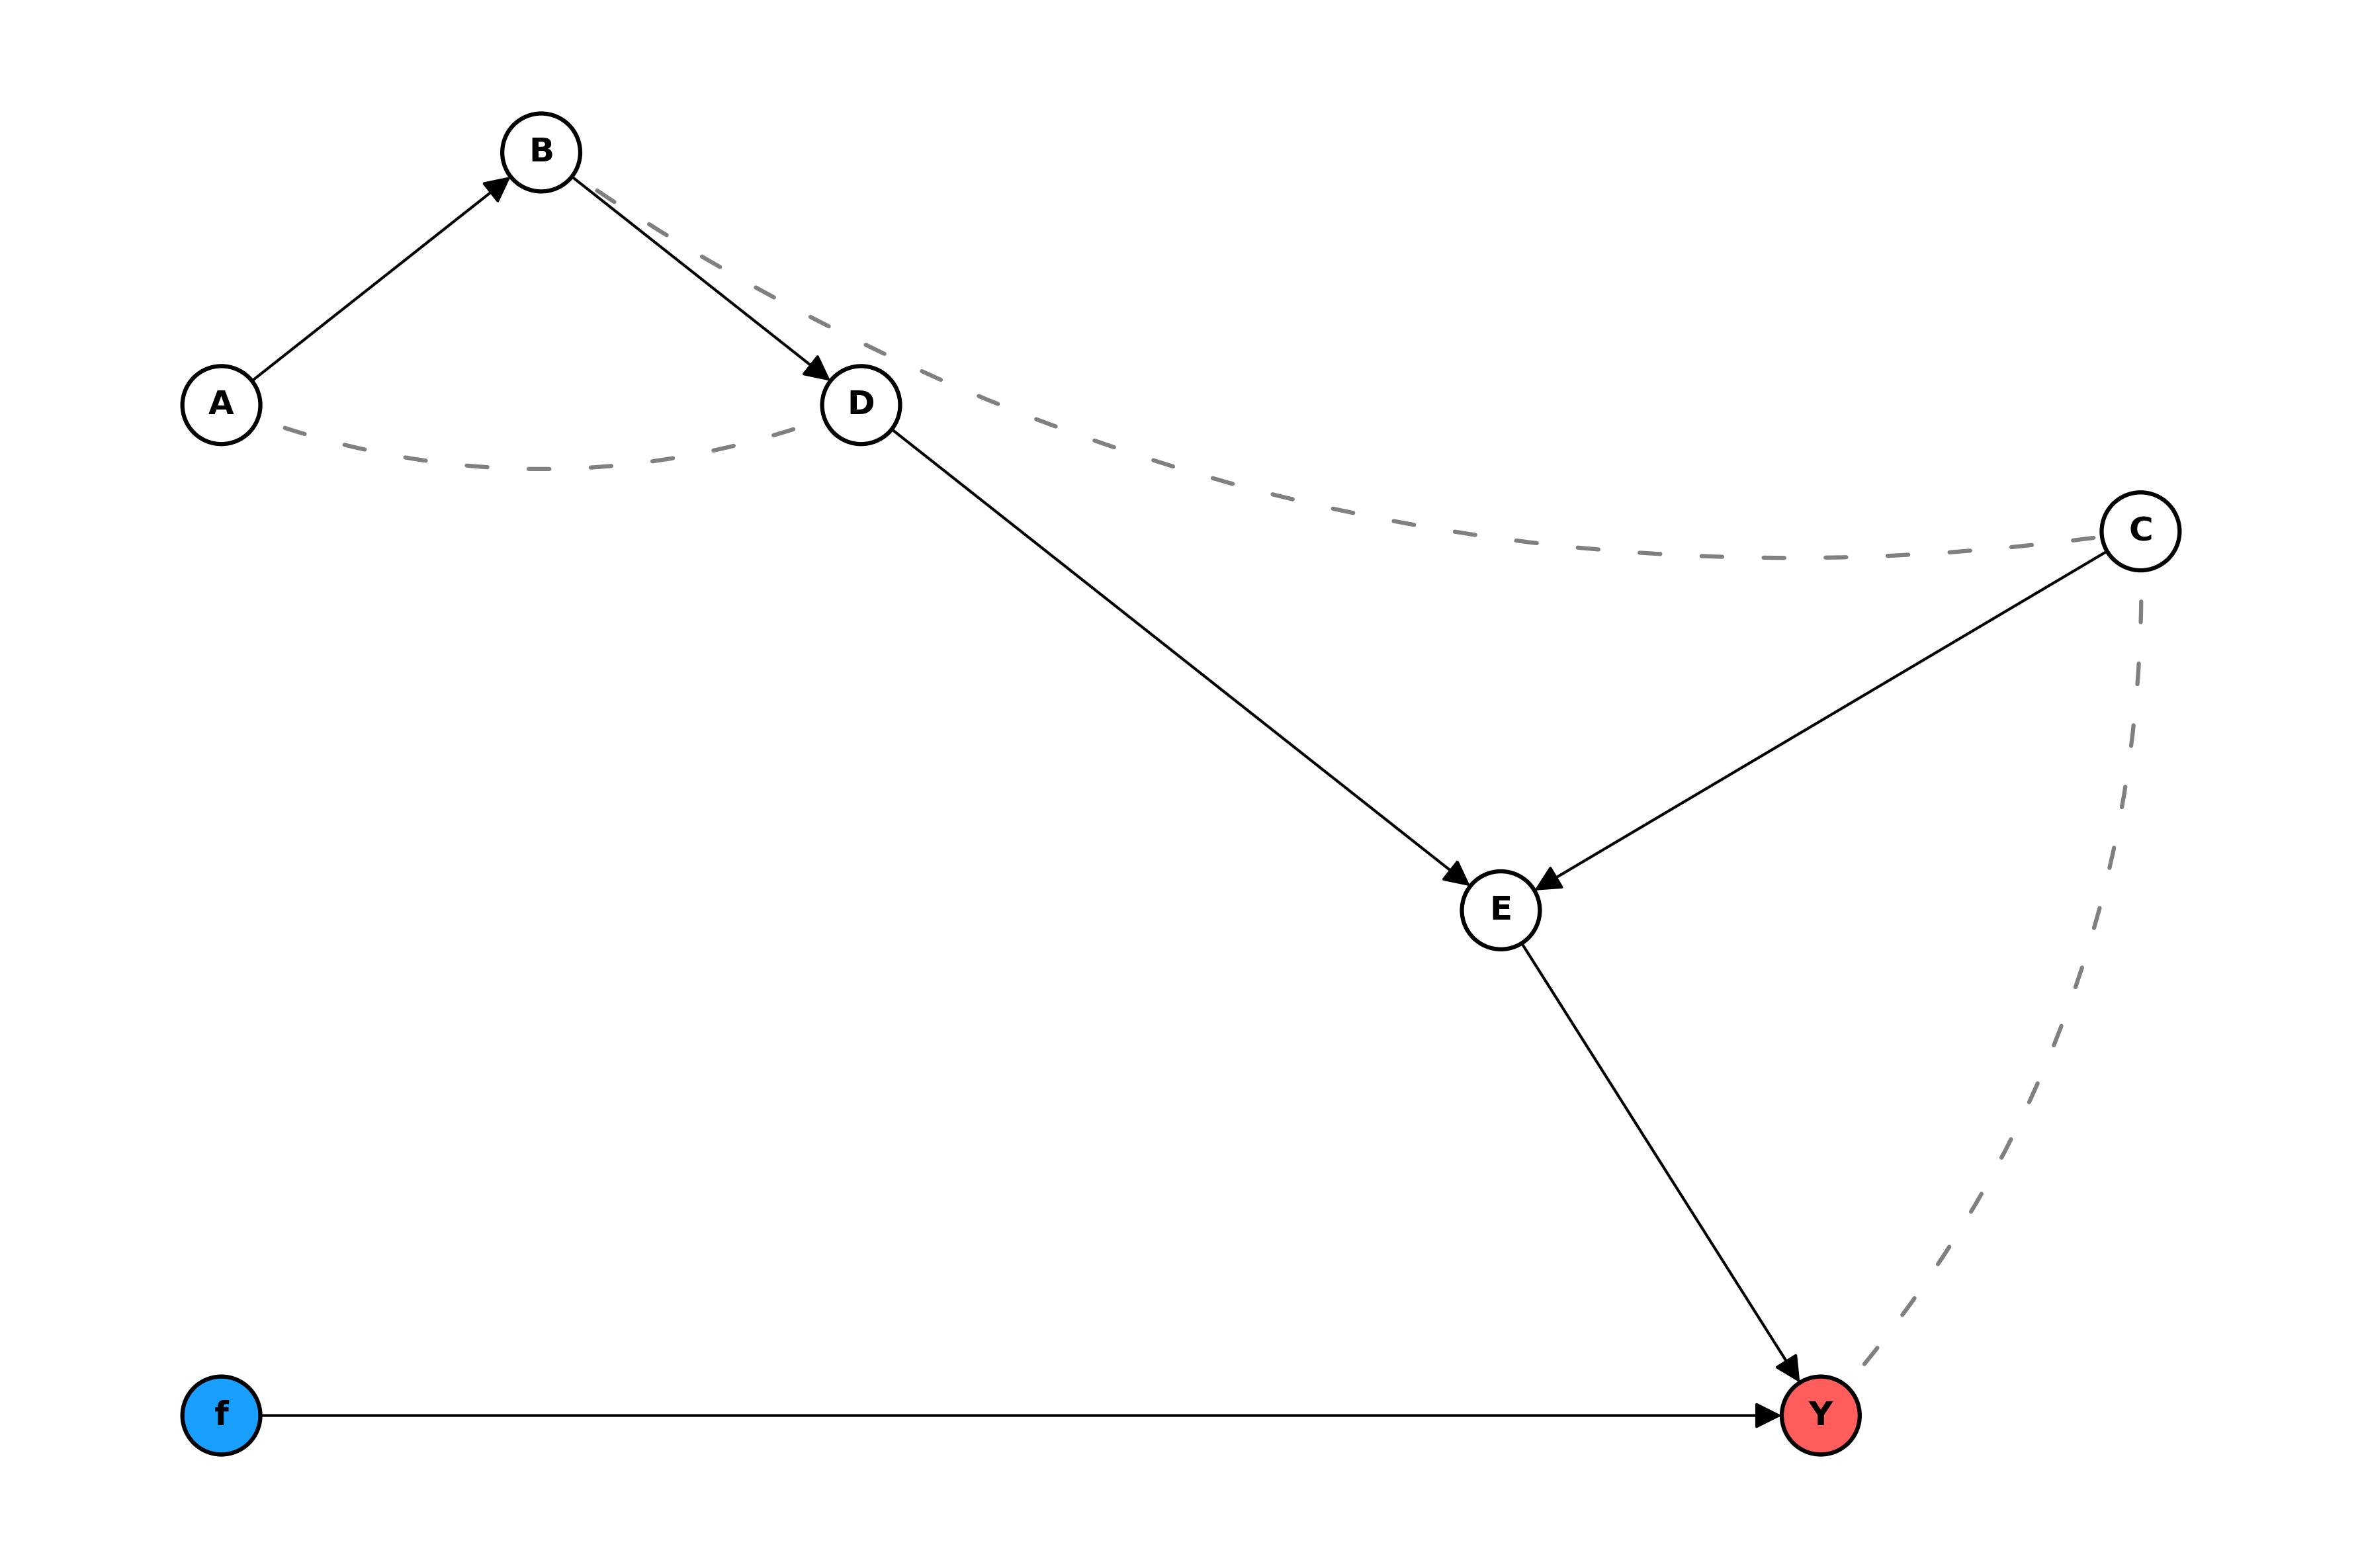

In [32]:
do_vars = {'f'}

def ex2_cdag():
    B,A,D,F,E,C,Y= 'B','A','D','f','E','C','Y'
    return CausalGraph({B,A,D,F,E,C,Y}, [(A, B), (B, D), (D, E), (C, E), (E, Y), (F, Y)], [(B, C, 'U_BC'), (A, F, 'U_AF'), (A, D, 'U_AD'), (E, F, 'U_EF'), (C, Y, 'U_CY')])

cdag = ex2_cdag().do(do_vars)
pos = {
    'B': (0.5,5),
    'A': (0,4),
    'D':(1,4),
    'f':(0,0),
    'E':(2,2),
    'Y':(2.5,0),
    'C':(3,3.5)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        colors['intervention']: 'f',                      # Intervention Variable
    }
)[0]

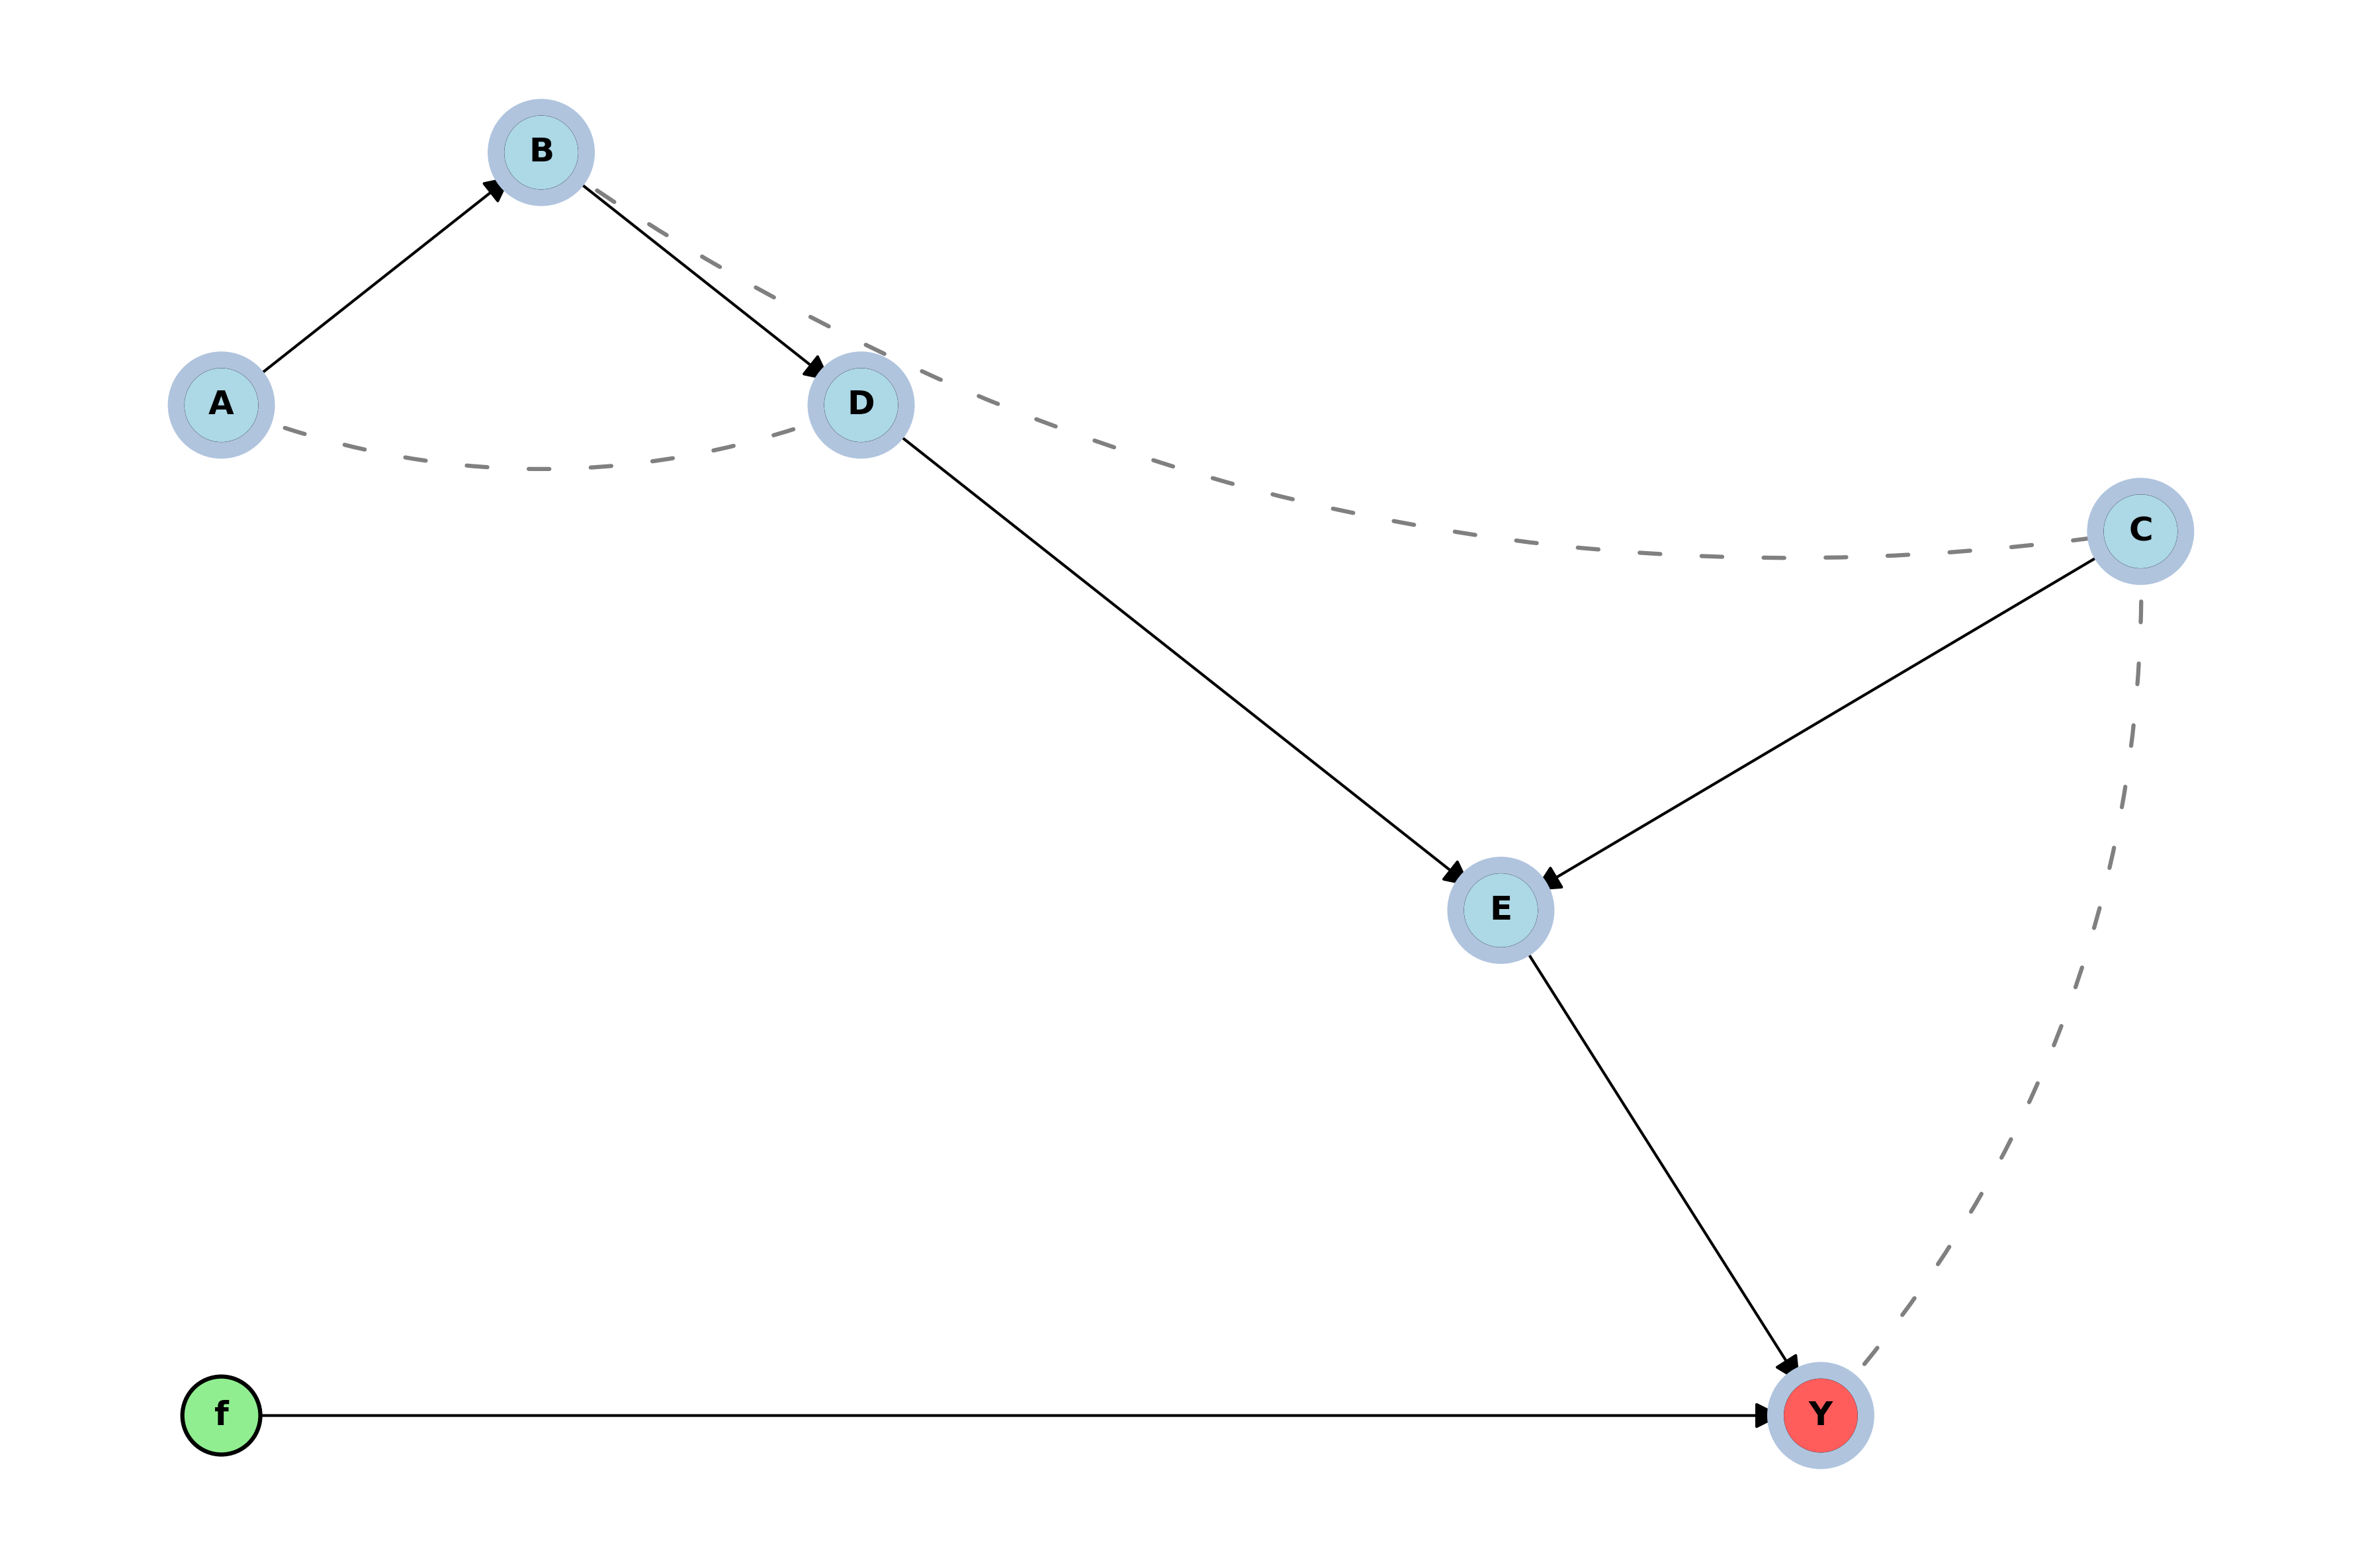

In [33]:
do_vars = {'f'}

def ex2_cdag():
    B,A,D,F,E,C,Y= 'B','A','D','f','E','C','Y'
    return CausalGraph({B,A,D,F,E,C,Y}, [(A, B), (B, D), (D, E), (C, E), (E, Y), (F, Y)], [(B, C, 'U_BC'), (A, F, 'U_AF'), (A, D, 'U_AD'), (E, F, 'U_EF'), (C, Y, 'U_CY')])

cdag = ex2_cdag().do(do_vars)
pos = {
    'B': (0.5,5),
    'A': (0,4),
    'D':(1,4),
    'f':(0,0),
    'E':(2,2),
    'Y':(2.5,0),
    'C':(3,3.5)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['intervention']: 'f',                      # Intervention Variable
        colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

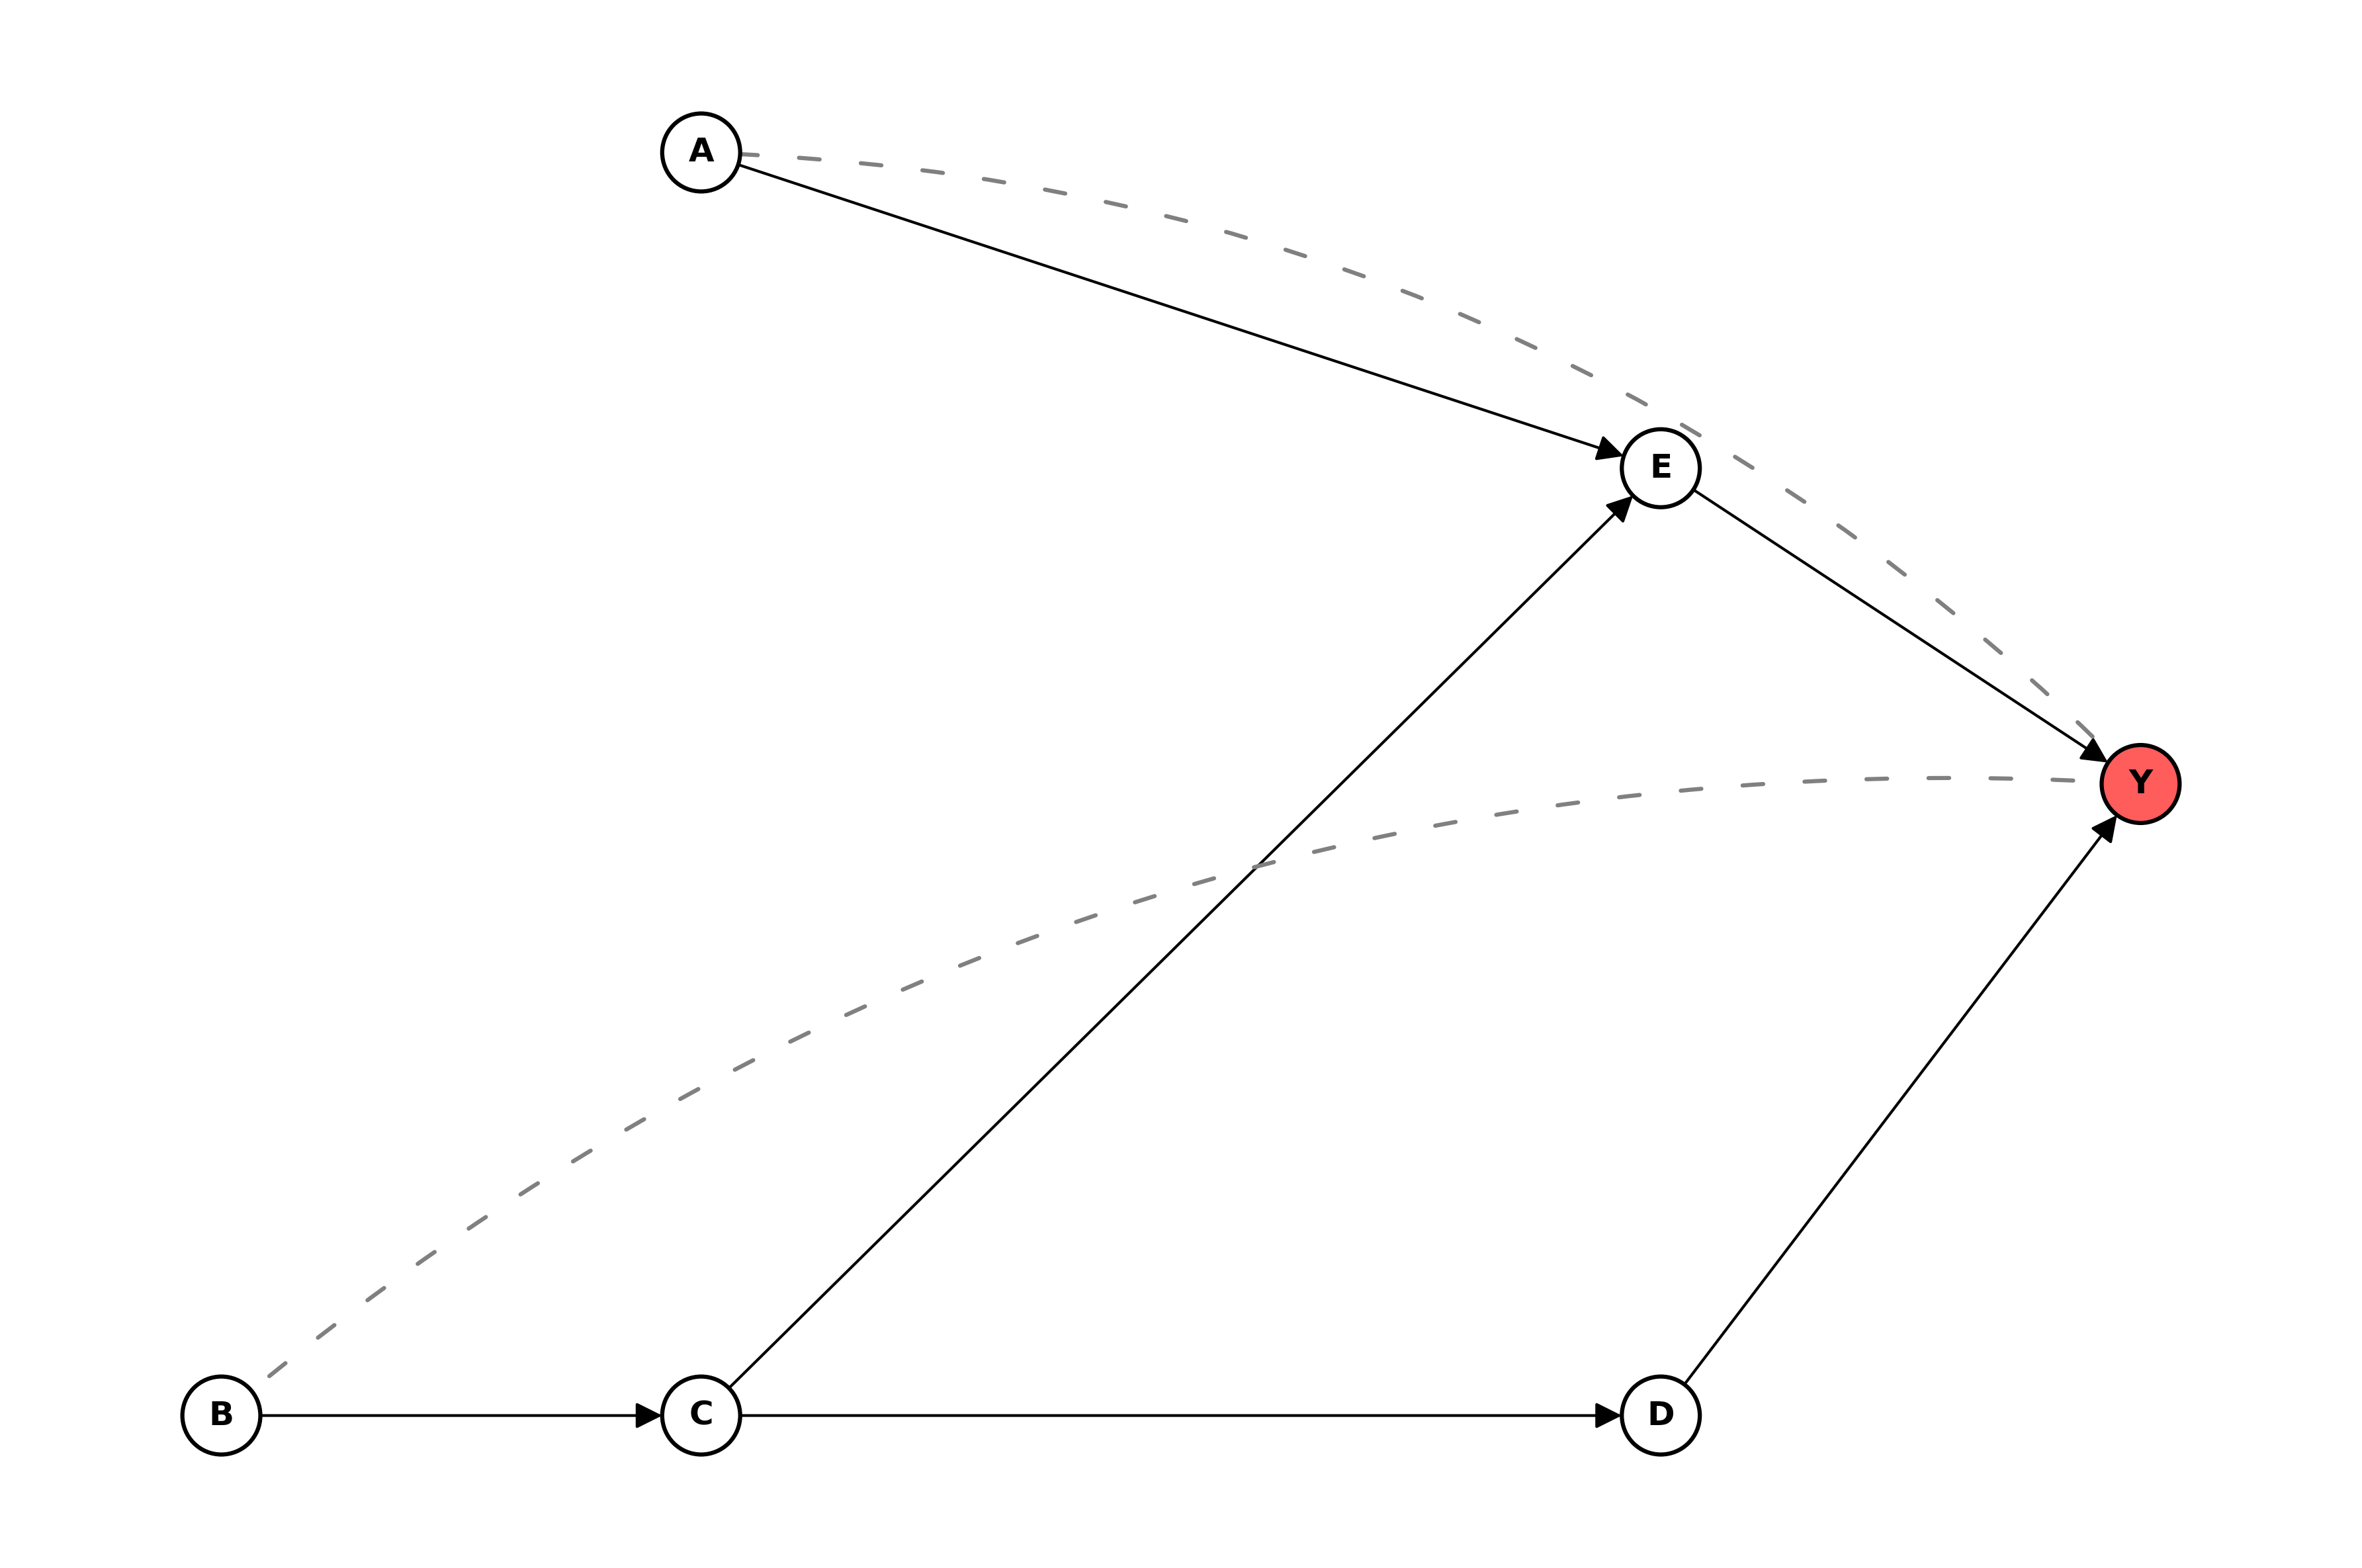

In [49]:
do_vars = {''}

def ex2_cdag():
    B,A,D,E,C,Y= 'B','A','D','E','C','Y'
    return CausalGraph({B,A,D,E,C,Y}, [(A, E), (E, Y), (B, C), (C, E), (C, D), (D, Y)], [(B, Y, 'U_BY'), (A, Y, 'U_AY')])

cdag = ex2_cdag().do(do_vars)
pos = {
    'B': (0,0),
    'A': (1,4),
    'D':(3,0),
    'E':(3,3),
    'Y':(4,2),
    'C':(1,0)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['intervention']: 'f',                      # Intervention Variable
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

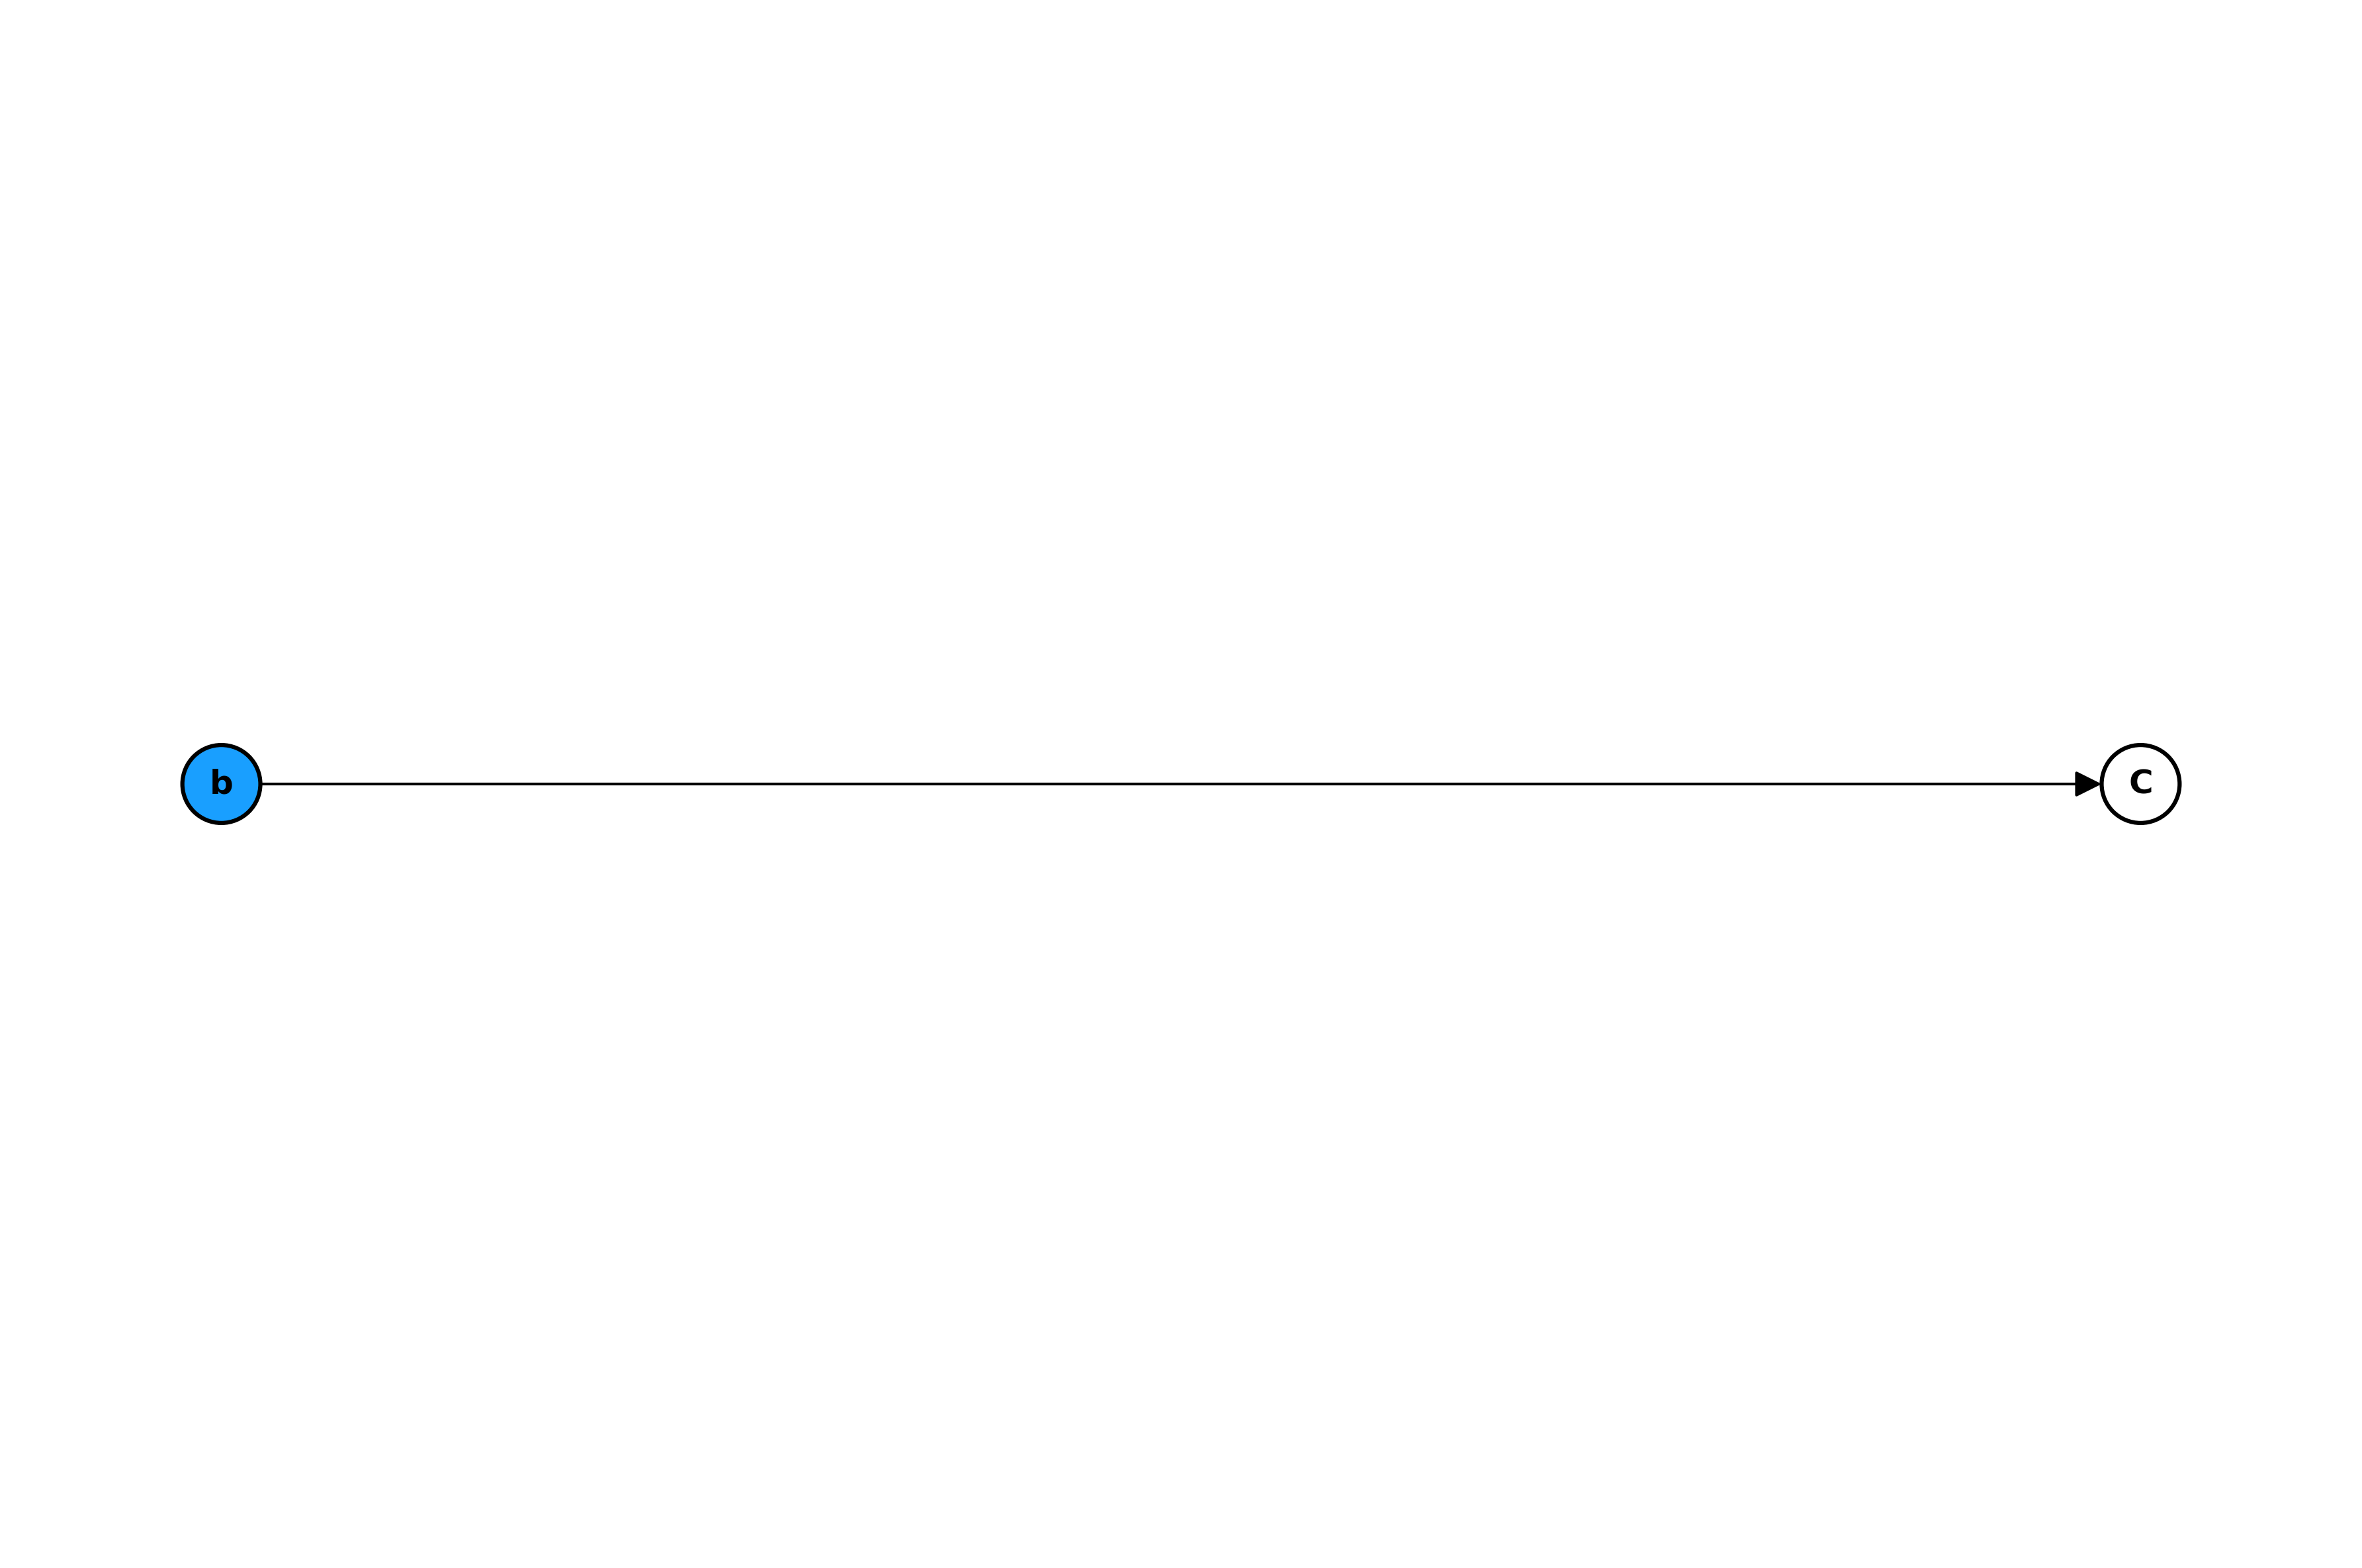

In [53]:
do_vars = {'b'}
induced_vars = {'b', 'C'}

def ex2_cdag():
    B,A,D,E,C,Y= 'b','A','D','E','C','Y'
    return CausalGraph({B,A,D,E,C,Y}, [(A, E), (E, Y), (B, C), (C, E), (C, D), (D, Y)], [(B, Y, 'U_BY'), (A, Y, 'U_AY')])

cdag = ex2_cdag().do(do_vars).induced(induced_vars)
pos = {
    'b': (0,0),
    'A': (1,4),
    'D':(3,0),
    'E':(3,3),
    'Y':(4,2),
    'C':(1,0)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['intervention']: 'b',                      # Intervention Variable
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

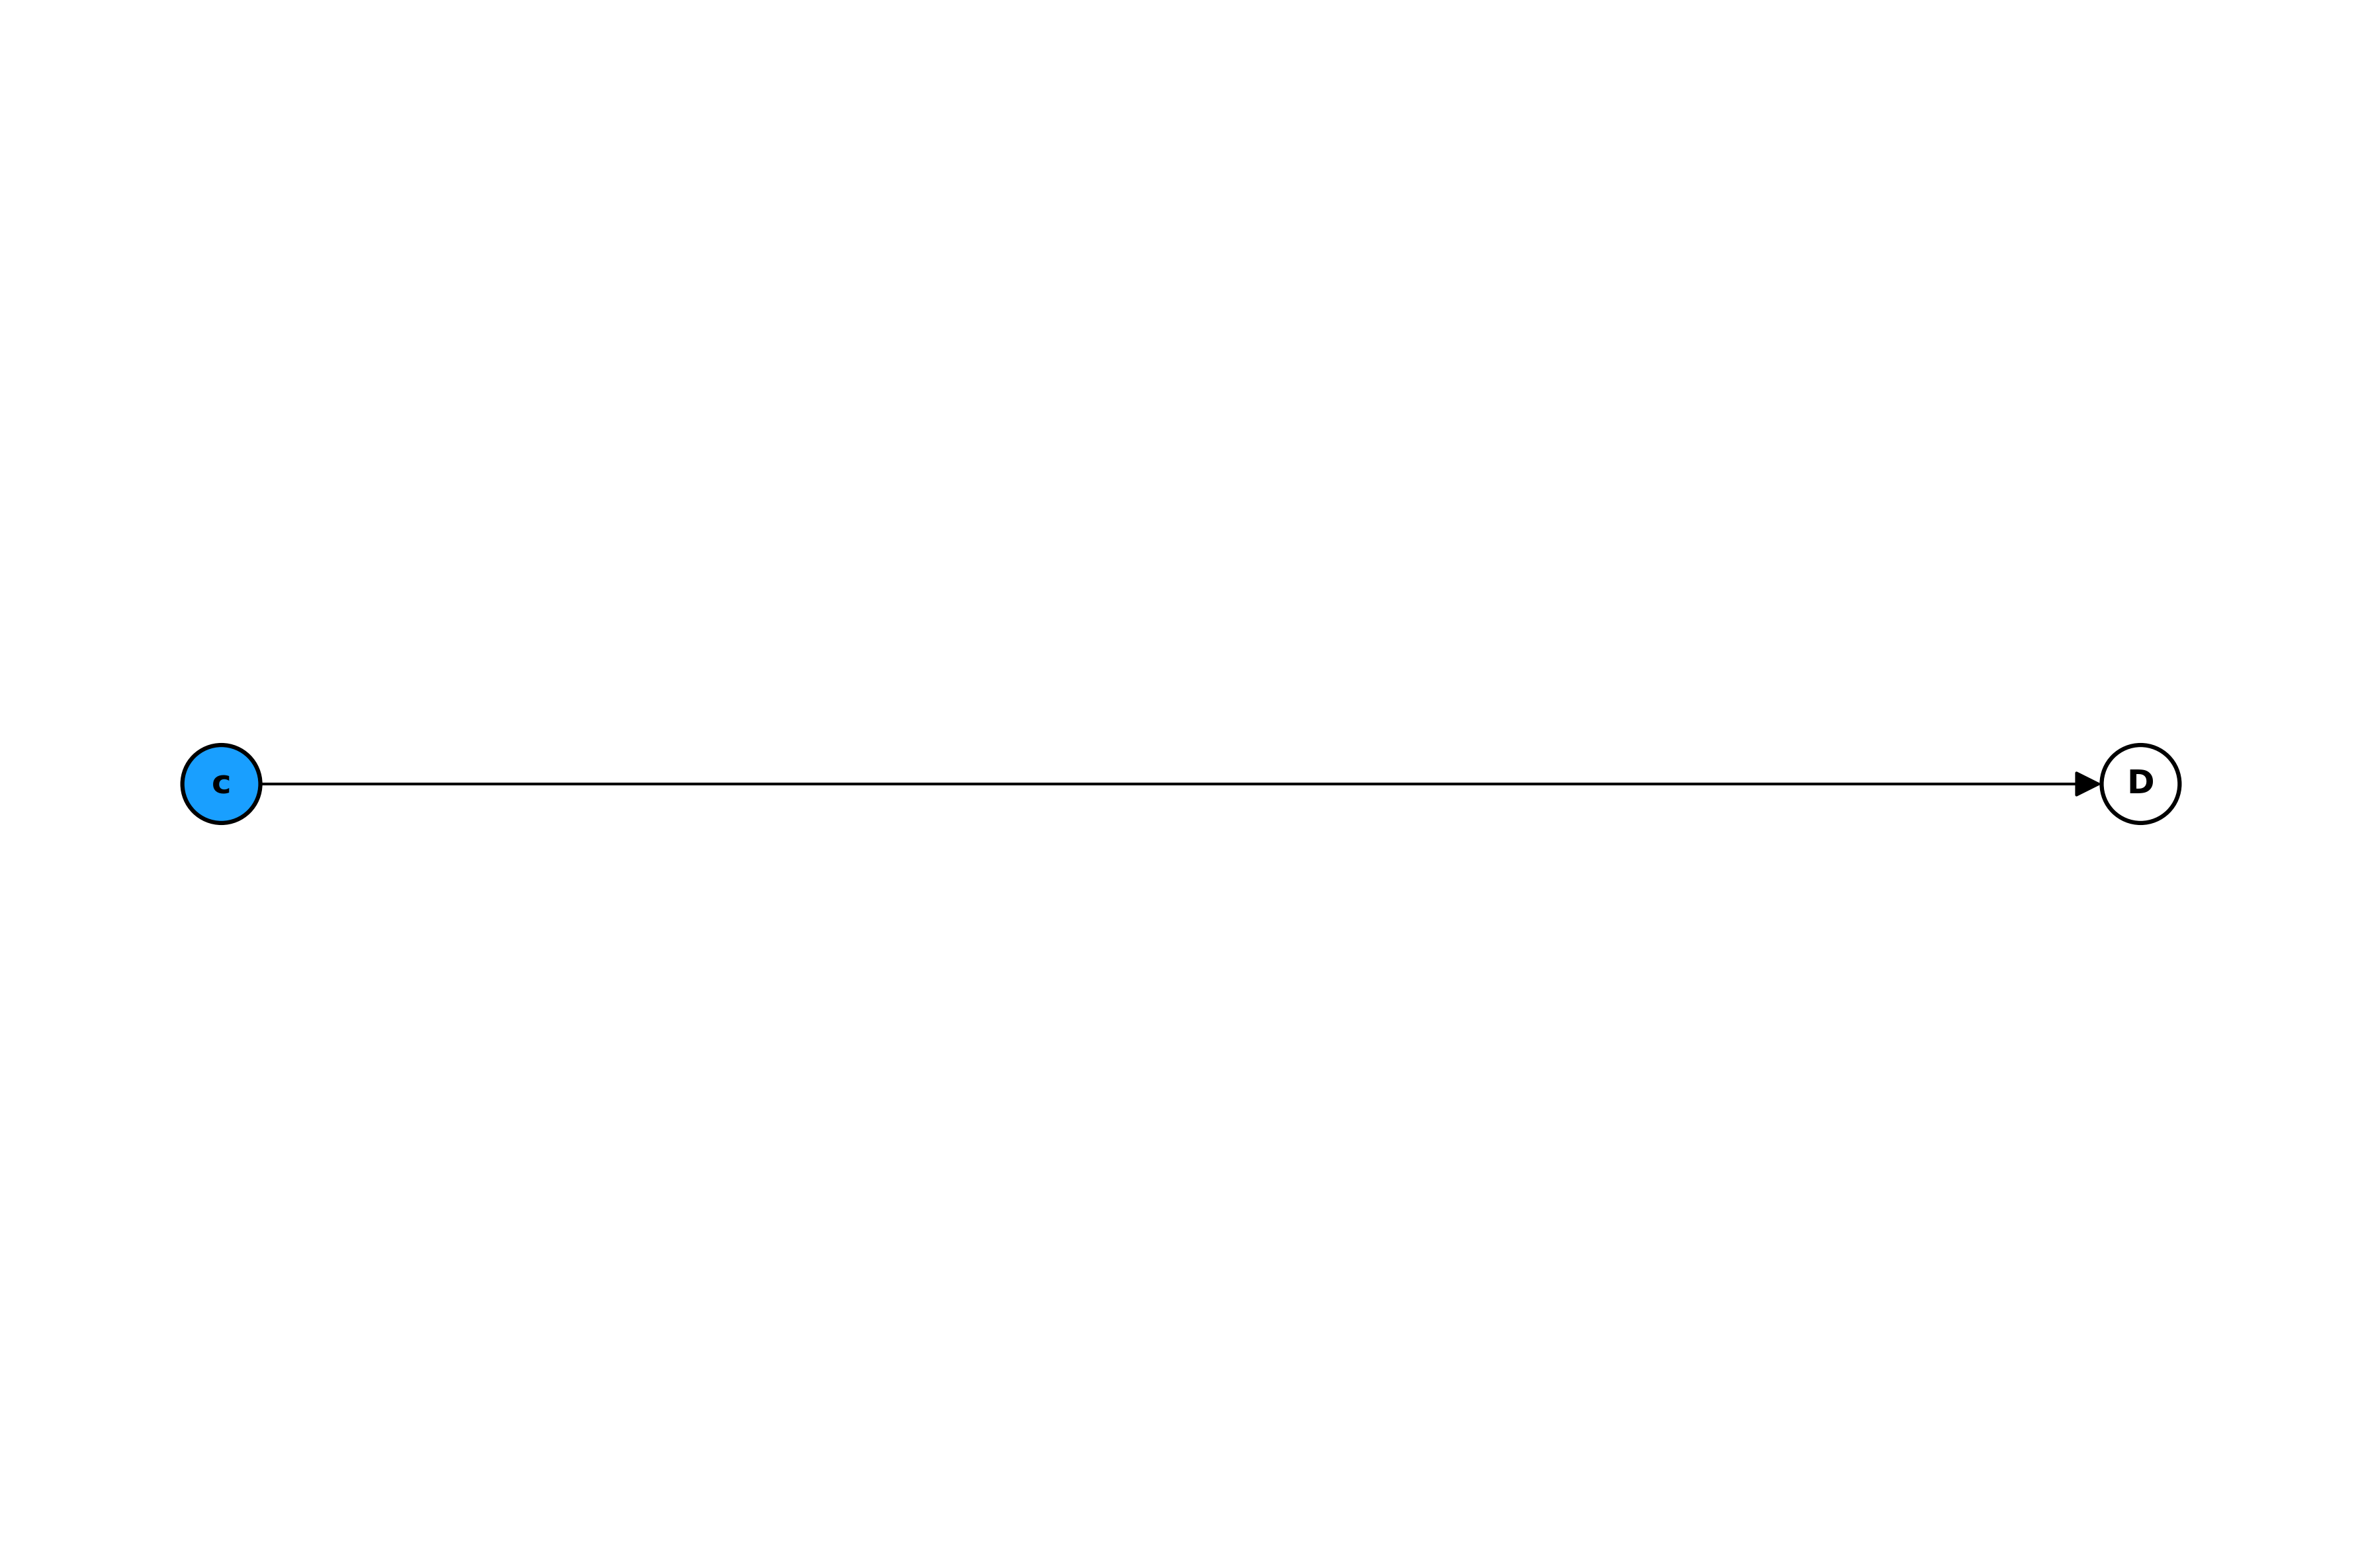

In [57]:
do_vars = {'c'}
induced_vars = {'c', 'D'}

def ex2_cdag():
    B,A,D,E,C,Y= 'B','A','D','E','c','Y'
    return CausalGraph({B,A,D,E,C,Y}, [(A, E), (E, Y), (B, C), (C, E), (C, D), (D, Y)], [(B, Y, 'U_BY'), (A, Y, 'U_AY')])

cdag = ex2_cdag().do(do_vars).induced(induced_vars)
pos = {
    'B': (0,0),
    'A': (1,4),
    'D':(3,0),
    'E':(3,3),
    'Y':(4,2),
    'c':(1,0)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['intervention']: do_vars,                      # Intervention Variable
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

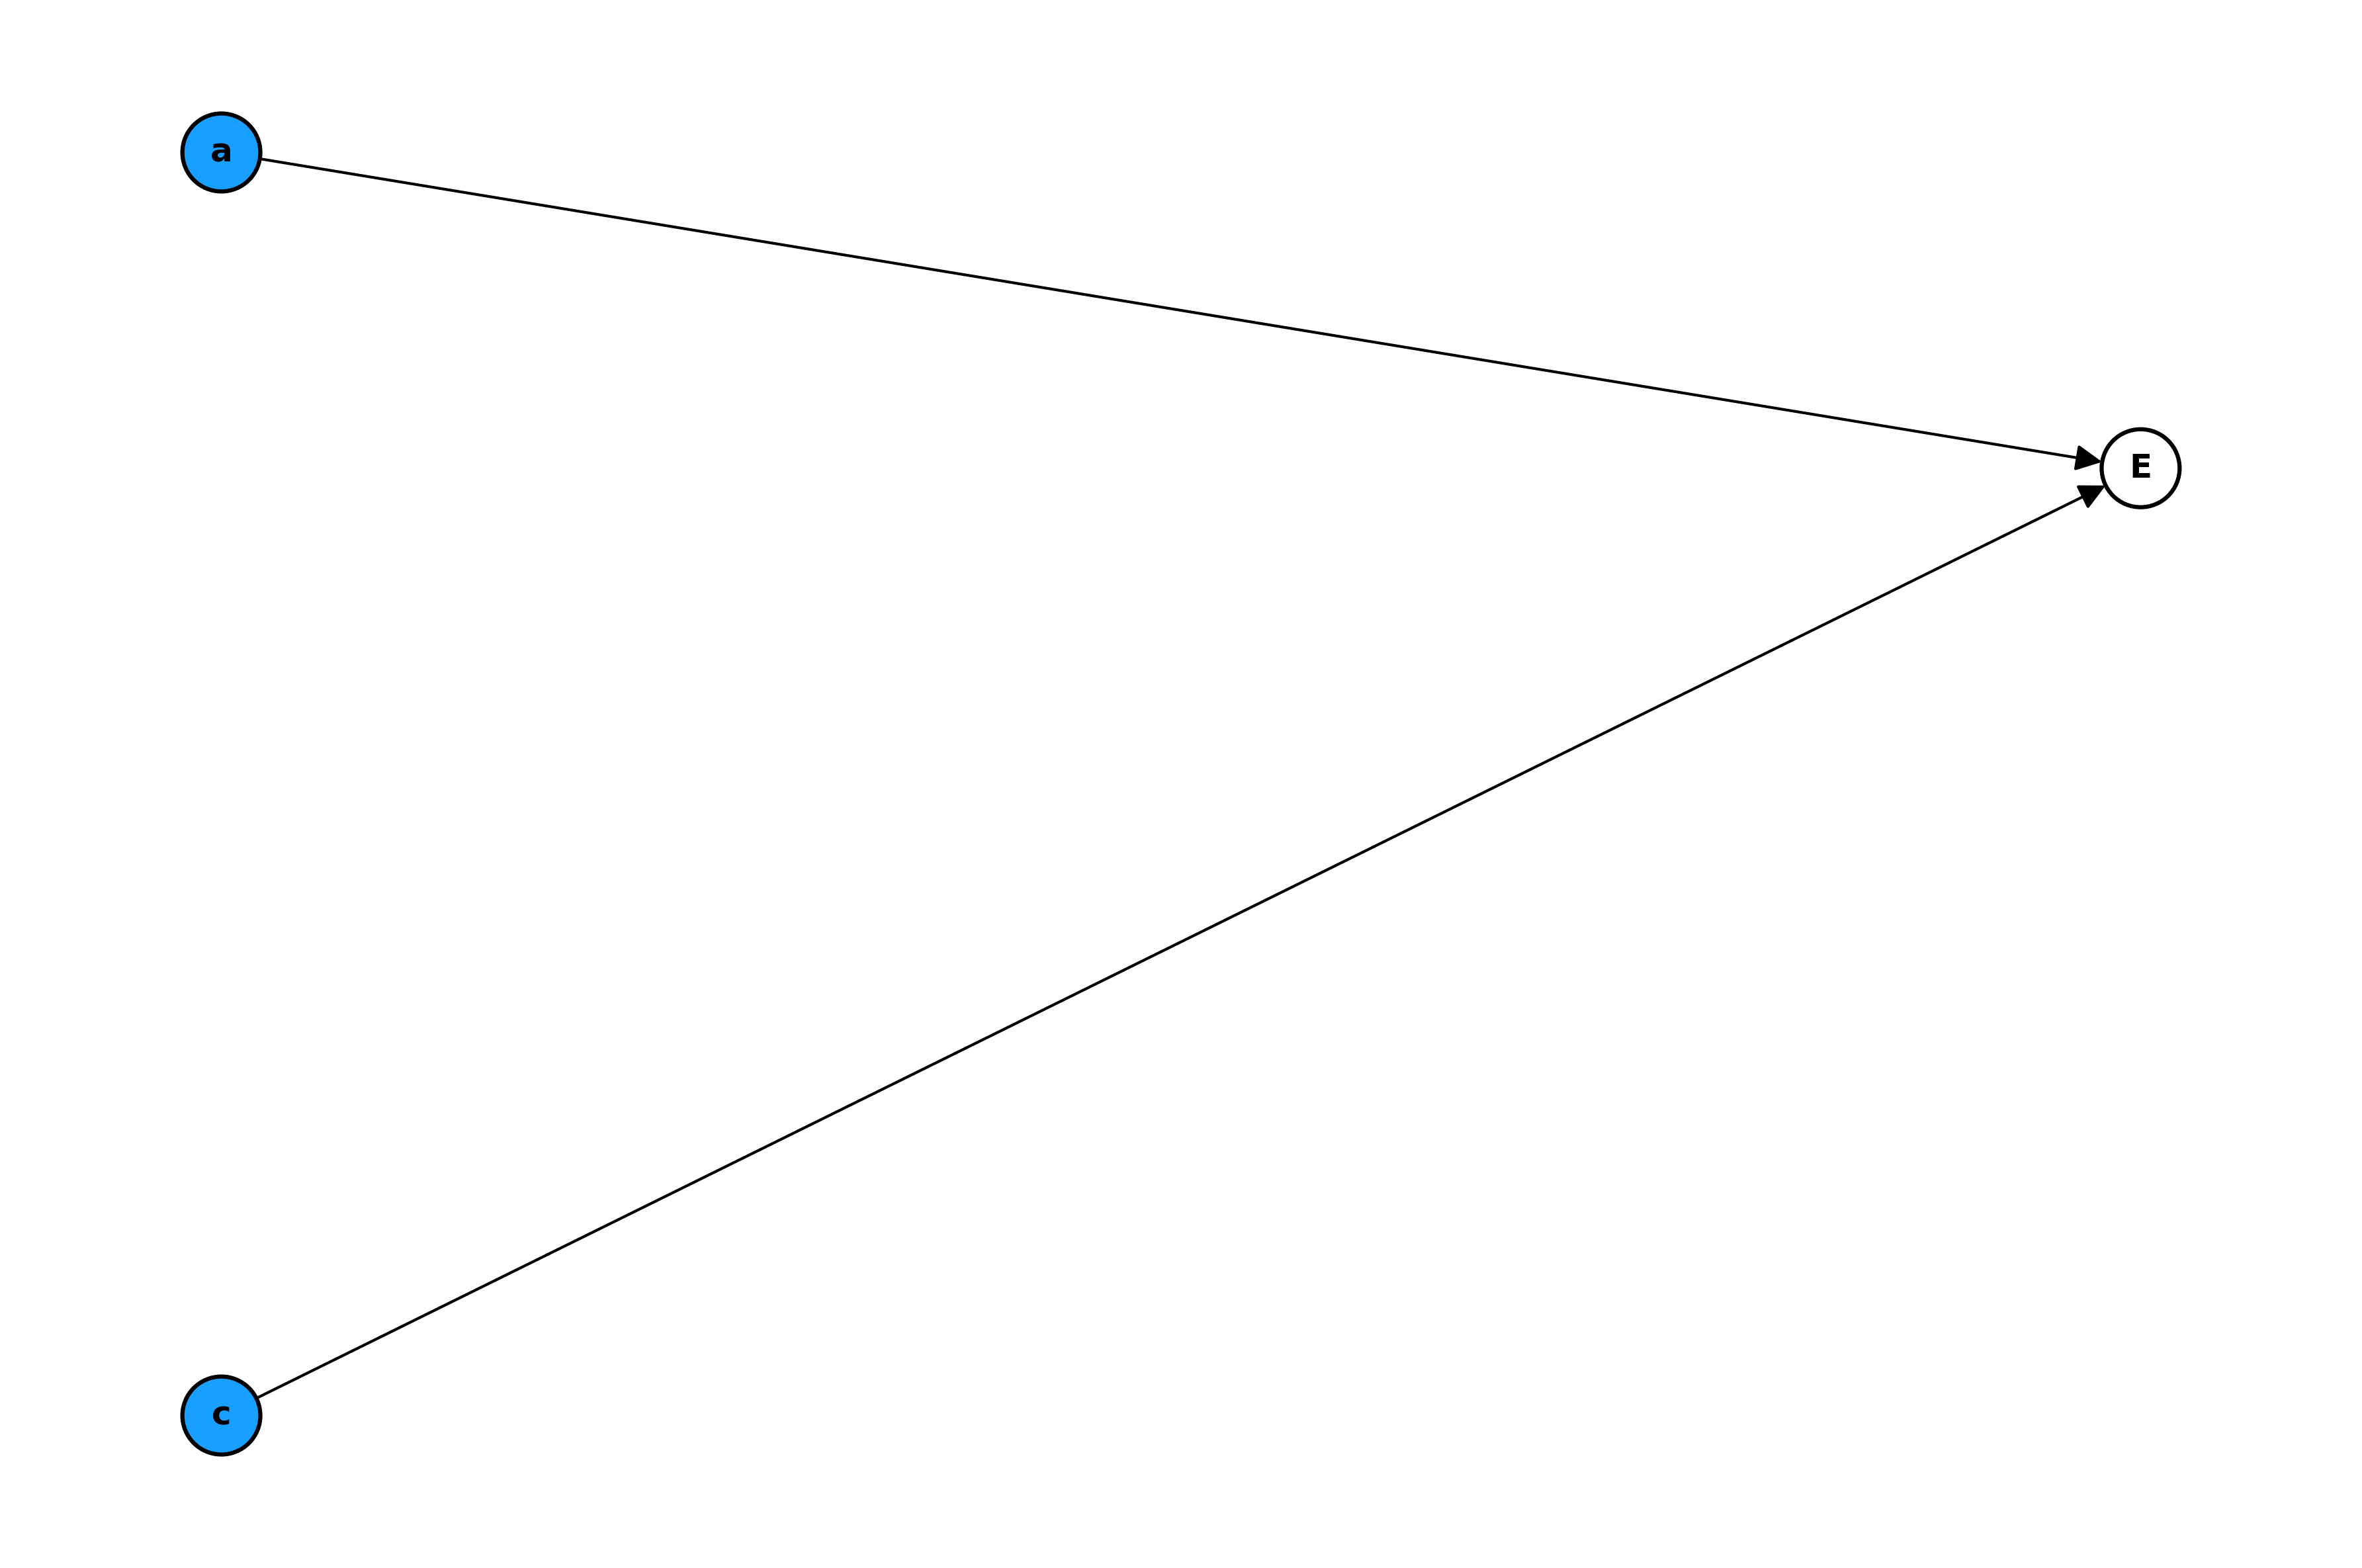

In [58]:
do_vars = {'c', 'a'}
induced_vars = {'c', 'a', 'E'}

def ex2_cdag():
    B,A,D,E,C,Y= 'B','a','D','E','c','Y'
    return CausalGraph({B,A,D,E,C,Y}, [(A, E), (E, Y), (B, C), (C, E), (C, D), (D, Y)], [(B, Y, 'U_BY'), (A, Y, 'U_AY')])

cdag = ex2_cdag().do(do_vars).induced(induced_vars)
pos = {
    'B': (0,0),
    'a': (1,4),
    'D':(3,0),
    'E':(3,3),
    'Y':(4,2),
    'c':(1,0)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['intervention']: do_vars,                      # Intervention Variable
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

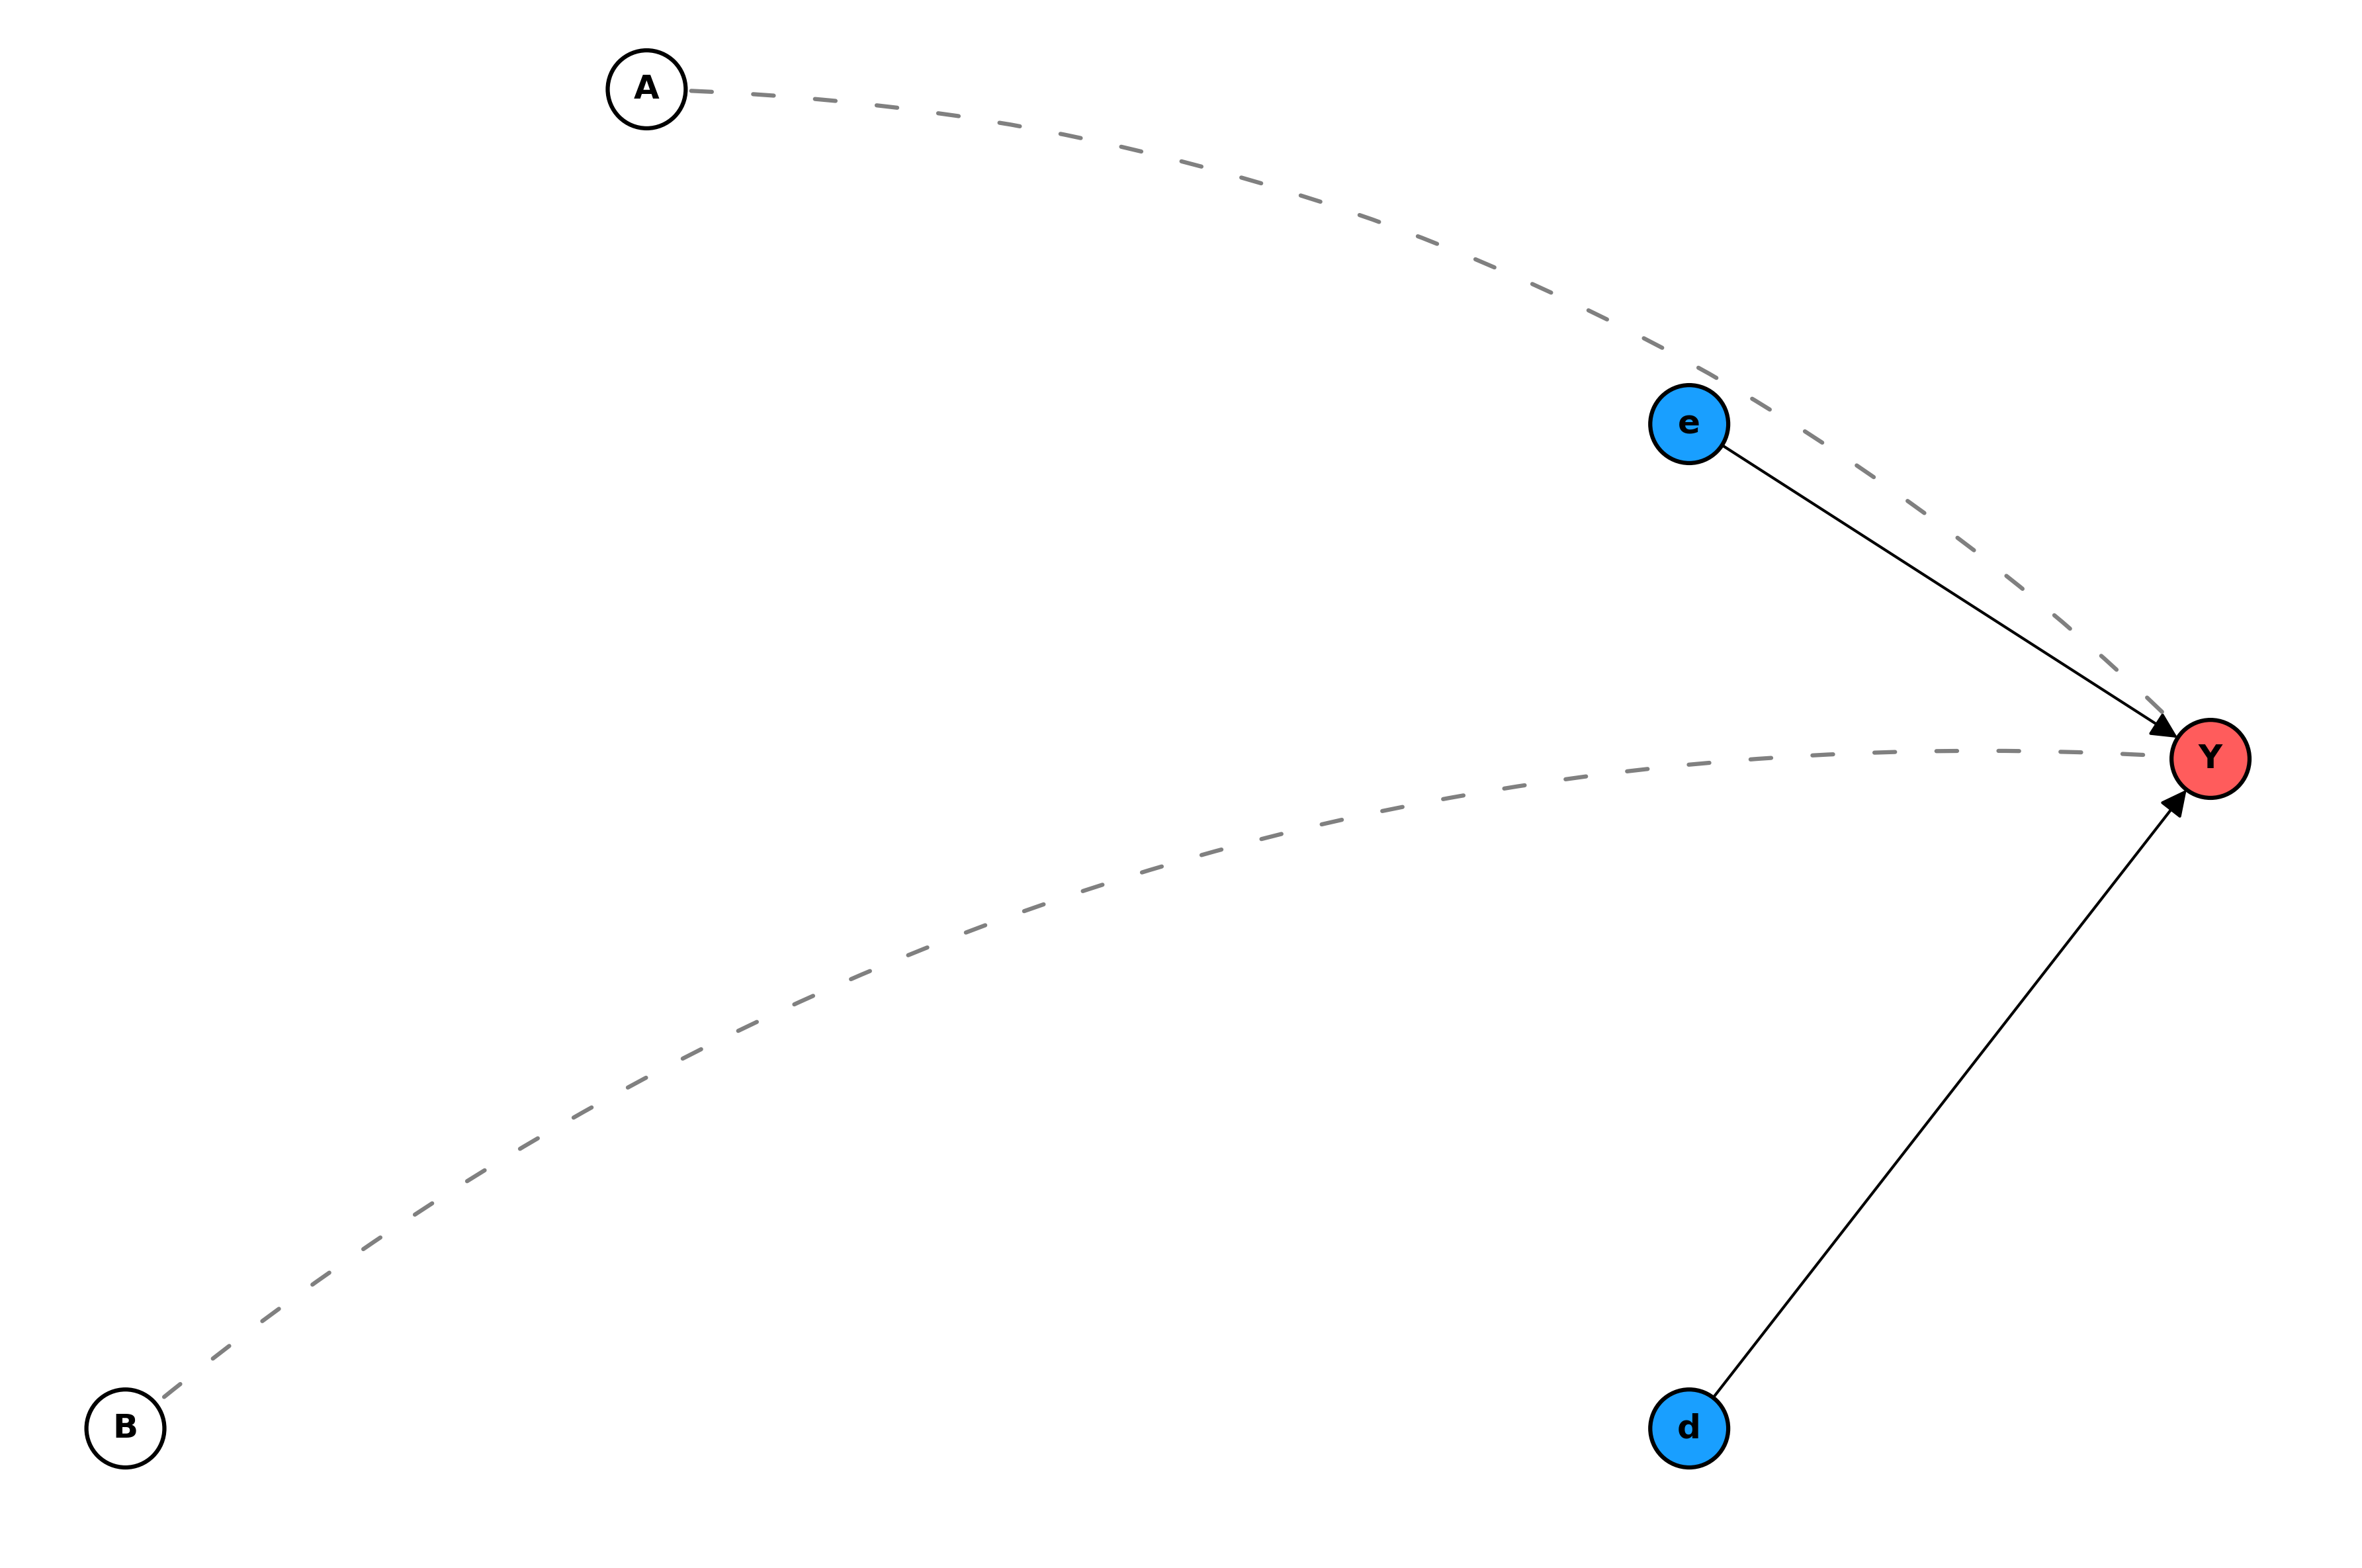

In [59]:
do_vars = {'e', 'd'}
induced_vars = {'e', 'd', 'A', 'B', 'Y'}

def ex2_cdag():
    B,A,D,E,C,Y= 'B','A','d','e','c','Y'
    return CausalGraph({B,A,D,E,C,Y}, [(A, E), (E, Y), (B, C), (C, E), (C, D), (D, Y)], [(B, Y, 'U_BY'), (A, Y, 'U_AY')])

cdag = ex2_cdag().do(do_vars).induced(induced_vars)
pos = {
    'B': (0,0),
    'A': (1,4),
    'd':(3,0),
    'e':(3,3),
    'Y':(4,2),
    'C':(1,0)}

cdag.nx_viz(
    path='./test.png',
    pos=pos,
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        colors['intervention']: do_vars,                      # Intervention Variable
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
    }
)[0]

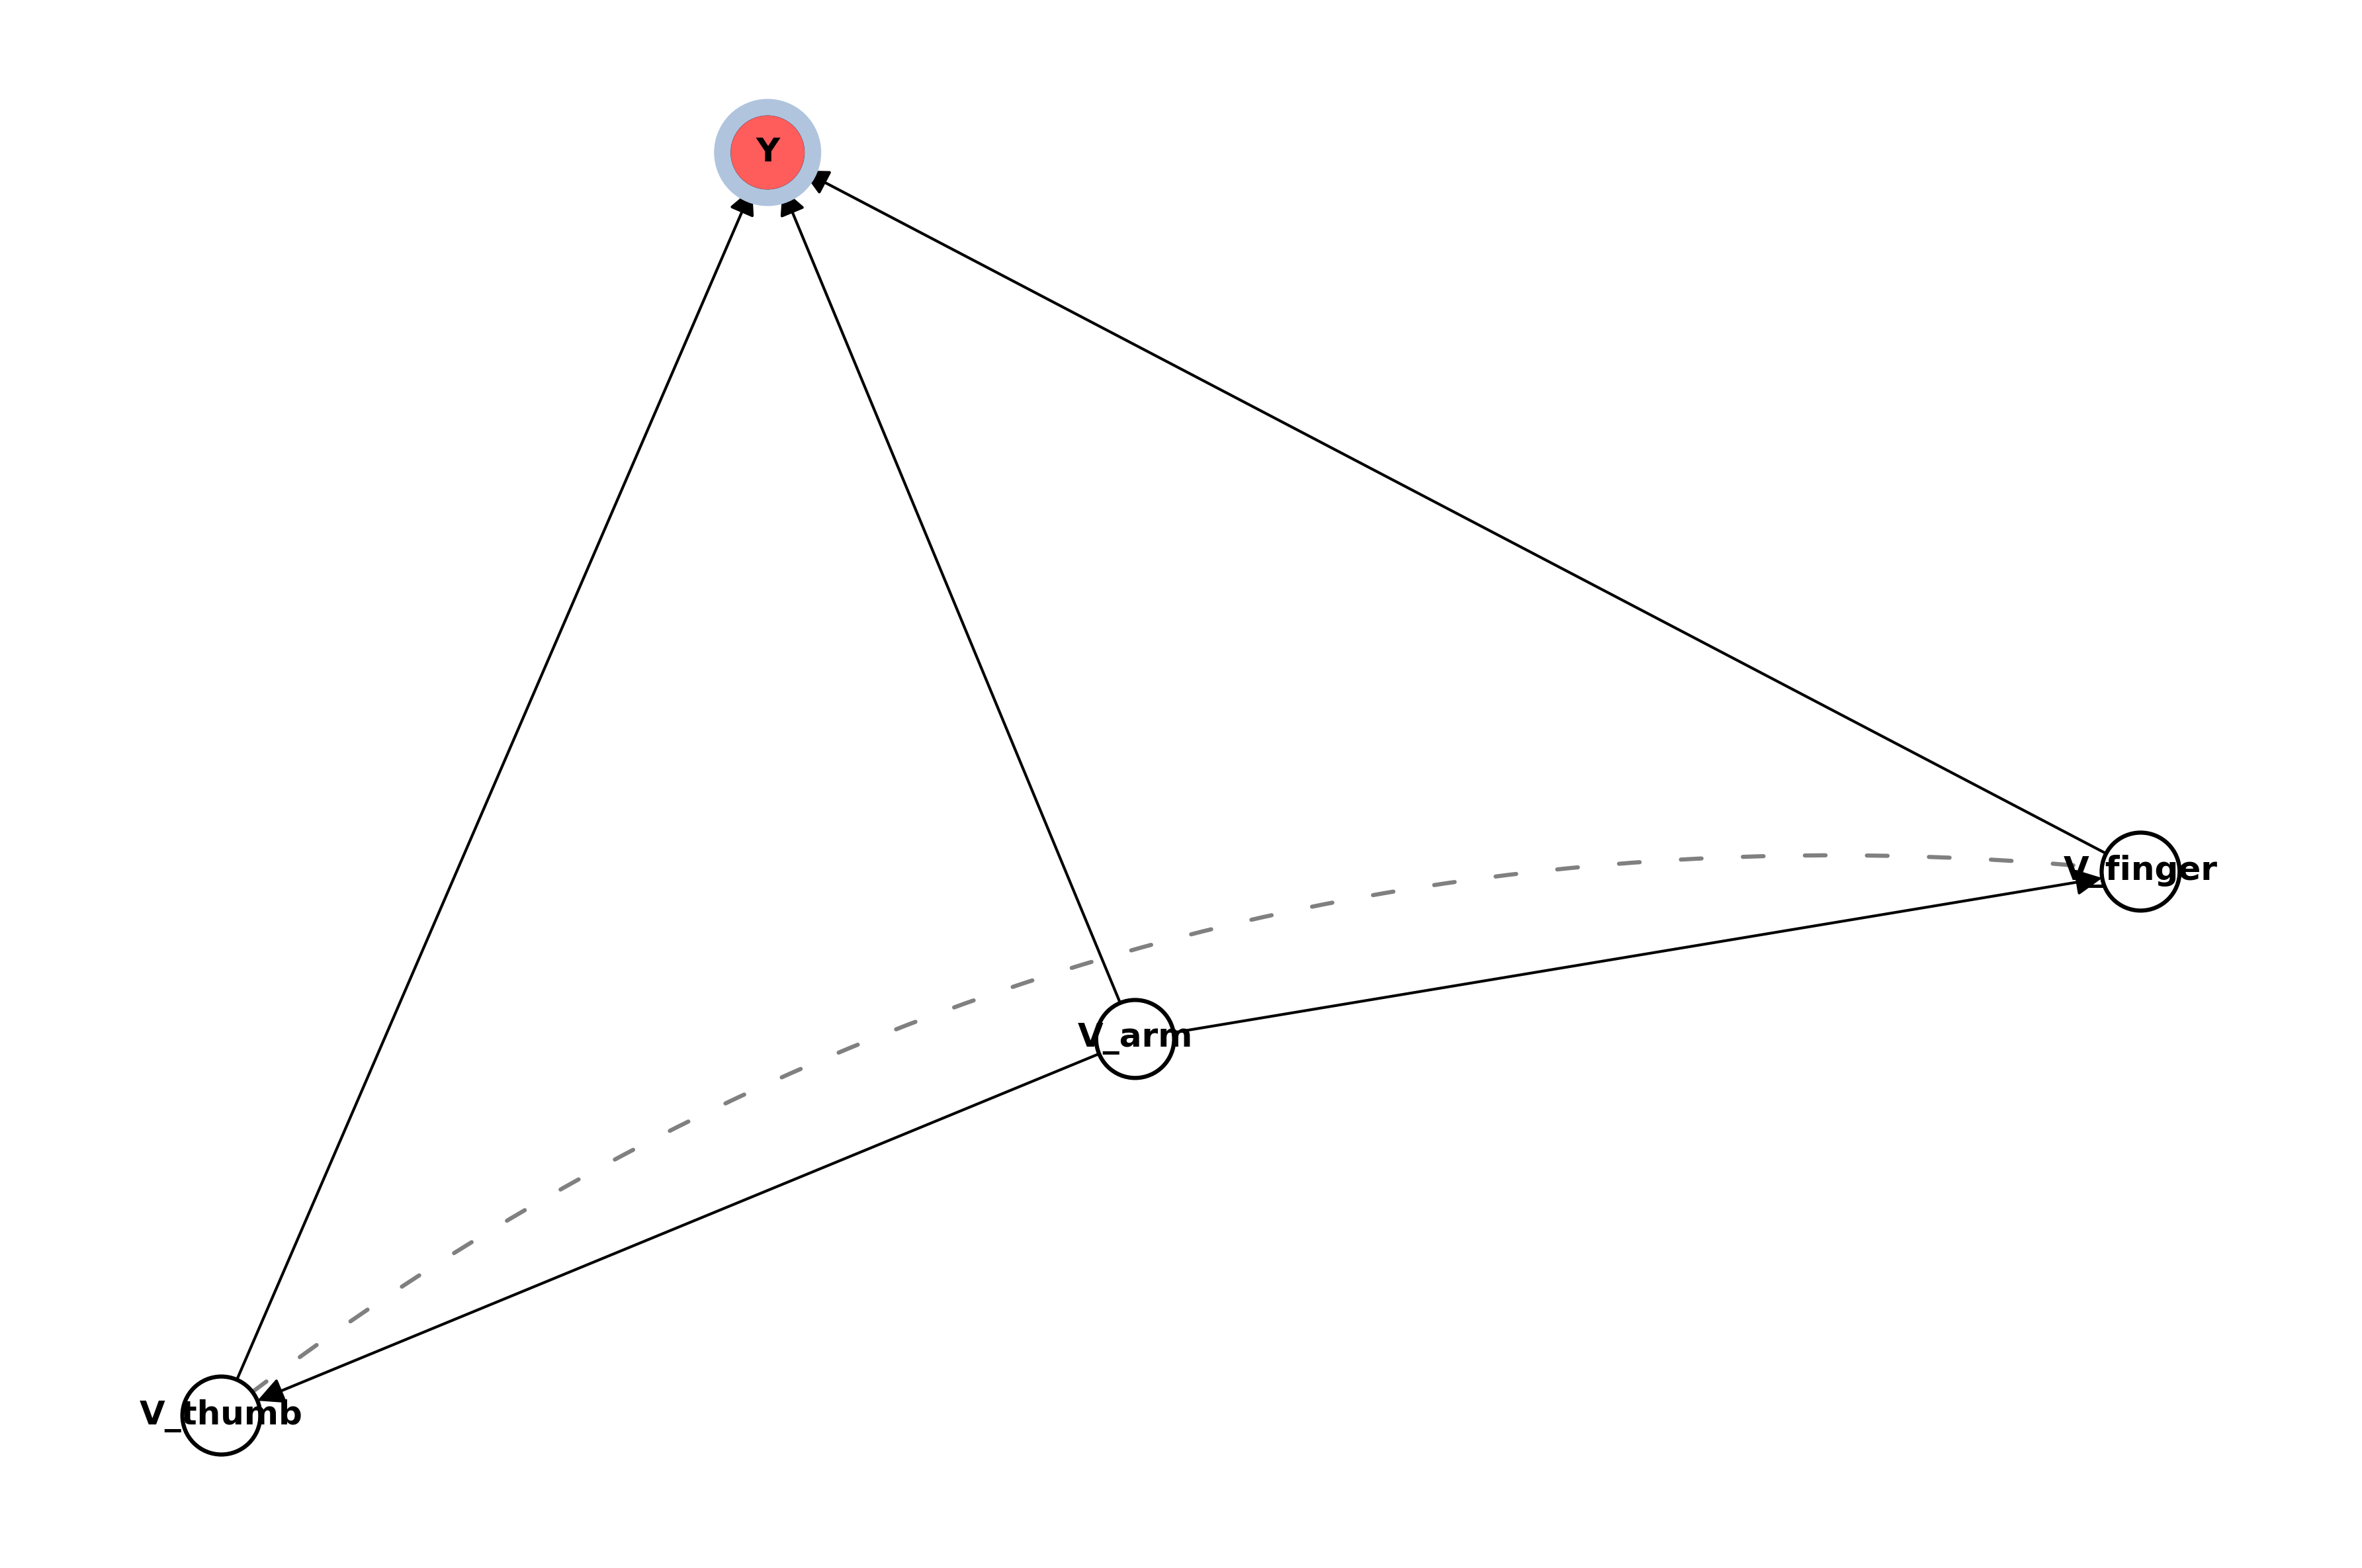

In [15]:
def fig_9_10_cdag():
    V_finger, V_thumb, V_arm, Y = 'V_finger', 'V_thumb', 'V_arm', 'Y'
    return CausalGraph({V_finger, V_thumb, V_arm, Y}, [(V_arm, V_finger), (V_arm, V_thumb), (V_finger, Y), (V_thumb, Y), (V_arm, Y)], [(V_finger, V_thumb, 'U_joint')])
cdag = fig_9_10_cdag()
# pos = {
#     'x1': (0,6),
#     'Z': (0,5),
#     'X2':(0,4),
#     'X3':(0,3),
#     'X4':(0,2),
#     'Y':(0,1)
#     }
task = WhereDo()
cdag.nx_viz(
    path='./test.png',
    # pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'Y')),  # MUCT
        colors['target']: 'Y',                            # Target
        # colors['IB']: flatten(task.IB(cdag, 'Y')),    # Intevention Boundary
        # colors['intervention']: flatten(task.POMISs(cdag, 'Y')),                      # Intervention Variable
    }
)[0]

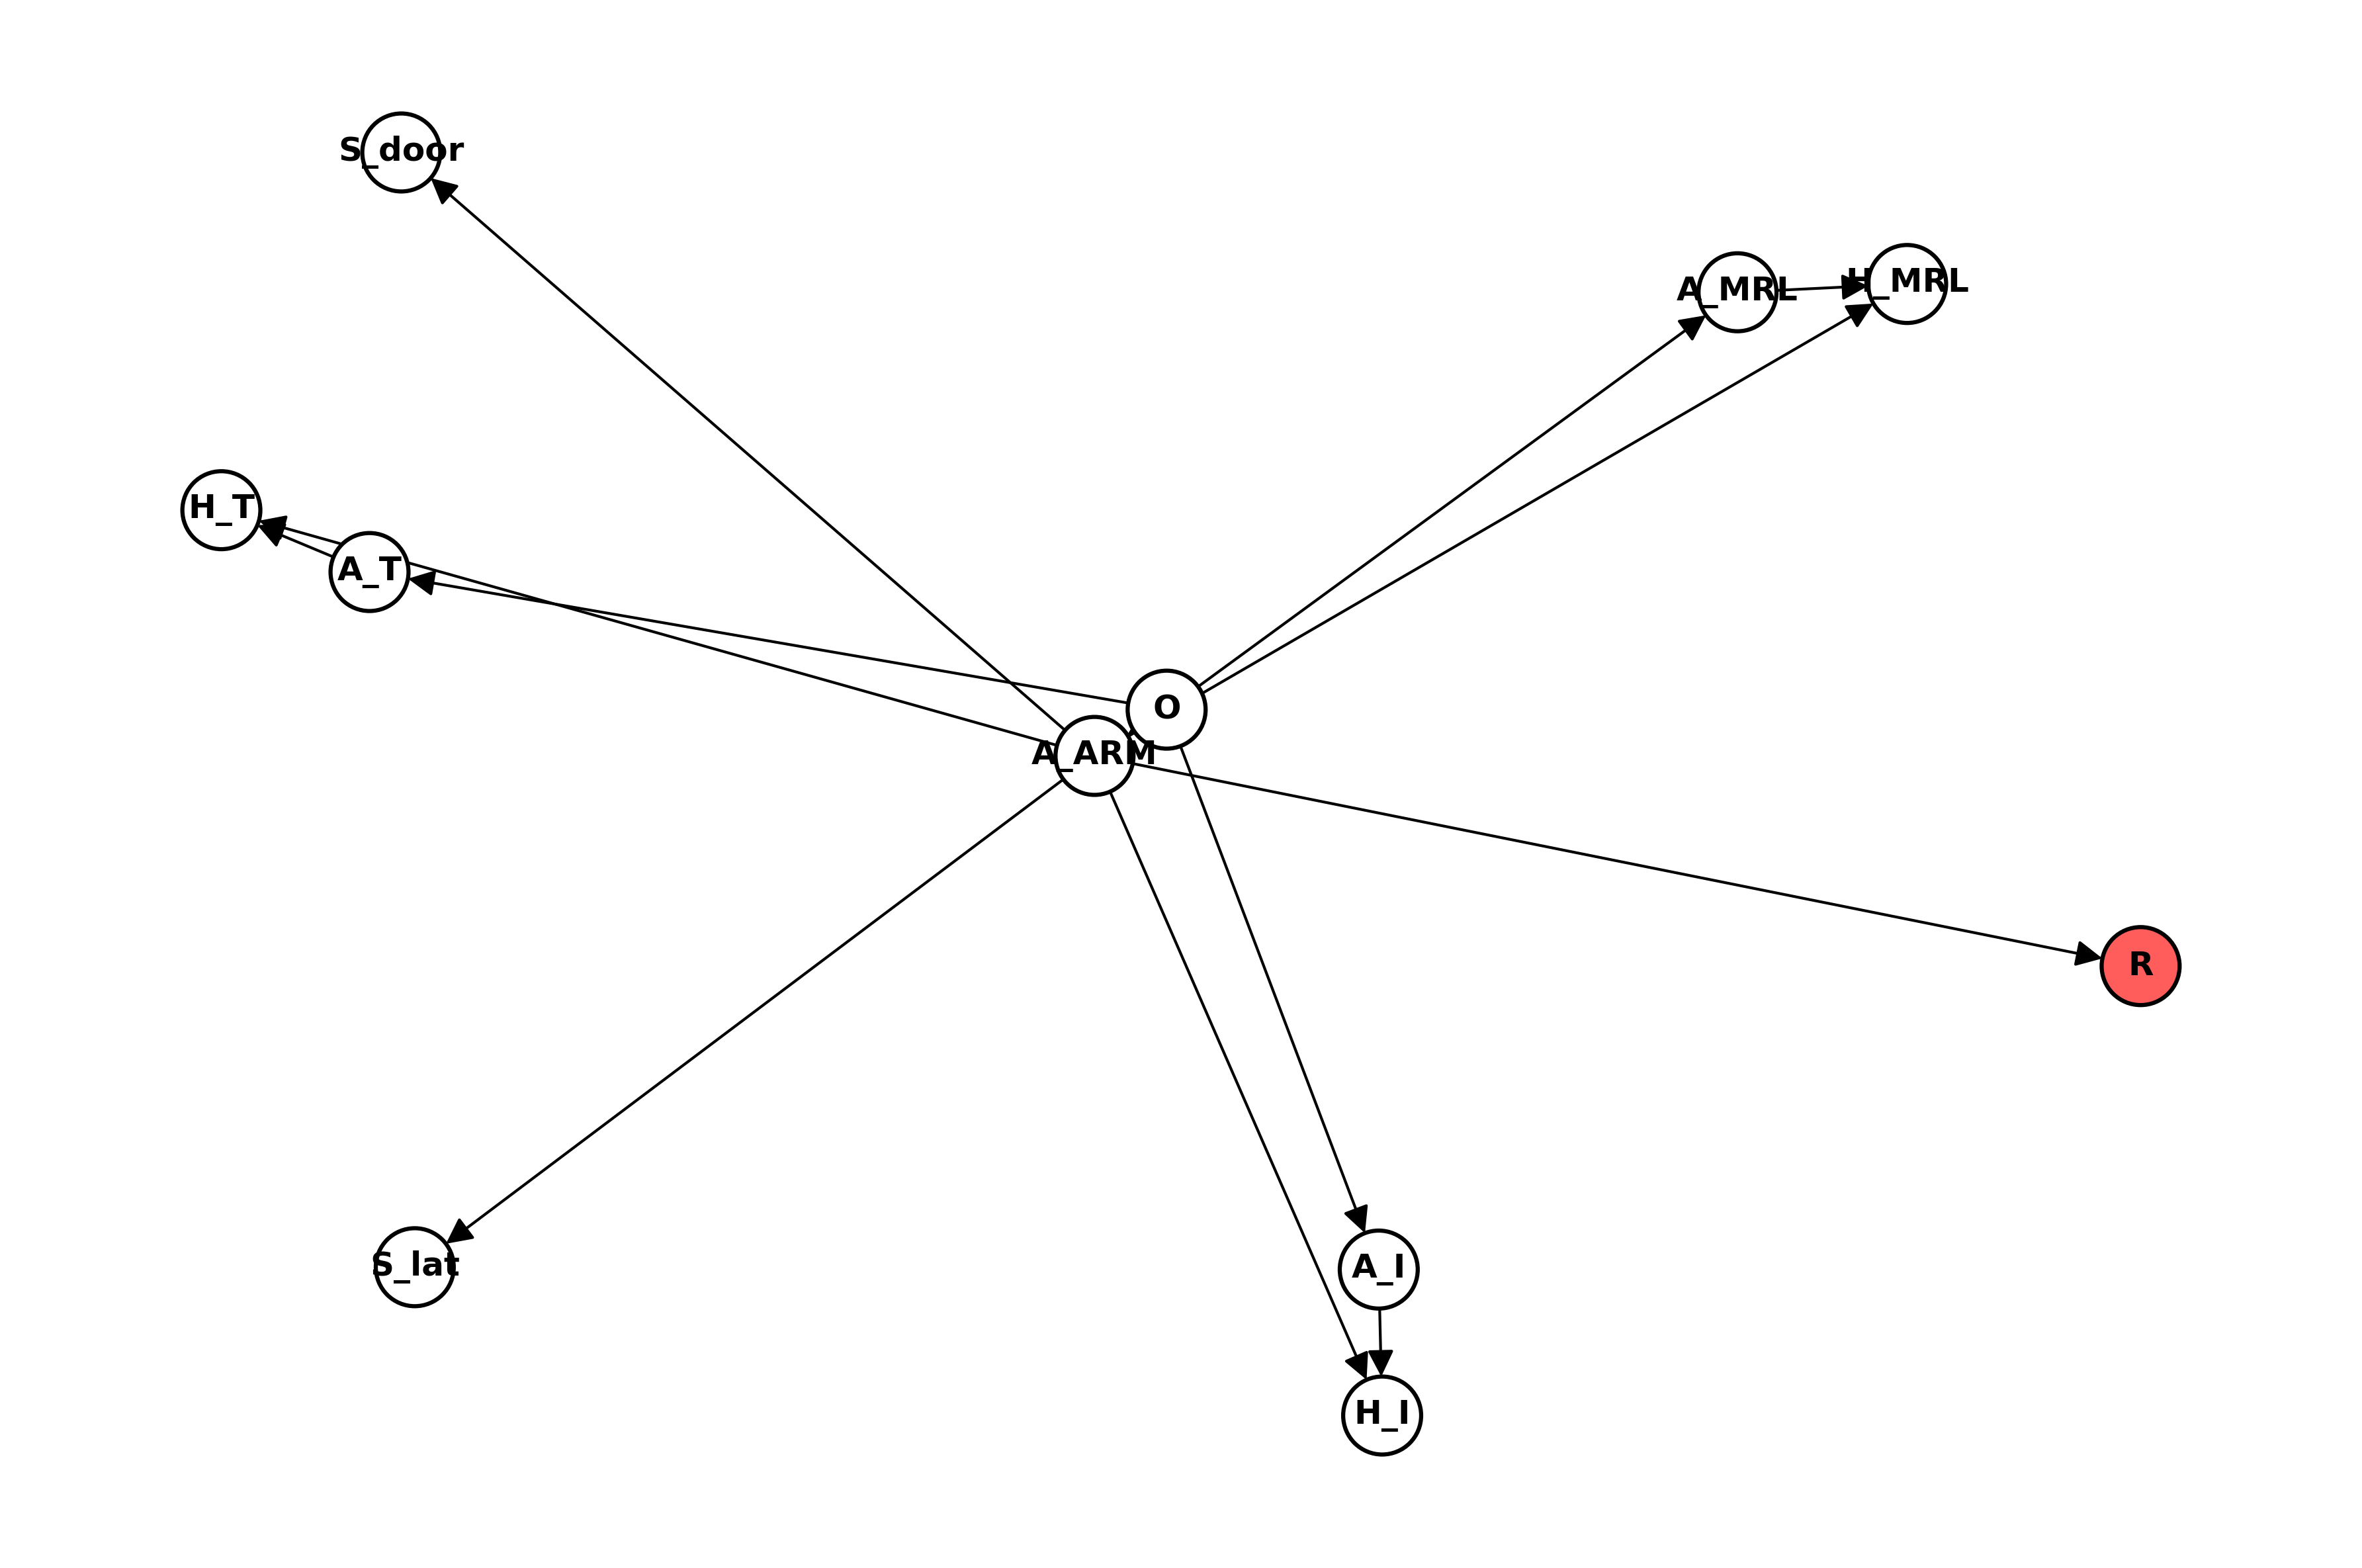

In [20]:
def adroit_door_cdag():
    # Define all nodes in the graph
    nodes = {
        # 'U_init', 'U_fric_T', 'U_fric_I', 'U_gain_MRL', 'U_bias',  # Exogenous variables
        'O',  # Observation
        'A_T', 'A_I', 'A_MRL', 'A_ARM',  # Actions
        'H_T', 'H_I', 'H_MRL',  # Hand poses
        'S_lat', 'S_door',  # State variables
        'R'  # Reward
    }
    
    # Define directed edges (causal relationships)
    edges = [
        # ('U_init', 'O'), ('U_init', 'R'),  # Door pose influences
        # ('U_fric_T', 'H_T'), ('U_fric_T', 'S_lat'),  # Thumb friction influences
        # ('U_fric_I', 'H_I'), ('U_fric_I', 'S_lat'),  # Index friction influences
        # ('U_gain_MRL', 'H_MRL'), ('U_gain_MRL', 'S_door'),  # Tendon gain influences
        # ('U_bias', 'S_door'),  # Hinge bias influence
        ('O', 'A_T'), ('O', 'A_I'), ('O', 'A_MRL'), ('O', 'A_ARM'),  # Observation influences
        ('A_T', 'H_T'),  # Thumb action influence
        ('A_I', 'H_I'),  # Index action influence
        ('A_MRL', 'H_MRL'),  # Middle-ring-little action influence
        ('A_ARM', 'H_T'), ('A_ARM', 'H_I'), ('A_ARM', 'H_MRL'),  # Arm influences on hand
        ('A_ARM', 'S_lat'), ('A_ARM', 'S_door'), ('A_ARM', 'R'),  # Arm influences on state and reward
        # ('H_T', 'O'), ('H_T', 'S_lat'), ('H_T', 'R'),  # Thumb pose influences
        # ('H_I', 'O'), ('H_I', 'S_lat'), ('H_I', 'R'),  # Index pose influences
        # ('H_MRL', 'O'), ('H_MRL', 'S_door'),  # Middle-ring-little pose influences
        # ('S_lat', 'O'), ('S_lat', 'S_door'),  # Latch angle influences
        # ('S_door', 'O'), ('S_door', 'R')  # Door angle influences
    ]
    
    # Define bidirected edges (unobserved confounders)
    # Note: The matrix doesn't explicitly show these, but from the notes we know about shared confounders
    # bidirected_edges = [
    #     ('H_T', 'S_lat', 'U_fric_T'),  # Thumb friction as confounder
    #     ('H_I', 'S_lat', 'U_fric_I'),  # Index friction as confounder
    #     ('H_MRL', 'S_door', 'U_gain_MRL'),  # Tendon gain as confounder
    # ]
    
    return CausalGraph(nodes, edges)

# Create the graph
cdag = adroit_door_cdag()

# Visualize the graph
task = WhereDo()
cdag.nx_viz(
    path='./adroit_door_causal.png',
    node_color_map={
        # colors['MUCT']: flatten(task.MUCT(cdag, 'R')),  # MUCT
        colors['target']: 'R',                          # Target
    }
)[0]

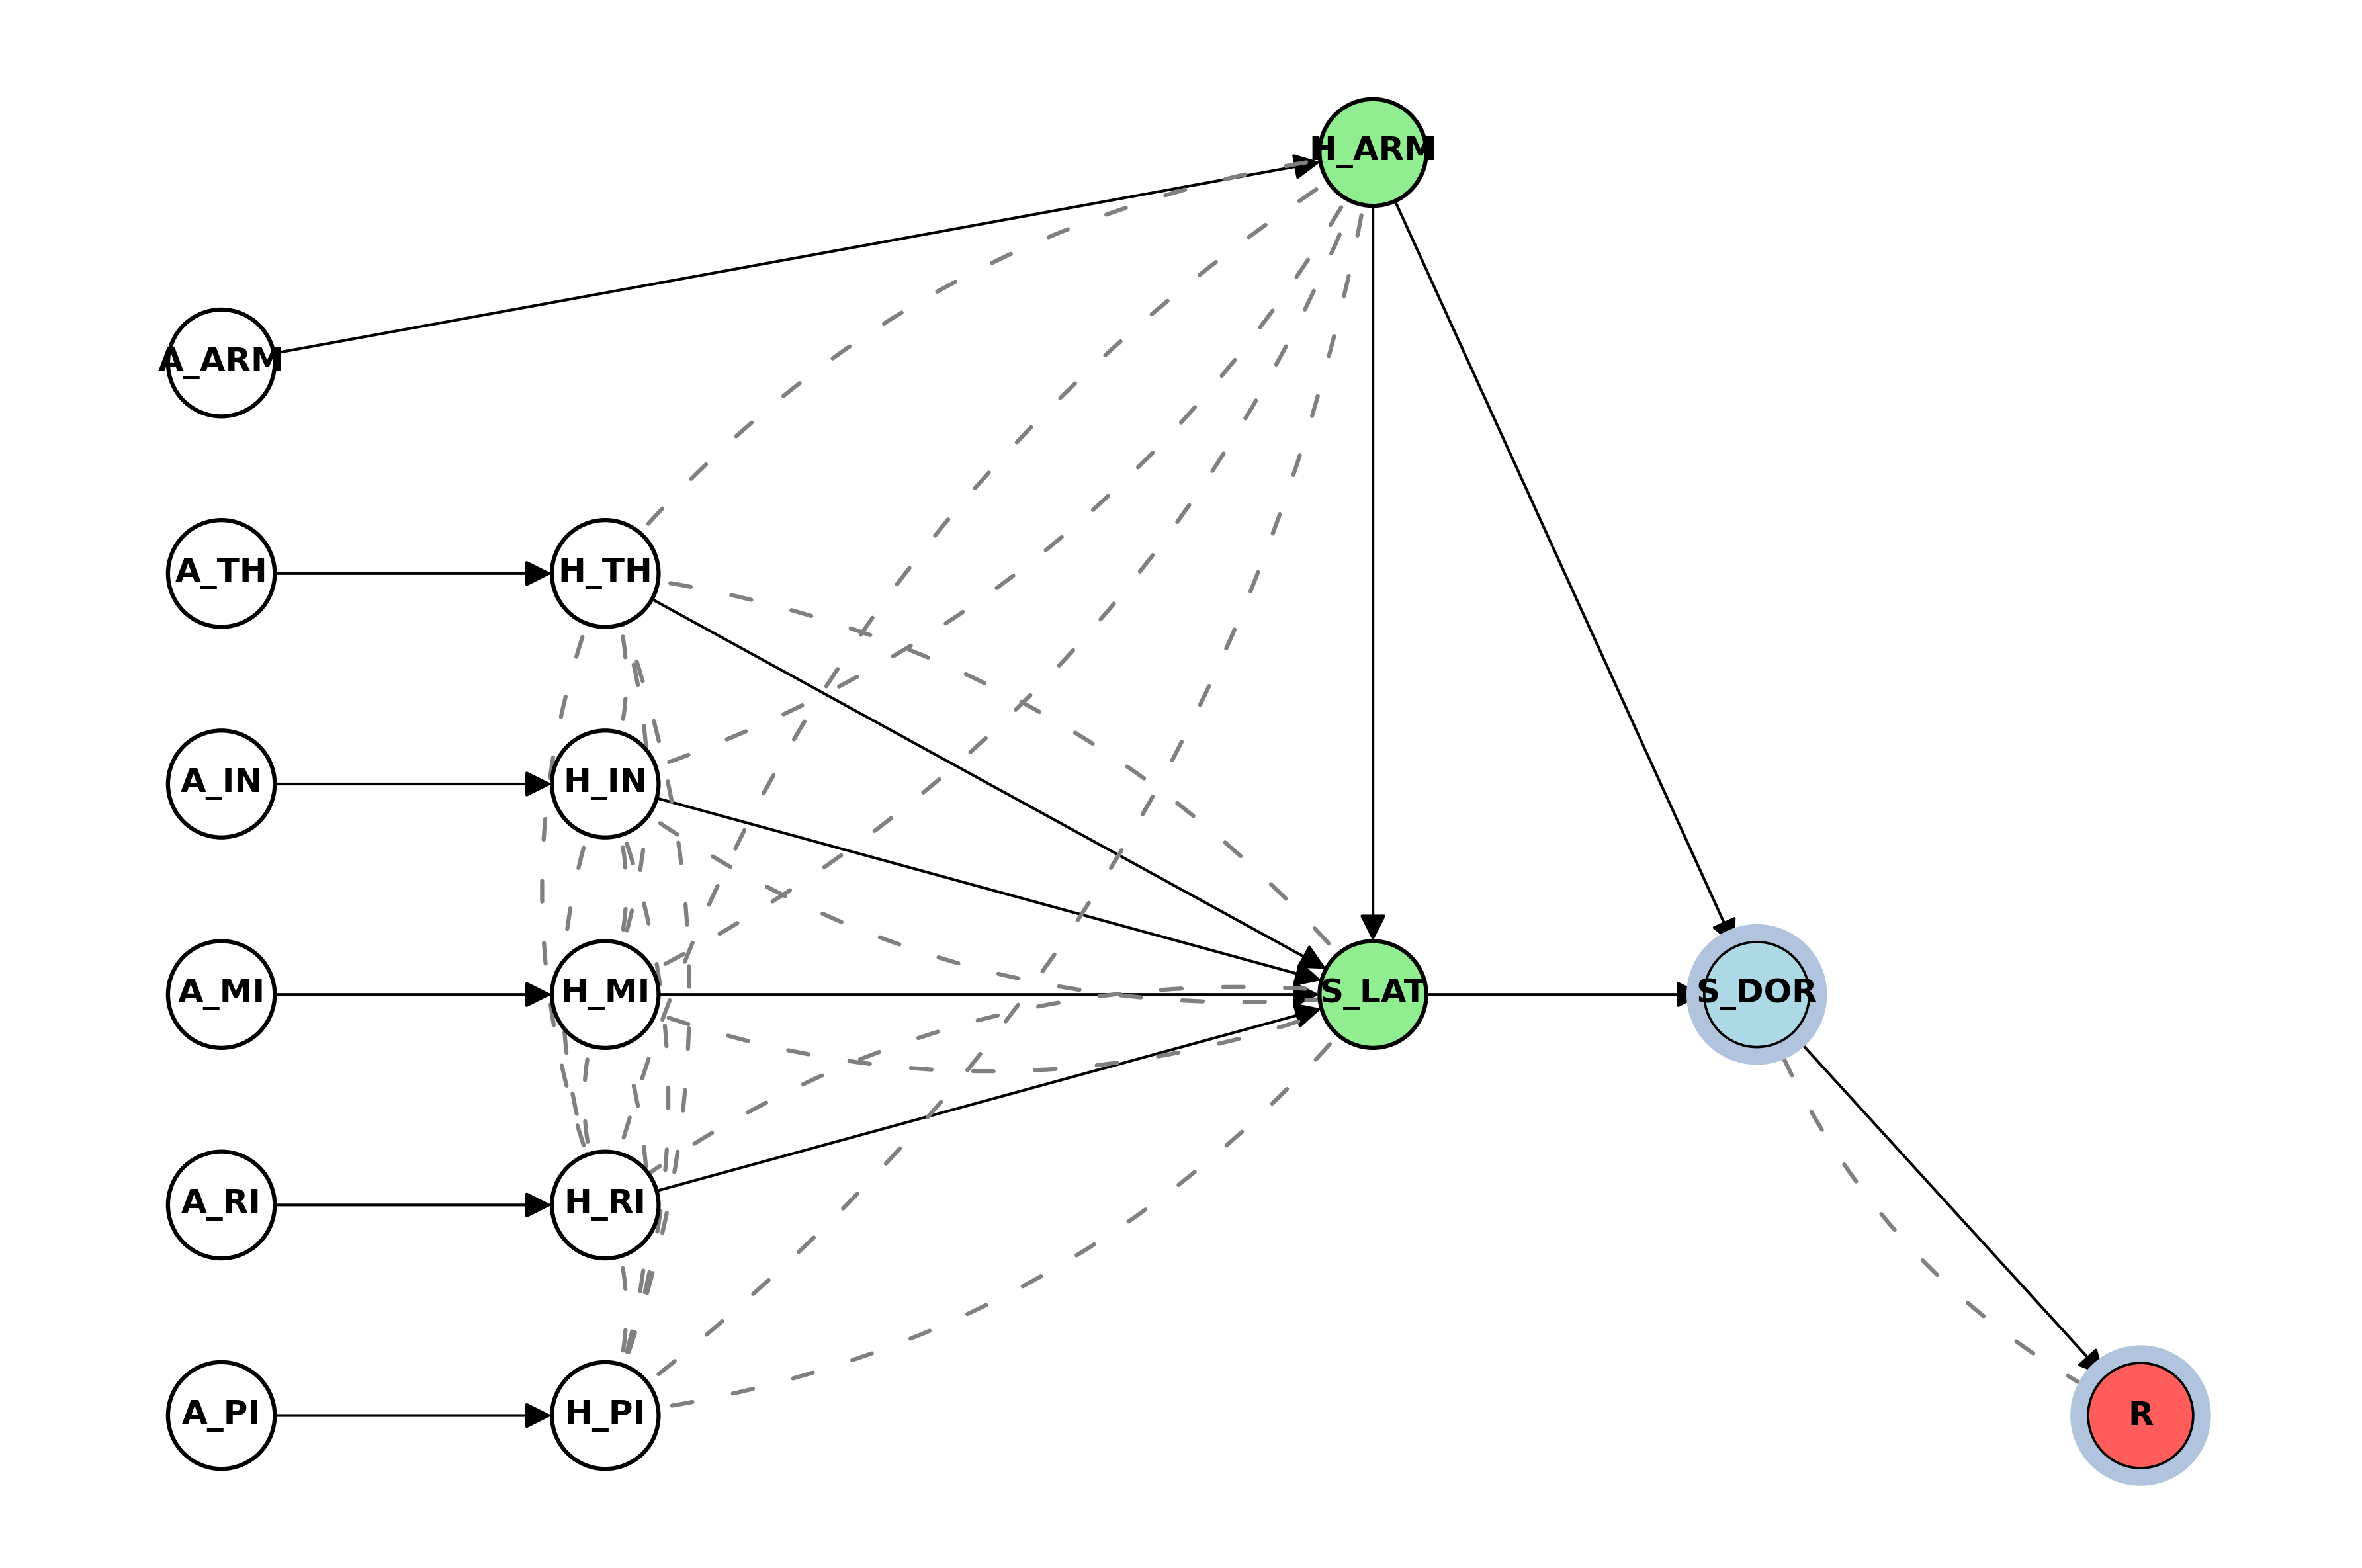

In [ ]:
def hand_cdag():
    # Define all nodes in the graph
    nodes = {
        # Latent environment factors
        # 'E_init', 'E_bias', 'E_fric_TH', 'E_fric_IN', 'E_fric_MI', 'E_fric_RI',
        
        # Actions at time t
        'A_TH', 'A_IN', 'A_MI', 'A_RI', 'A_PI', 'A_ARM',
        
        # Hand pose at t+1
        'H_TH', 'H_IN', 'H_MI', 'H_RI', 'H_PI', 'H_ARM',
        
        # State at t+1
        'S_LAT', 'S_DOR',
        
        # Reward at t+1
        'R'
    }
    
    # Define directed edges (cause -> effect, forward in time)
    edges = [
        # Environment to reward and state
        # ('E_init', 'R'),
        # ('E_bias', 'S_DOR'),

        # ('E_fric_TH', 'H_TH'),
        # ('E_fric_TH', 'S_LAT'),

        # ('E_fric_IN', 'H_IN'),
        # ('E_fric_IN', 'S_LAT'),

        # ('E_fric_MI', 'H_MI'),
        # ('E_fric_MI', 'S_LAT'),

        # ('E_fric_RI', 'H_RI'),
        # ('E_fric_RI', 'S_LAT'),

        # Actions to hand pose
        ('A_TH', 'H_TH'),
        ('A_IN', 'H_IN'),
        ('A_MI', 'H_MI'),
        ('A_RI', 'H_RI'),
        ('A_PI', 'H_PI'),
        ('A_ARM', 'H_ARM'),

        # Hand pose to latch/door state
        ('H_TH', 'S_LAT'),
        ('H_IN', 'S_LAT'),
        ('H_MI', 'S_LAT'),
        ('H_RI', 'S_LAT'),
        ('H_ARM', 'S_LAT'),
        ('H_ARM', 'S_DOR'),
        # ('H_PI', 'S_LAT'),

        # State transitions
        ('S_LAT', 'S_DOR'),
        ('S_DOR', 'R')
    ]
    
    # Define bidirected edges (confounders between observed variables)
    bidirected_edges = [
        ('H_TH', 'S_LAT', 'E_fric_TH'),
        ('H_IN', 'S_LAT', 'E_fric_IN'),
        ('H_MI', 'S_LAT', 'E_fric_MI'),
        ('H_RI', 'S_LAT', 'E_fric_RI'),
        ('H_PI', 'S_LAT', 'E_fric_PI'),
        ('H_ARM', 'S_DOR', 'E_bias_ARM'),
        ('H_PI', 'H_RI', 'E_rigid_PI_RI'),
        ('H_PI', 'H_MI', 'E_rigid_PI_MI'),
        ('H_PI', 'H_IN', 'E_rigid_PI_IN'),
        ('H_PI', 'H_TH', 'E_rigid_PI_TH'),
        ('H_PI', 'H_ARM', 'E_rigid_PI_ARM'),
        ('H_RI', 'H_MI', 'E_rigid_RI_MI'),
        ('H_RI', 'H_IN', 'E_rigid_RI_IN'),
        ('H_RI', 'H_TH', 'E_rigid_RI_TH'),
        ('H_RI', 'H_ARM', 'E_rigid_RI_ARM'),
        ('H_MI', 'H_IN', 'E_rigid_MI_IN'),
        ('H_MI', 'H_TH', 'E_rigid_MI_TH'),
        ('H_MI', 'H_ARM', 'E_rigid_MI_ARM'),
        ('H_IN', 'H_TH', 'E_rigid_IN_TH'),
        ('H_IN', 'H_ARM', 'E_rigid_IN_ARM'),
        ('H_TH', 'H_ARM', 'E_rigid_TH_ARM'),
        ('S_DOR', 'R', 'E_penal')
    ]
    
    return CausalGraph(nodes, edges, bidirected_edges)

pos = {
    'A_PI': (0, 0),
    'A_RI': (0, 1),
    'A_MI': (0, 2),
    'A_IN': (0, 3),
    'A_TH': (0, 4),
    'A_ARM': (0, 5),
    'H_ARM': (3, 6),
    'H_PI': (1, 0),
    'H_RI': (1, 1),
    'H_MI': (1, 2),
    'H_IN': (1, 3),
    'H_TH': (1, 4),
    'S_DOR': (4, 2),
    'S_LAT': (3, 2),
    'R': (5, 0)
}

# Create the graph
cdag = hand_cdag()

# Visualize the graph
task = WhereDo()
cdag.nx_viz(
    path='./hand_causal.png',
    pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'R')),  # Minimal Unblocked Causal Paths to Reward
        colors['target']: 'R',                          # Reward node highlighted
        colors['IB']: flatten(task.IB(cdag, 'R'))
    },
    node_size=1500
)[0]

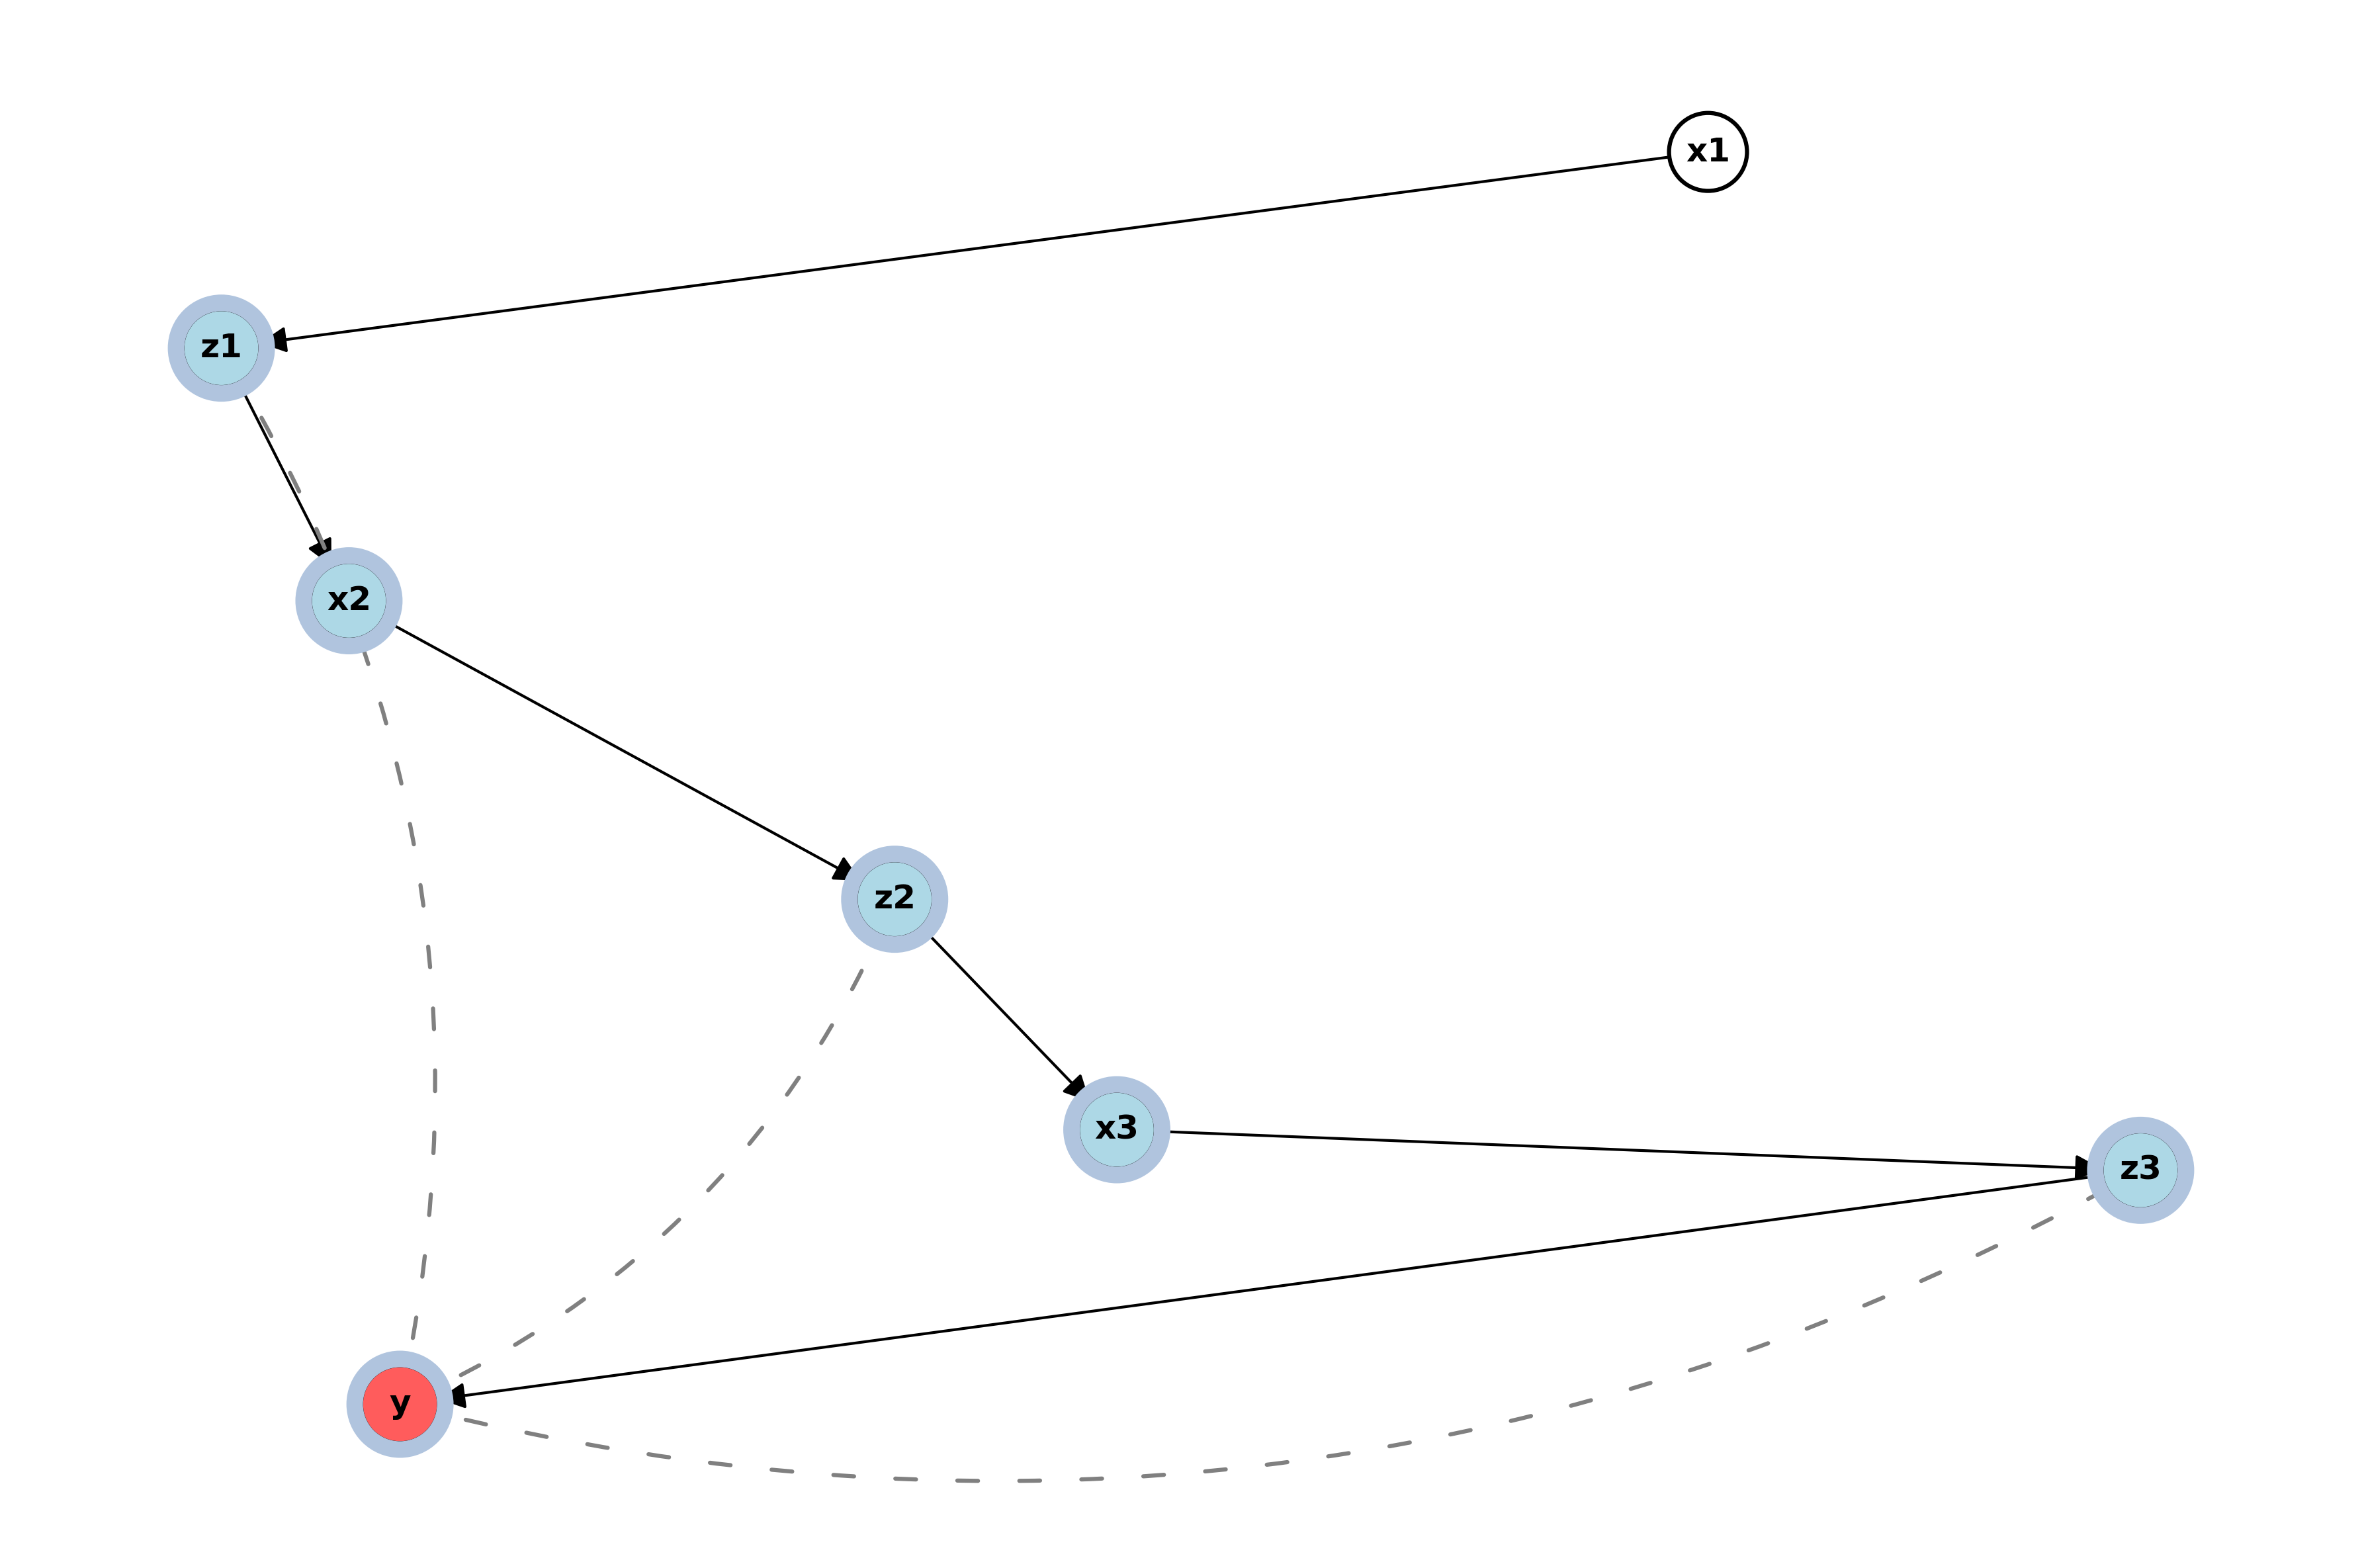

In [32]:
# do_vars = {'c', 'a'}
# induced_vars = {'c', 'a', 'E'}

def exx_cdag():
    x1, z1, x2, z2, x3, z3, y = 'x1', 'z1', 'x2', 'z2', 'x3', 'z3', 'y'
    return CausalGraph({x1, z1, x2, z2, x3, z3, y}, [(x1,z1),(x2,z2),(x3,z3),(z3,y), (z1,x2),(z2,x3)], [(z1,y,'u1'),(z2,y,'u2'),(z3,y,'u3')])

cdag = exx_cdag()

cdag.nx_viz(
    path='./testex.png',
    # pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'y')),  # MUCT
        colors['target']: 'y',                            # Target
        # colors['intervention']: do_vars,                      # Intervention Variable
        # colors['IB']: flatten(task.IB(cdag, 'y')),    # Intevention Boundary
        # 'purple': flatten(task.POMISs(cdag, 'y')),
    }
)[0]

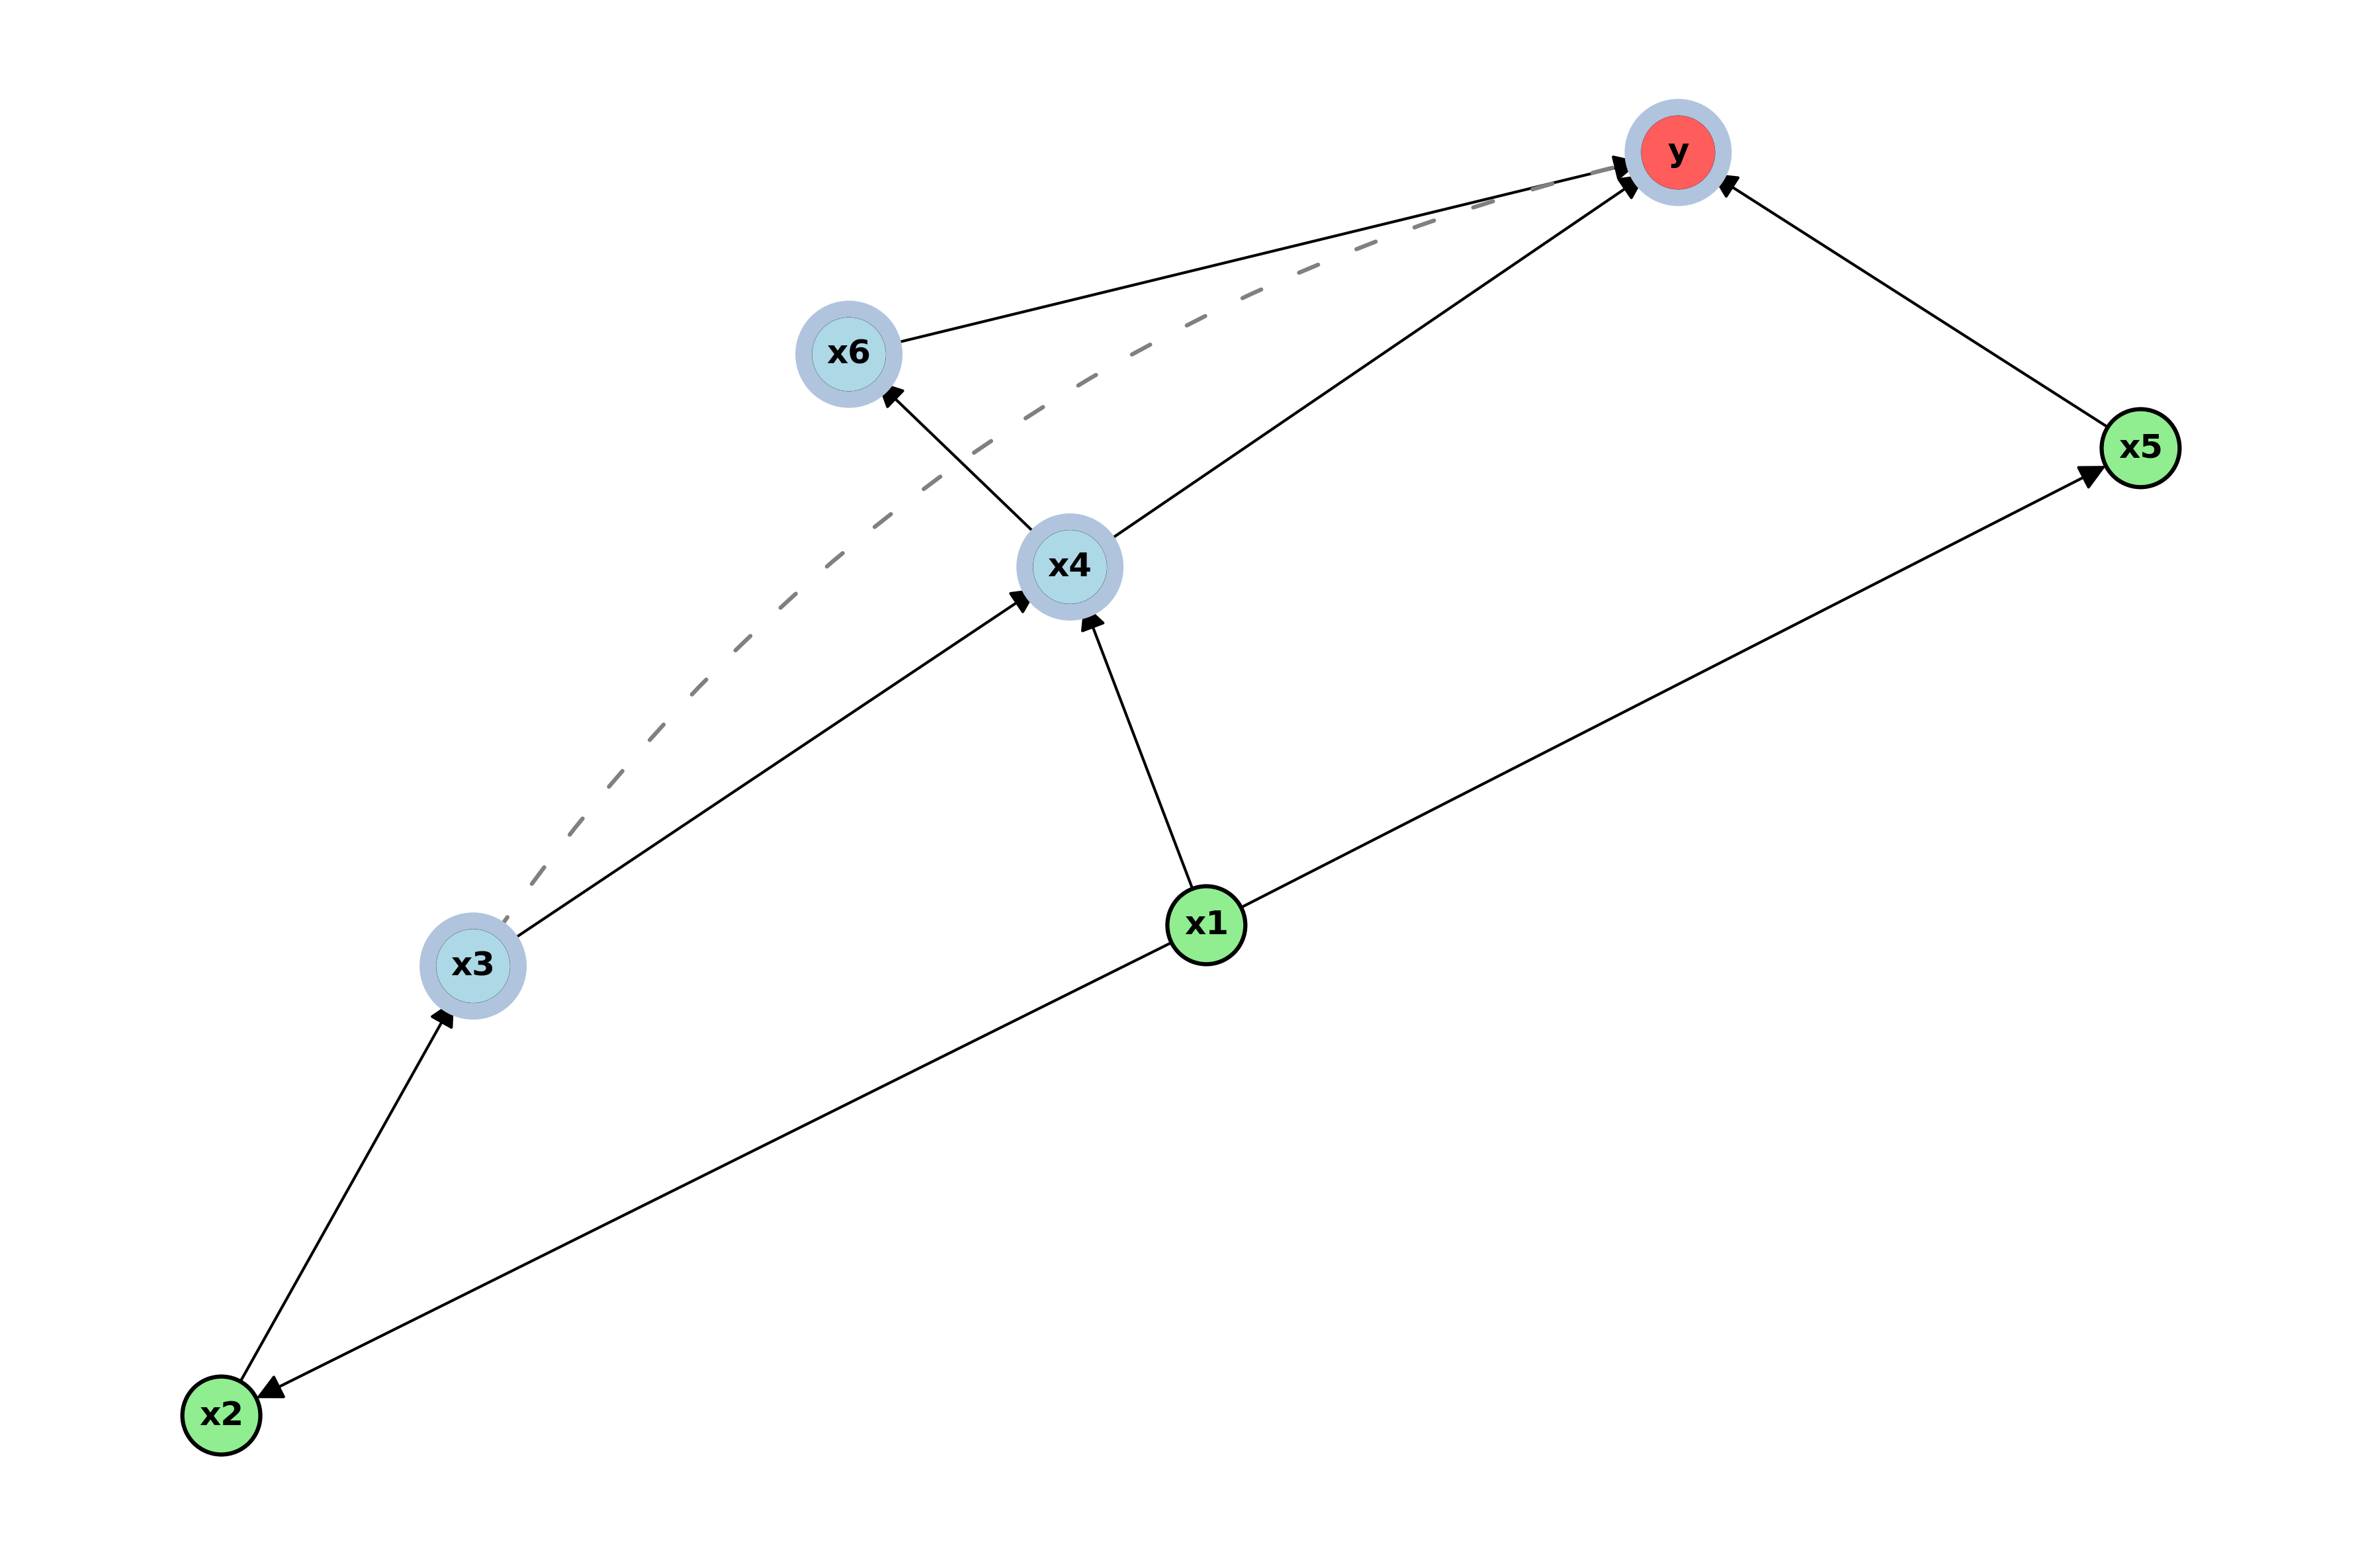

In [20]:
# do_vars = {'c', 'a'}
# induced_vars = {'c', 'a', 'E'}

def exx_cdag():
    x1, x2, x3, x4, x5, x6, y = 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y'
    return CausalGraph({x1, x2, x3, x4, x5, x6, y}, [(x1,x2),(x1,x4),(x1,x5),(x2,x3),(x4,y),(x5,y),(x6,y),(x3,x4),(x4,x6),(x1,x5)], [(x3,y,'u1')])

cdag = exx_cdag()

cdag.nx_viz(
    path='./testex.png',
    # pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'y')),  # MUCT
        colors['target']: 'y',                            # Target
        # colors['intervention']: do_vars,                      # Intervention Variable
        colors['IB']: flatten(task.IB(cdag, 'y')),    # Intevention Boundary
        # 'purple':flatten(task.MISs(cdag,'y'))
    }
)[0]

In [ ]:
# do_vars = {'c', 'a'}
# induced_vars = {'c', 'a', 'E'}

def exx_cdag():
    x1, x2, x3, x4, x5, x6, y = 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y'
    return CausalGraph({x1, x2, x3, x4, x5, x6, y}, [(x1,x2),(x1,x4),(x1,x5),(x2,x3),(x4,y),(x5,y),(x6,y),(x3,x4),(x4,x6),(x1,x5)], [(x3,y,'u1')])

cdag = exx_cdag()

cdag.nx_viz(
    path='./testex.png',
    # pos=pos,
    node_color_map={
        colors['MUCT']: flatten(task.MUCT(cdag, 'y')),  # MUCT
        colors['target']: 'y',                            # Target
        # colors['intervention']: do_vars,                      # Intervention Variable
        colors['IB']: flatten(task.IB(cdag, 'y')),    # Intevention Boundary
        # 'purple':flatten(task.MISs(cdag,'y'))
    }
)[0]

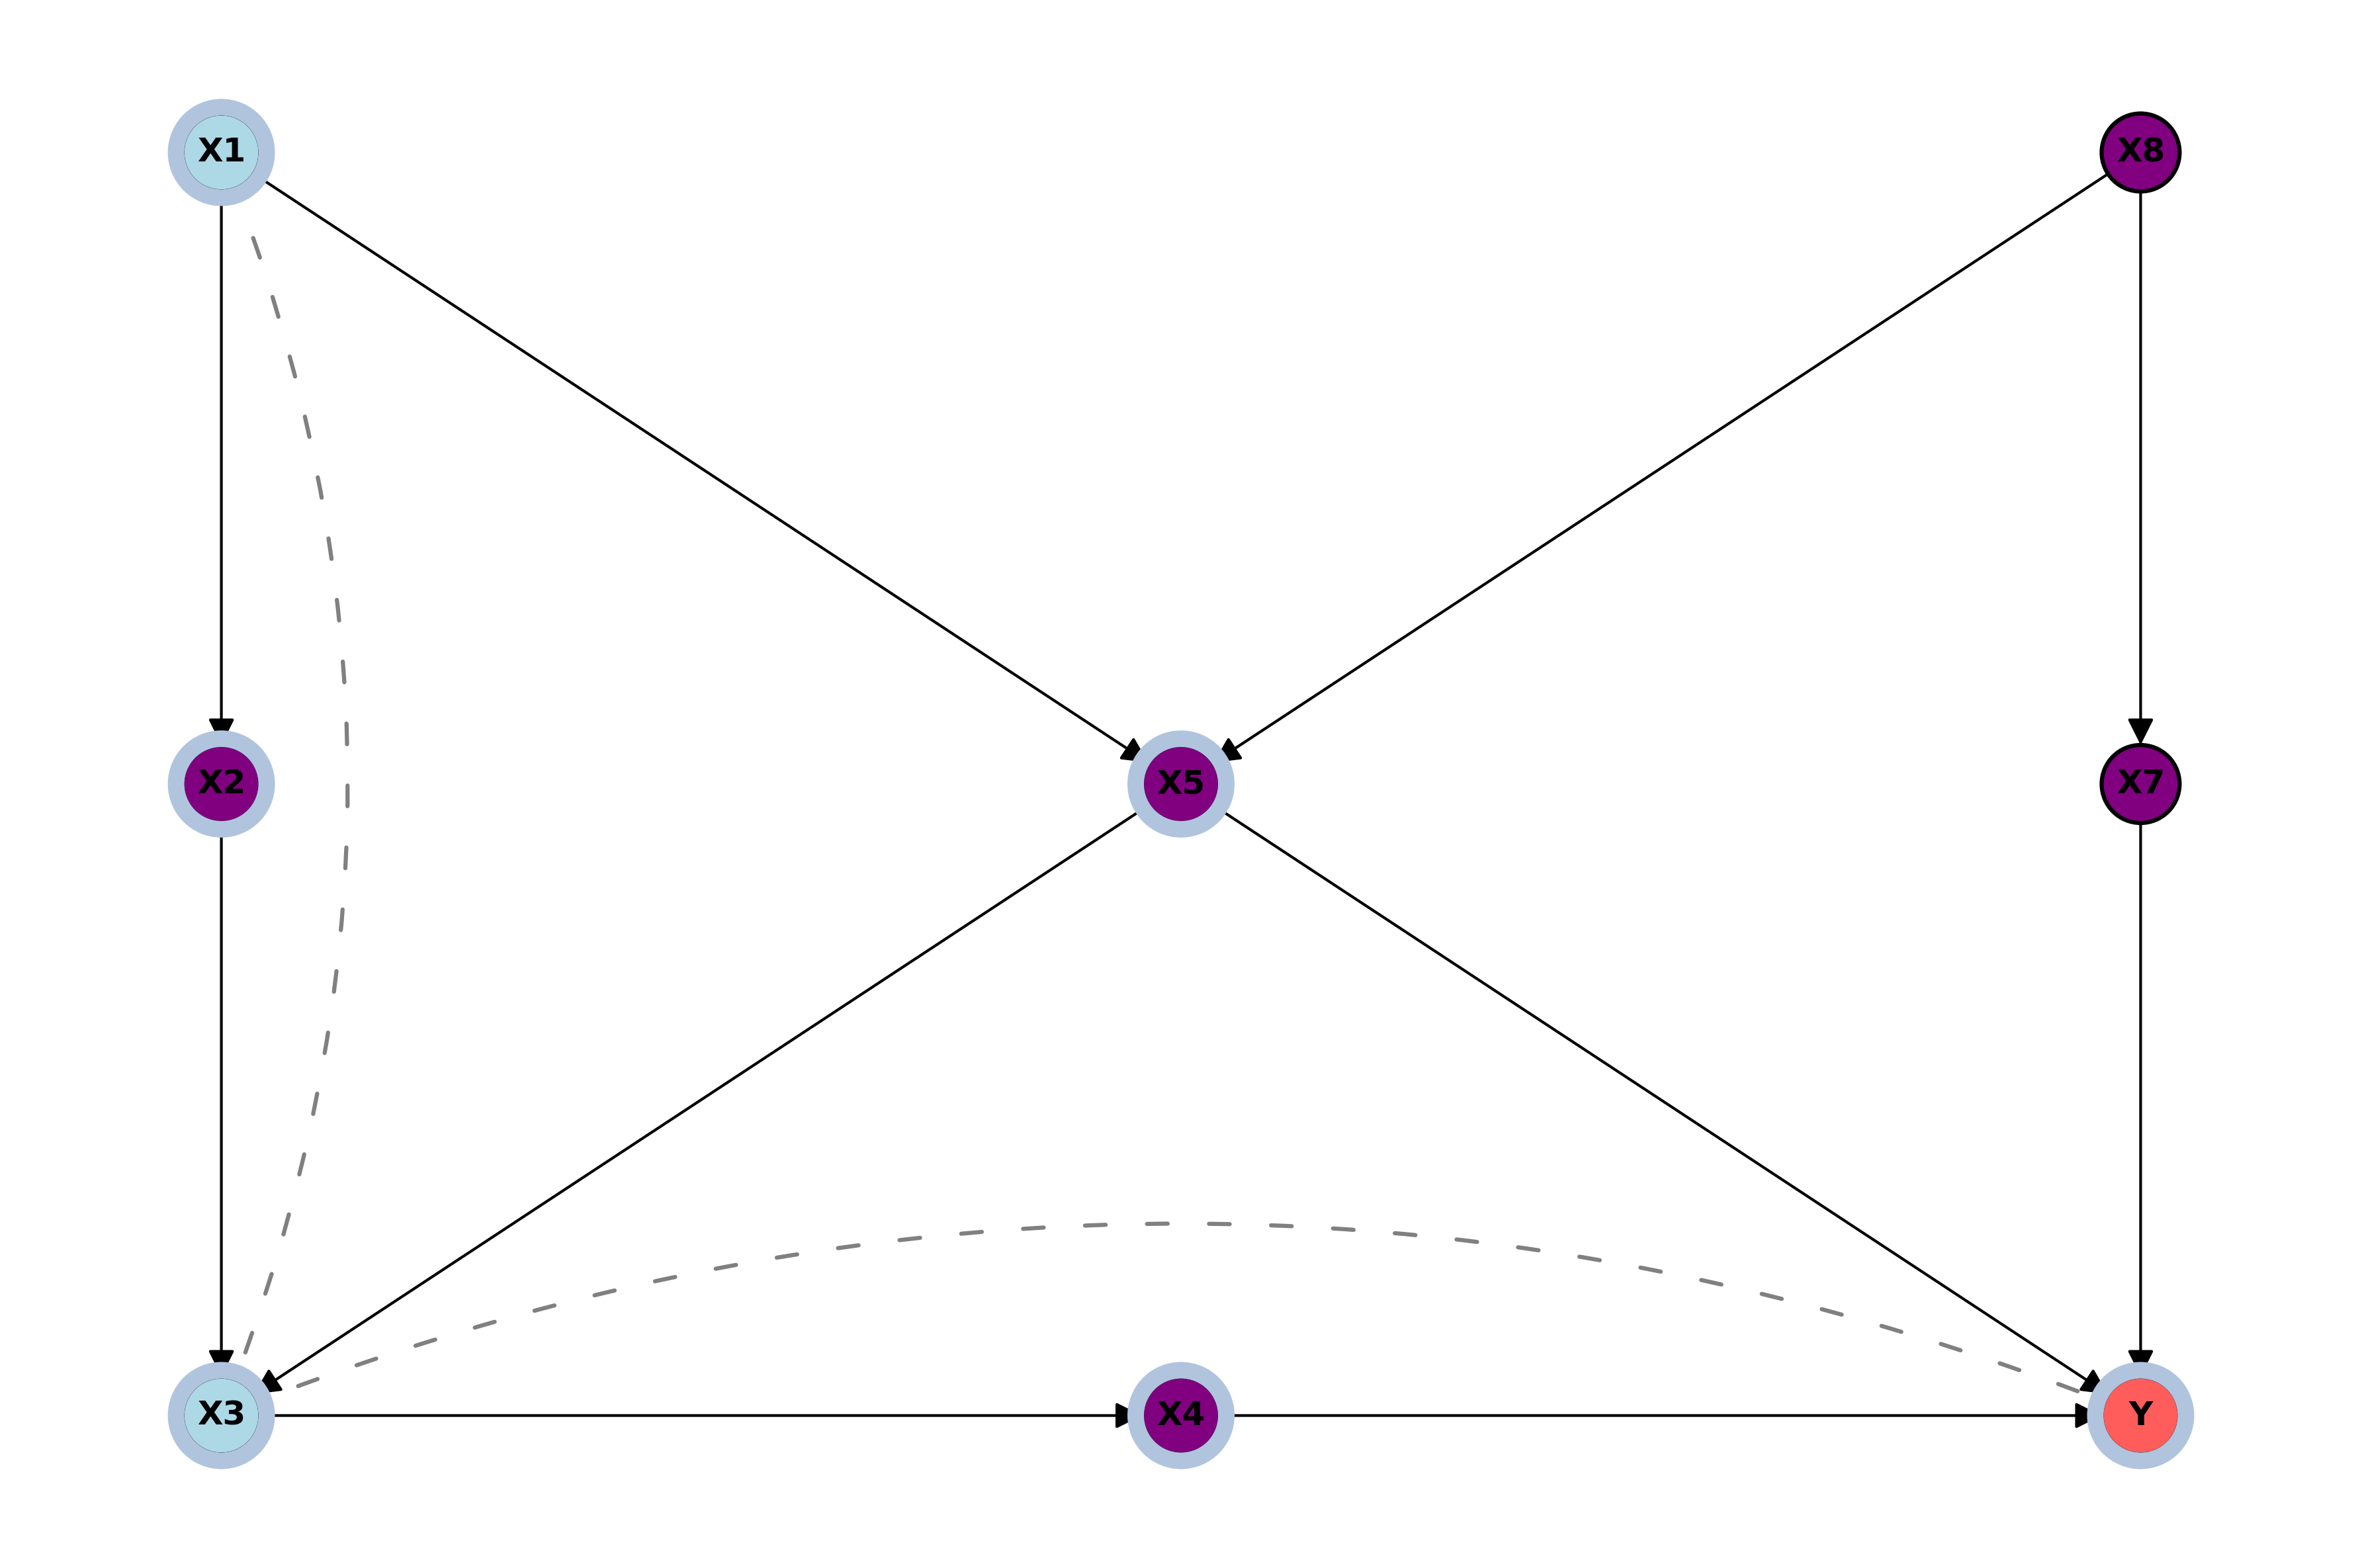

In [21]:
# Assuming necessary imports are present, e.g.:
# from your_causal_library import CausalGraph
# from your_utils import flatten
# import your_tasks_module as task
# colors = {'MUCT': 'lightblue', 'target': 'yellow', 'IB': 'lightgreen', ...} # Define your color map

# Define the graph from the image and node positions
def define_graph_and_positions():
    # Define node names
    x1, x2, x3, x4, x5, x7, x8, y = 'X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'X8', 'Y'
    nodes = {x1, x2, x3, x4, x5, x7, x8, y}

    # Define directed edges based on the image
    edges = [
        (x1, x2), (x2, x3), (x5, x3), (x8, x5),
        (x8, x7), (x7, y), (x5, y), (x3, x4), (x4, y), (x1, x5)
    ]
    bidirected_edges = [(x1,x3,'U_1'),(x3,y,'U_2')]
    # Create the CausalGraph object (No bidirected edges from the image)
    cdag = CausalGraph(nodes, edges, bidirected_edges) # Assuming last argument is for bidirected edges

    # Define positions to match the image layout
    # (adjust coordinates as needed for desired spacing)
    pos = {
        x1: (0, 2),
        x2: (0, 1),
        x3: (0, 0),
        x4: (1, 0),
        x5: (1, 1),
        x8: (2, 2),
        x7: (2, 1),
        y:  (2, 0)
    }
    return cdag, pos

# Get the graph and positions
cdag, pos = define_graph_and_positions()

# Define the target variable
target_node = 'Y' # Assuming Y is the target

# Visualize the graph using the defined positions and calculating MUCT/IB
# (Assuming 'task', 'flatten', and 'colors' are defined elsewhere)
cdag.nx_viz(
    path='./image_graph_viz.png', # Changed output filename
    pos=pos,                      # Use the defined positions
    node_color_map={
        # Assuming task.MUCT and task.IB work with this cdag and target_node
        colors['MUCT']: flatten(task.MUCT(cdag, target_node)),
        colors['target']: target_node,
        colors['IB']: flatten(task.IB(cdag, target_node)),
        'purple': flatten(task.POMISs(cdag, target_node)),
        # Add other color mappings if needed
    }
)[0]

# print(f"Graph visualization saved to ./image_graph_viz.png with specified layout.")
# print(f"Target node: {target_node}")
# # You might want to print the MUCT/IB sets as well:
# # print(f"MUCT: {flatten(task.MUCT(cdag, target_node))}")
# # print(f"IB: {flatten(task.IB(cdag, target_node))}")


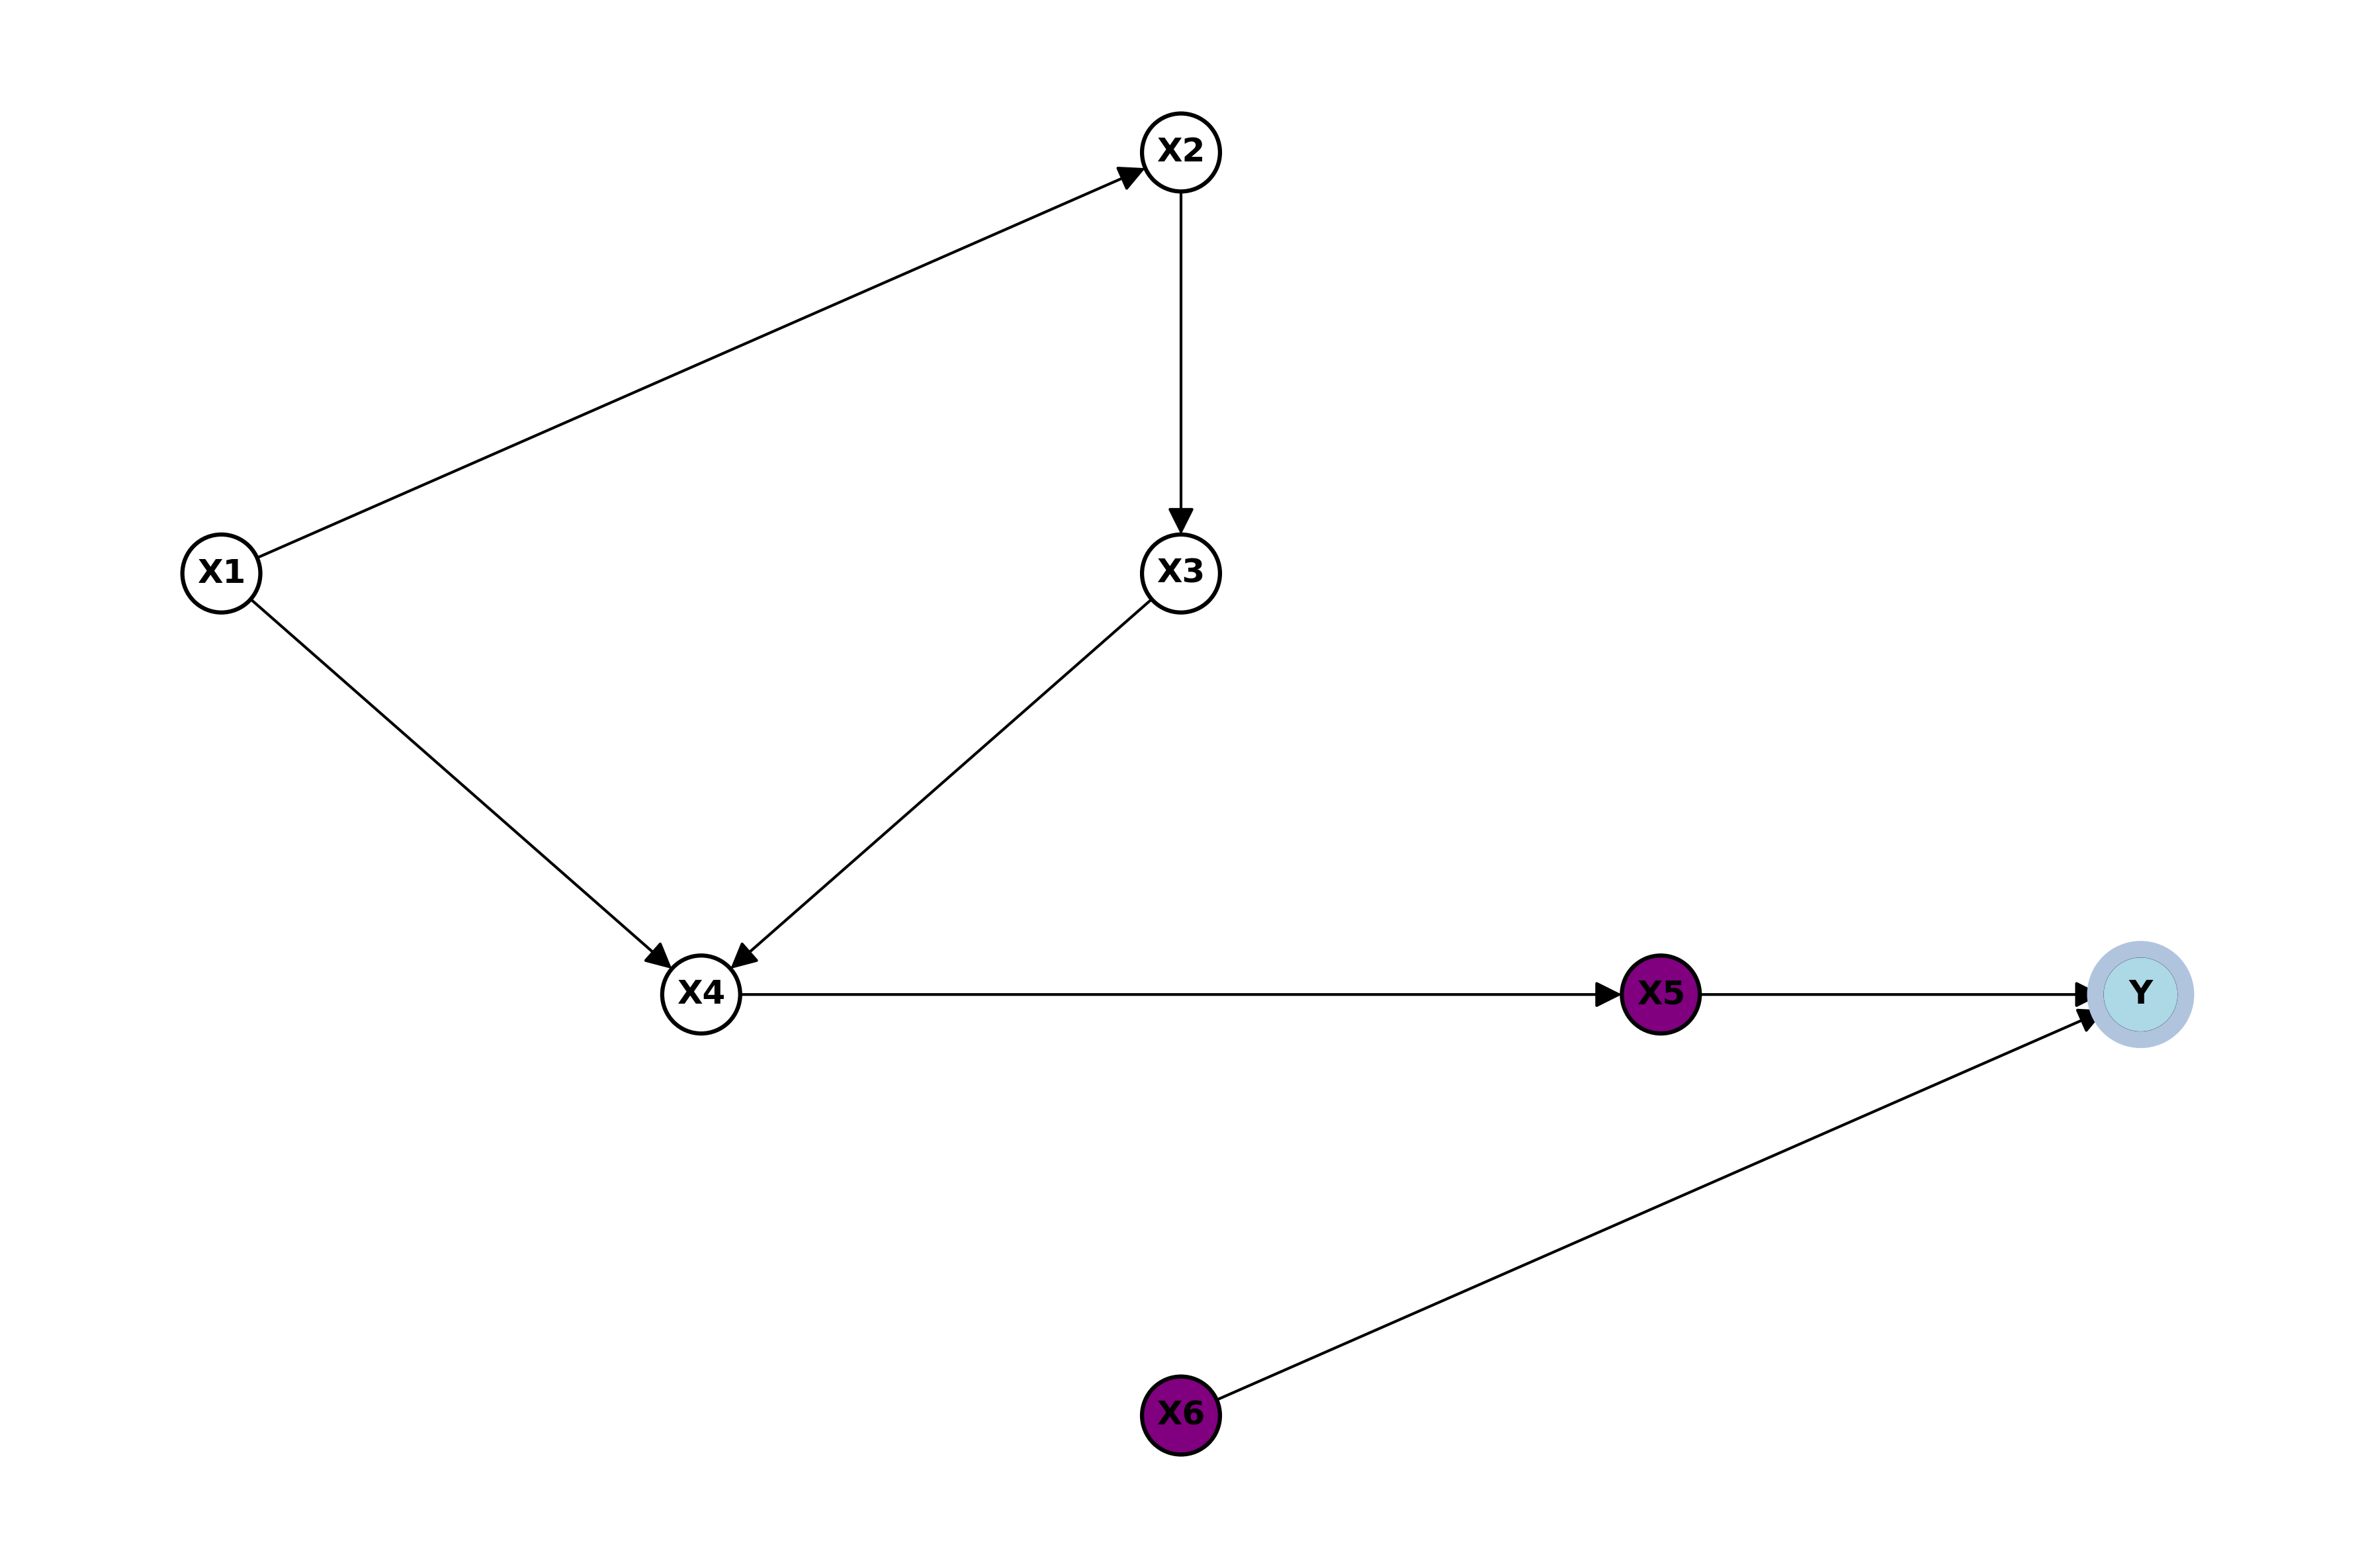

In [41]:
# Assuming necessary imports are present, e.g.:
# from your_causal_library import CausalGraph
# from your_utils import flatten
# import your_tasks_module as task
# colors = {'MUCT': 'lightblue', 'target': 'yellow', 'IB': 'lightgreen', ...} # Define your color map

# Define the graph from the image and node positions
def define_graph_and_positions_v2(): # Renamed function for clarity
    # Define node names
    x1, x2, x3, x4, x5, x6, y = 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y'
    nodes = {x1, x2, x3, x4, x5, x6, y}

    # Define directed edges based on the new image
    edges = [
        (x1, x2), (x1, x4), (x2, x3), (x3, x4),
        (x4, x5),  (x5, y), (x6, y)
    ]
    bidirected_edges = []
    # Create the CausalGraph object (No bidirected edges from the image)
    cdag = CausalGraph(nodes, edges, bidirected_edges) # Assuming last argument is for bidirected edges

    # Define positions to match the new image layout
    # (adjust coordinates as needed for desired spacing)
    pos = {
        x1: (0, 2),
        x2: (1, 3),
        x3: (1, 2),
        x4: (0.5, 1),
        x5: (1.5, 1),
        x6: (1, 0),
        y:  (2, 1)
    }
    return cdag, pos

# Get the graph and positions for the new graph
cdag_v2, pos_v2 = define_graph_and_positions_v2()

# Define the target variable (assuming 'Y' is still the target)
target_node = 'Y'

# Visualize the graph using the defined positions and calculating MUCT/IB
# (Assuming 'task', 'flatten', and 'colors' are defined elsewhere)
cdag_v2.nx_viz(
    path='./image_graph_viz_v2.png', # Updated output filename
    pos=pos_v2,                      # Use the new positions
    node_color_map={
        # Assuming task.MUCT and task.IB work with this cdag and target_node
        colors['MUCT']: flatten(task.MUCT(cdag_v2, target_node)),
        # colors['target']: target_node,
        # colors['IB']: flatten(task.IB(cdag_v2, target_node)),
        'purple': flatten(task.POMISs(cdag_v2, target_node)),
        # Add other color mappings if needed
    }
)[0]

# print(f"Graph visualization saved to ./image_graph_viz_v2.png with specified layout.")
# print(f"Target node: {target_node}")
# Optionally print the MUCT/IB sets for the new graph:
# muct_set_v2 = flatten(task.MUCT(cdag_v2, target_node))
# ib_set_v2 = flatten(task.IB(cdag_v2, target_node))
# print(f"MUCT (v2): {muct_set_v2}")
# print(f"IB (v2): {ib_set_v2}")

In [ ]:

GAMMA = 0
TEST_EPI = 1000
def worker(policy=None):
    env = ExercisePCH(max_step=1000)
    _ = env.reset()
    done = False
    reward = 0
    while not done:
        if policy is None:
            x1, x2, y, _, done, _ = env.see()
        else:
            y, _, done, _ = env.do(policy)
        reward = reward * GAMMA + y
    results.append(reward)

# x = 0
manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': None}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Avg return for do(.) is {sum(results)/len(results)}')


# The interventional policy NULL
def policy_0(u1, u2, u3):
    x1 = u1
    x2 = x1 ^ u2
    x3 = x2 ^ u3
    return x1, x2, x3

# The interventional policy 1: x1 = 1
def policy_1(u1, u2, u3):
    x1 = 1
    x2 = x1 ^ u2
    x3 = x2 ^ u3
    return x1, x2, x3

# The interventional policy 2: x1 = u1, x2 = 1, x3 = u3
def policy_2(u1, u2, u3):
    x1 = u1
    x2 = 1
    x3 = u3
    return x1, x2

# The interventional policy 3: x1 = u1, x2 = u2, x3 = 1
def policy_3(u1, u2, u3):
    x1 = u1
    x2 = u2
    x3 = 1
    return x1, x2, x3

# The interventional policy 4: x1 = 1, x2 = 1, x3 = 

def worker(policy=None):
    env = ExamplePCH_9_5(max_step=1000)
    _ = env.reset()
    done = False
    reward = 0
    while not done:
        if policy is None:
            x1, x2, y, _, done, _ = env.see()
        else:
            y, _, done, _ = env.do(policy)
        reward = reward * GAMMA + y
    results.append(reward)

# x = 0
manager = mp.Manager()
results = manager.list()
pcs = [Process(target=worker, kwargs={'policy': None}) for i in range(TEST_EPI)]
for i in range(TEST_EPI):
    pcs[i].start()
for i in range(TEST_EPI):
    pcs[i].join()
print(f'Avg return for do(x2) is  {sum(results)/len(results)}')
